In [1]:
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.integrate as integrate
from scipy.optimize import minimize
from scipy.special import logsumexp
from tqdm import tqdm
import emcee
import corner

from astropy import units as u 
from astropy.table import Table
from math import *

from snewpy.neutrino import ThreeFlavor, MassHierarchy, MixingParameters, ThreeFlavorMixingParameters,FourFlavorMixingParameters
from snewpy.models.ccsn import Nakazato_2013
from snewpy.models.ccsn import Fornax_2022
from snewpy.models.ccsn import Bollig_2016
from snewpy.models.ccsn import Sukhbold_2015
from snewpy.models.ccsn import Zha_2021
from snewpy.models.ccsn import Tamborra_2014
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes
#from asteria import set_rcparams
from asteria.simulation import Simulation

%matplotlib inline

ha


In [2]:
sukh_param_sfho=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='SFHo')
sukh_param_ls220=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='LS220')


forn_param=list(params for params in Fornax_2022.get_param_combinations() if params['progenitor_mass'].value == 26.99)

zha_param=list(params for params in Zha_2021.get_param_combinations() if params['progenitor_mass'].value == 26)

tamb_param=list(params for params in Tamborra_2014.get_param_combinations() if params['progenitor_mass'].value == 27
               and params['direction']==1)

In [44]:
Sukhbold_2015(**sukh_param_sfho[0])

**Sukhbold_2015 Model**: sukhbold-SFHo-s27.0.fits

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $27$ $\mathrm{M_{\odot}}$|
|EOS | SFHo |

In [3]:
sukh_model_sfho = {'name': 'Sukhbold_2015',
            'param': sukh_param_sfho[0]
              }

sukh_model_ls220 = {'name': 'Sukhbold_2015',
            'param': sukh_param_ls220[0]
              }

forn_model = {'name': 'Fornax_2022',
            'param': forn_param[0]
              }

zha_model = {'name': 'Zha_2021',
            'param': zha_param[0]
              }

tamb_model = {'name': 'Tamborra_2014',
            'param': tamb_param[0]
              }

In [4]:
models=[sukh_model_sfho,sukh_model_ls220,forn_model,zha_model,tamb_model]
labels=['nmo','imo']
hie=['normal','inverted']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']

sims = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

for i,mod in enumerate(models):
    for j,lab in enumerate(labels):
        pred = Simulation(model=mod,
                                         distance=10 * u.kpc, 
                                         Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                                         tmin=-10*u.s,  tmax=10*u.s,    dt=1*u.ms,
                                         mixing_scheme='AdiabaticMSW',
                                         hierarchy=hie[j])
        pred.run()
        if mod['name']=='Fornax_2022':
            with open("ThreeFlavor_{}_M={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                    lab), 'wb') as f:
                pickle.dump(pred, f)
        else:
            with open("Three_Flavor_{}_M={}_eos={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                        mod['param']['eos'],
                                                        lab), 'wb') as f:
                pickle.dump(pred, f)
        sims[mod_names[i]].append(pred)

NMO


C:\Users\sanya\miniconda3\envs\three_flavor6\lib\site-packages\snewpy\models\base.py:343: RuntimeWarning: divide by zero encountered in log
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
C:\Users\sanya\miniconda3\envs\three_flavor6\lib\site-packages\snewpy\models\base.py:343: RuntimeWarning: invalid value encountered in subtract
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
C:\Users\sanya\miniconda3\envs\three_flavor6\lib\site-packages\snewpy\models\base.py:344: RuntimeWarning: divide by zero encountered in divide
  - loggamma(1+a) + a*np.log(E) - (1+a)*(E/Ea)) / (u.erg * u.s)


IMO
he
NMO
IMO
he


Expect a reduction in performance and increase in simulation run times.


NMO


Expect a reduction in performance and increase in simulation run times.


IMO
he


C:\Users\sanya\miniconda3\envs\three_flavor6\lib\site-packages\snewpy\models\__init__.py:61: UserWarning: Argument `eos` is deprecated.
  return getattr(module, model_name)(**user_param)


NMO
IMO
he
NMO
IMO
he


In [7]:
models=[sukh_model_sfho,sukh_model_ls220,forn_model,zha_model,tamb_model]
model_orignals=[Sukhbold_2015,Sukhbold_2015,Fornax_2022,Zha_2021,Tamborra_2014]
labels=['nmo','imo']
hie=['normal','inverted']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']

sims = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

for i,mod in enumerate(models):
    for j,lab in enumerate(labels):
        if mod['name']=='Fornax_2022':
            with open("ThreeFlavor_{}_M={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                    lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))
        else:
            with open("Three_Flavor_{}_M={}_eos={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                        mod['param']['eos'],
                                                        lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))

In [8]:
def compute_hits(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
        
    data=hits[id5:id6]
    return data

In [9]:
def compute_hits_scaled(scale,dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
        
    data=hits[id5:id6]
    
    data_scaled=data*scale
    return data_scaled

In [10]:
def compute_hits_without_sub_bg(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    bg1 = sim.detector.i3_bg(dt,size=hits.size) + sim.detector.dc_bg(dt,size=hits.size)
    sig=bg1+hits
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
    
    return sig[id5:id6]

In [72]:
def compute_model_energy_with_plot(model,hierarchy,t_vals,e_vals):
    spectra=[]
    for i,t in enumerate(t_vals*u.ms):
        ispec=model.get_transformed_spectra(t,e_vals*u.MeV,
                                            AdiabaticMSW(ThreeFlavorMixingParameters(**MixingParameters(mass_order=hierarchy))))
        spectra.append(ispec[ThreeFlavor(1)])
        
    T, E = np.meshgrid(t_vals,e_vals)
    T_flat = T.flatten()
    E_flat = E.flatten()
    spectra=np.array(spectra)
    
    max_fluxes = np.max(spectra, axis=1) 
    normalized_fluxes = spectra / max_fluxes[:, np.newaxis]
    normalized_fluxes_flat=normalized_fluxes.T.flatten()
    
    delta_E = np.diff(e_vals)
    delta_E = np.append(delta_E, delta_E[-1])  
    
    mean_energies=[]
    for i in range(spectra.shape[0]):
        numerator = np.sum(e_vals * spectra[i] * delta_E)
        denominator = np.sum(spectra[i] * delta_E)
        mean_energies.append(numerator / denominator)
        
    return T_flat, E_flat, normalized_fluxes_flat, mean_energies

In [57]:
def compute_model_energy(model,hierarchy,t_vals,e_vals):
    spectra=[]
    for i,t in enumerate(t_vals*u.ms):
        ispec=model.get_transformed_spectra(t,e_vals*u.MeV,
                                            AdiabaticMSW(ThreeFlavorMixingParameters(**MixingParameters(mass_order=hierarchy))))
        spectra.append(ispec[ThreeFlavor(1)])
    
    spectra=np.array(spectra)
    
    delta_E = np.diff(e_vals)
    delta_E = np.append(delta_E, delta_E[-1])  
    
    mean_energies=[]
    for i in range(spectra.shape[0]):
        numerator = np.sum(e_vals * spectra[i] * delta_E)
        denominator = np.sum(spectra[i] * delta_E)
        mean_energies.append(numerator / denominator)
        
    return mean_energies

In [68]:
def compute_data_energy(model,hierarchy,t_vals,e_vals,sigma):
    mean_E=compute_model_energy(model,hierarchy,t_vals,e_vals)
    reco_E=[]
    for i,t in enumerate(t_vals):
        reco_E.append(np.random.normal(loc=mean_E[i],scale=sigma,size=None))
    return reco_E

In [12]:
dt=10*u.ms
dist=10*u.kpc
t, hits = sims['sukh_sfho'][0].detector_signal(dt)
bg1 = sims['sukh_sfho'][0].detector.i3_bg(dt,size=hits.size) + sims['sukh_sfho'][0].detector.dc_bg(dt,size=hits.size)
sig=bg1+hits
id1=np.where(t==-5*u.s)[0][0]
id2=np.where(t==-.5*u.s)[0][0]
id5=np.where(t==-1*u.s)[0][0]
id6=np.where(t==.46*u.s)[0][0]

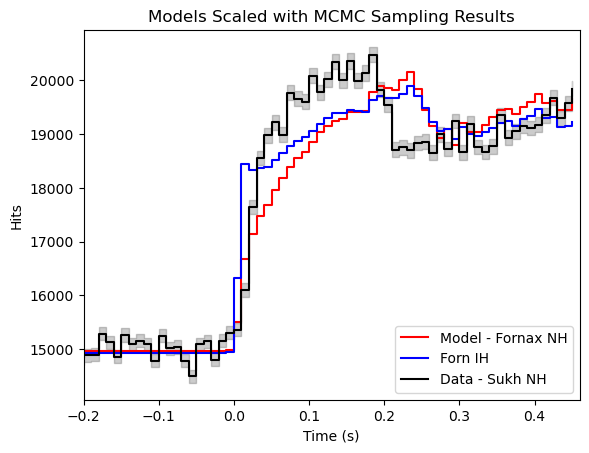

In [14]:
dt=10*u.ms
data_hits=compute_hits_without_sub_bg(dist,dt,-1*u.s,.46*u.s,sims['sukh_sfho'][0])
sim_hits = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
for i,name in enumerate(mod_names):
    model0=compute_hits(dist,dt,-1*u.s,.46*u.s,sims[name][0])
    model1=compute_hits(dist,dt,-1*u.s,.46*u.s,sims[name][1])
    #sim_hits[name].append(compute_hits_scaled(5000/np.max(model0),dist,dt,.02*u.s,.46*u.s,sims[name][0]))
    #sim_hits[name].append(compute_hits_scaled(5000/np.max(model1),dist,dt,.02*u.s,.46*u.s,sims[name][1]))
    sim_hits[name].append(.486*compute_hits(dist,dt,-1*u.s,.46*u.s,sims[name][0]))
    sim_hits[name].append(.608*compute_hits(dist,dt,-1*u.s,.46*u.s,sims[name][1]))

plt.step(t[id5:id6], 14965+sim_hits['forn'][0], where='post',color='red',label='Model - Fornax NH')
plt.step(t[id5:id6], 14925+sim_hits['forn'][1], where='post',color='blue',label='Forn IH')
plt.step(t[id5:id6], data_hits, where='post',color='black',label='Data - Sukh NH')
plt.fill_between(t[id5:id6], data_hits-np.sqrt(data_hits), data_hits+np.sqrt(data_hits),step='post',color='black', alpha=0.2)
plt.xlabel('Time (s)')
plt.xlim(-.2,.46)
plt.ylabel('Hits')
plt.title('Models Scaled with MCMC Sampling Results')
plt.legend(loc='lower right')

In [329]:
print(log_likelihood_energy(sim_energies['zha'][0],data_energy,3))
print(log_likelihood_energy(sim_energies['zha'][1],data_energy,3))

-126.11172645825184
-126.6042536904273


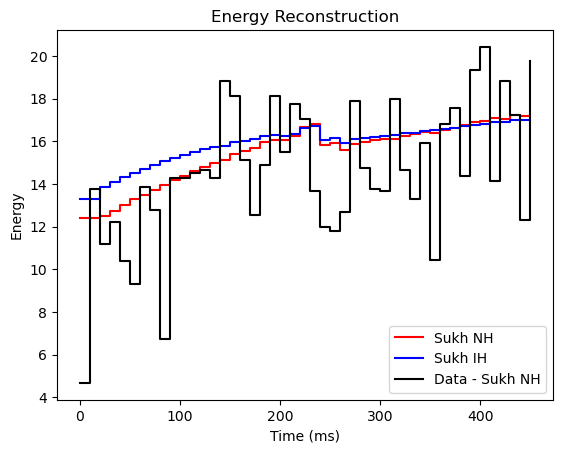

In [330]:
dt=10*u.ms
times=np.arange(0,460,10)
energies=np.arange(0, 50, 1)

params=[sukh_param_sfho,sukh_param_ls220,forn_param,zha_param,tamb_param]
model_originals=[Sukhbold_2015,Sukhbold_2015,Fornax_2022,Zha_2021,Tamborra_2014]

data_energy=compute_data_energy(Sukhbold_2015(**sukh_param_ls220[0]),MassHierarchy.NORMAL,times,energies,3)
"""
sim_energies = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
for i,name in enumerate(mod_names):
    sim_energies[name].append(compute_model_energy(model_originals[i](**params[i][0]),MassHierarchy.NORMAL,times,energies))
    sim_energies[name].append(compute_model_energy(model_originals[i](**params[i][0]),MassHierarchy.INVERTED,times,energies))
"""

plt.step(times, sim_energies['tamb'][0], where='post',color='red',label='Sukh NH')
plt.step(times, sim_energies['tamb'][1], where='post',color='blue',label='Sukh IH')
plt.step(times, data_energy, where='post',color='black',label='Data - Sukh NH')
plt.xlabel('Time (ms)')
plt.ylabel('Energy')
plt.title('Energy Reconstruction')
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Sukhbold Fluxes and Mean Energies')

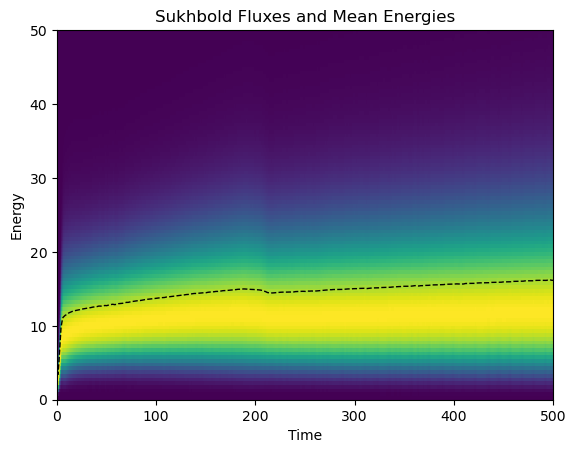

In [73]:
E_vals=np.linspace(0,50,100)
t_vals=np.linspace(0,500,500)

T_flat, E_flat, fluxes_flat, mean_energies = compute_model_energy_with_plot(Sukhbold_2015(**sukh_param_sfho[0]),
                                                                  MassHierarchy.NORMAL,t_vals,E_vals)

hist = plt.hist2d(T_flat, E_flat, weights=fluxes_flat, bins=[500, 100], cmap='viridis')
plt.plot(t_vals,mean_energies,color='black',lw=1,ls='--',label='Mean E')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Sukhbold Fluxes and Mean Energies')

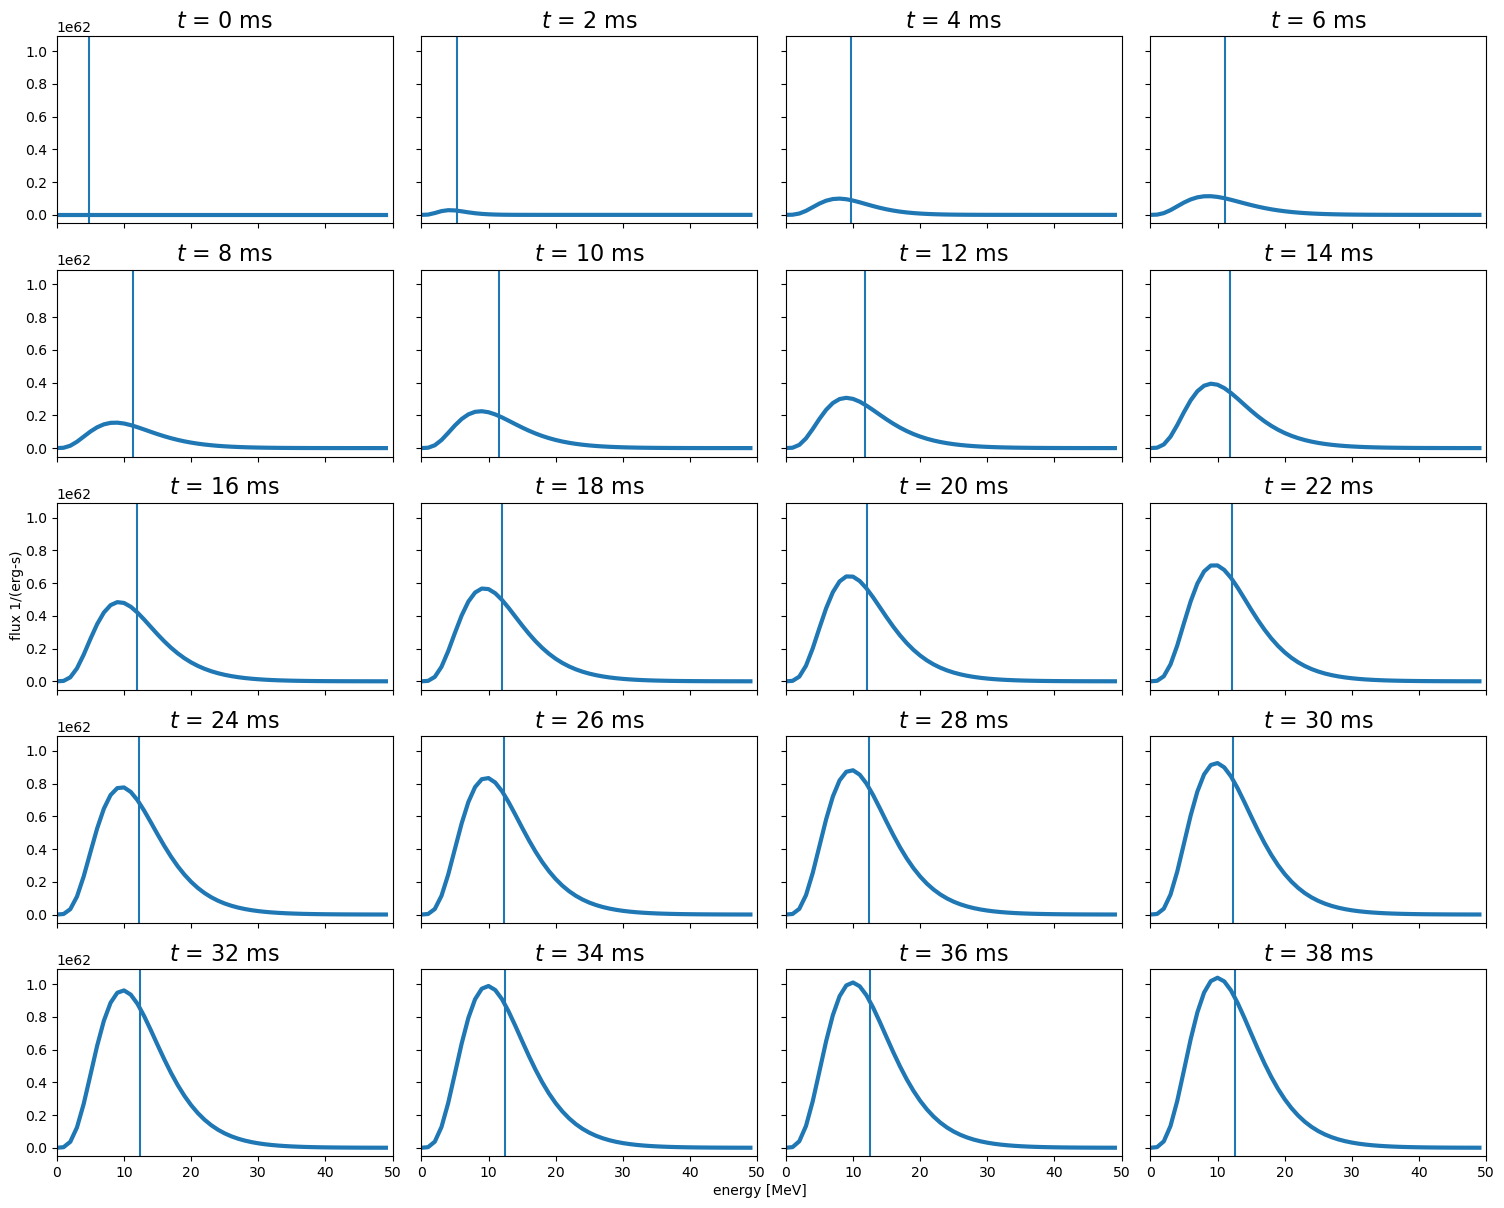

In [55]:
#model = models[23.43*u.solMass]
fig, axes = plt.subplots(5,4, figsize=(15,12), sharex=True, sharey=True, tight_layout=True)

times1 = np.arange(0, 40, 2) * u.ms
E_vals=np.arange(0, 50, 1)
E = np.arange(0, 50, 1) * u.MeV

model=Sukhbold_2015(**sukh_param_sfho[0])
hierarchy=MassHierarchy.NORMAL

spectra=[]
for i,t in enumerate(times1):
    ispec=model.get_transformed_spectra(t,E,
                                        AdiabaticMSW(ThreeFlavorMixingParameters(**MixingParameters(mass_order=hierarchy))))
    spectra.append(ispec[ThreeFlavor(1)])
    
spectra=np.array(spectra)
    
max_fluxes = np.max(spectra, axis=1) 
normalized_fluxes = spectra / max_fluxes[:, np.newaxis]
normalized_fluxes_flat=normalized_fluxes.T.flatten()
    
delta_E = np.diff(E_vals)
delta_E = np.append(delta_E, delta_E[-1])  
    
mean_energies=[]
for i in range(spectra.shape[0]):
    numerator = np.sum(E_vals * spectra[i] * delta_E)
    denominator = np.sum(spectra[i] * delta_E)
    mean_energies.append(numerator / denominator)
        

for i, ax in enumerate(axes.flatten()):
    ax.plot(E, spectra[i], lw=3)
    ax.axvline(x=mean_energies[i])
    ax.set(xlim=(0,50))
    ax.set_title('$t$ = {:g}'.format(times1[i]), fontsize=16)
    
fig.text(0.5, 0., 'energy [MeV]', ha='center')
fig.text(0., 0.5, 'flux 1/(erg-s)', va='center', rotation='vertical');

In [15]:
def log_prob_poisson(theta, model_hits, data_hits,betamin, betamax, bmin, bmax):
    beta,bg=theta
    
    if bmin <= bg <= bmax and betamin <= beta <= betamax:
        log_prior = np.log(1/(betamax-betamin)*1/(bmax-bmin))
        return log_likelihood_poisson(bg, beta, model_hits, data_hits) + log_prior
    
    return -np.inf 

In [16]:
def log_prob_with_energy(theta, model_hits, data_hits, model_e, data_e, sigma, betamin, betamax, bmin, bmax):
    beta,bg=theta
    
    if bmin <= bg <= bmax and betamin <= beta <= betamax:
        log_prior = np.log(1/(betamax-betamin)*1/(bmax-bmin))
        return log_likelihood_poisson(bg,beta,model_hits,data_hits) + log_likelihood_energy(model_e,data_e,sigma)+ log_prior
    
    return -np.inf 

In [17]:
def log_likelihood_poisson(bg,scale,model_hits,data_hits):
    result=0
    for i in range(len(model_hits)):
        result+=data_hits[i]*np.log(bg+scale*model_hits[i])-bg-scale*model_hits[i]-lgamma(data_hits[i]+1)
    return result

In [18]:
def log_likelihood_energy(pred_e, dat_e, sigma):
    result=0
    for i in range(len(pred_e)):
        result+= np.log(1/(sigma*np.sqrt(2*np.pi)))-.5*((dat_e[i]-pred_e[i])/sigma)**2
    return result

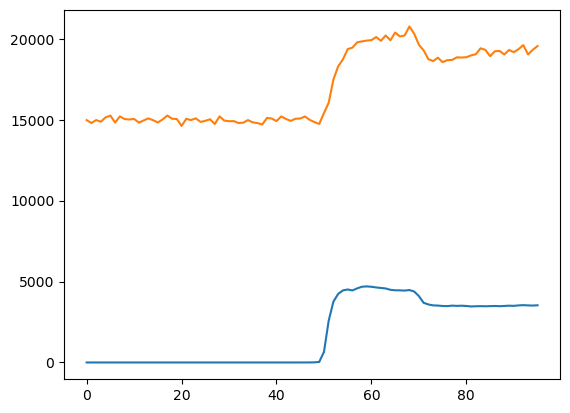

In [199]:
plt.plot(model)
plt.plot(data)

In [201]:
def compute_log_integral(data_hits,model_sim,data_e,model_e,sigma,dist,dt):
    model_hits=compute_hits(dist,dt,-.5*u.s,.46*u.s,model_sim)
    
    betamin=0
    betamax=30000/np.max(model_hits)
    
    self=model_sim.detector
    bg_mean= self.i3_dom_bg_mu * dt.to(u.s).value * self.n_i3_doms + self.dc_dom_bg_mu * dt.to(u.s).value * self.n_dc_doms
    bg_var= (self.i3_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_i3_doms))**2 + (self.dc_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_dc_doms))**2
    bg_sig=np.sqrt(bg_var)
    
    bmin= bg_mean-3*bg_sig
    bmax= bg_mean+3*bg_sig
    
    ndim = 2
    nwalkers = 32
    
    bminguess= bg_mean-1*bg_sig
    bmaxguess= bg_mean+1*bg_sig

    initial_positions = np.random.uniform([betamin, bminguess], [betamax, bmaxguess], (nwalkers, ndim))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_with_energy, args=(model_hits, data_hits, 
                                                                            model_e,data_e,sigma,
                                                                            betamin, betamax, bmin, bmax))

    nsteps = 1000
    sampler.run_mcmc(initial_positions, nsteps)

    burn_in = 100
    samples = sampler.get_chain(discard=burn_in, flat=True)
    
    logprob=[log_prob_with_energy((beta,b), model_hits, data_hits, 
                                                model_e,data_e,sigma,
                                                betamin, betamax, bmin, bmax) for beta,b in samples]
    print(np.max(logprob))
    
    bs=samples[:,0]
    betas=samples[:,1]
    integration_area=(np.max(bs)-np.min(bs))*(np.max(betas)-np.min(betas))
    logint=np.log(integration_area/len(samples[:,0]))+logsumexp(logprob)

    return logint

In [83]:
def log_probs_with_energies(data_sim,model_sims, data_mod, model_energies, sigma,priors,dist,dt,hierarchy,errs):
    log_probs_nh=[]
    log_probs_ih=[]
    times=np.arange(0,460,10)
    energies=np.arange(0, 50, 1)
    
    for j in tqdm(range(errs)):
        data_hits=compute_hits_without_sub_bg(dist,dt,-.5*u.s,.46*u.s,data_sim)
        data_e=compute_data_energy(data_mod,hierarchy,times,energies,sigma)
        
        log_prob_nh=[]
        log_prob_ih=[]
        for k,name in enumerate(model_sims.keys()):
            if(priors[k]!=0):
                log_p_d_nh=compute_log_integral(data_hits,model_sims[name][0], 
                                                data_e, model_energies[name][0], sigma, dist,dt)
                log_p_d_ih=compute_log_integral(data_hits,model_sims[name][1], 
                                                data_e, model_energies[name][1], sigma, dist,dt)
                print(name, log_p_d_nh,log_p_d_ih)
                
                log_prob_nh.append(log_p_d_nh-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(priors[k]))
                log_prob_ih.append(log_p_d_ih-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(priors[k]))
                
        prob_nh=logsumexp(log_prob_nh)
        prob_ih=logsumexp(log_prob_ih)
        
        log_probs_nh.append(prob_nh)
        log_probs_ih.append(prob_ih)
            
    return log_probs_nh, log_probs_ih

In [93]:
def log_probs_with_energies_mult_priors(data_sim,model_sims, data_mod, model_energies, sigma,priors,dist,dt,hierarchy,errs):
    log_ratios=[]
    times=np.arange(0,460,10)
    energies=np.arange(0, 50, 1)
    
    for j in tqdm(range(errs)):
        data_hits=compute_hits_without_sub_bg(dist,dt,-.5*u.s,.46*u.s,data_sim)
        data_e=compute_data_energy(data_mod,hierarchy,times,energies,sigma)
        
        log_prob_nh=[]
        log_prob_ih=[]
        log_ratio=[]
        for k,name in enumerate(model_sims.keys()):
            log_p_d_nh=compute_log_integral(data_hits,model_sims[name][0], 
                                                data_e, model_energies[name][0], sigma, dist,dt)
            log_p_d_ih=compute_log_integral(data_hits,model_sims[name][1], 
                                                data_e, model_energies[name][1], sigma, dist,dt)
            log_prob_nh.append(log_p_d_nh)
            log_prob_ih.append(log_p_d_ih)
 
        for i,prior in enumerate(priors):   
            p_nh=[]
            p_ih=[]
            for k,pro in enumerate(log_prob_nh):
                log_p_d_nh=pro
                log_p_d_ih=log_prob_ih[k]
                
                p_nh.append(log_p_d_nh-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(prior[k]))
                p_ih.append(log_p_d_ih-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(prior[k]))

            print(p_nh,p_ih)
            prob_nh=logsumexp(p_nh)
            prob_ih=logsumexp(p_ih)
            
            if(hierarchy==MassHierarchy.NORMAL):
                log_ratio.append(prob_nh-prob_ih)
            else:
                log_ratio.append(prob_ih-prob_nh)
        log_ratios.append(log_ratio)
            
    return log_ratios

-89.50467658028043


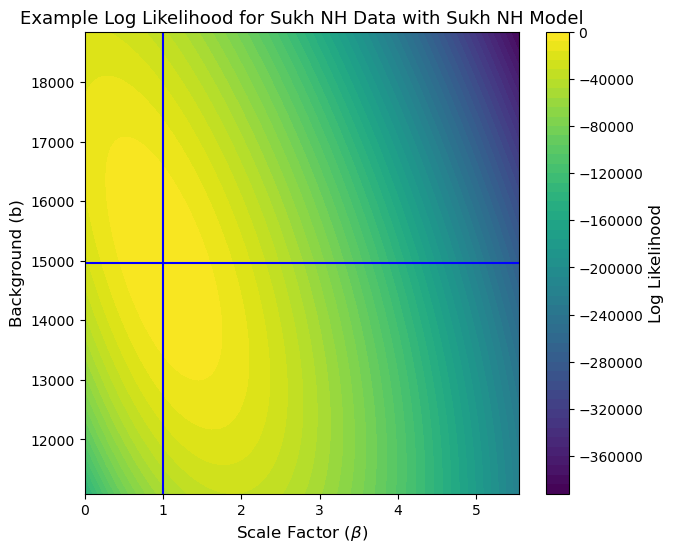

-675.250225466225


In [333]:
dt=10*u.ms
dist=10*u.kpc
data=compute_hits_without_sub_bg(dist,dt,-.5*u.s,.46*u.s, sims['sukh_sfho'][0])
model=compute_hits(dist,dt,-.5*u.s,.46*u.s, sims['sukh_sfho'][0])
model_sim=sims['sukh_sfho'][0]

times=np.arange(0,460,10)
energies=np.arange(0, 50, 1)
data_e=compute_data_energy(Sukhbold_2015(**sukh_param_sfho[0]),MassHierarchy.NORMAL,times,energies,1.75)
model_e=sim_energies['sukh_sfho'][0]

    
betamin=0
betamax=30000/np.max(model)
    
self=model_sim.detector
bg_mean= self.i3_dom_bg_mu * dt.to(u.s).value * self.n_i3_doms + self.dc_dom_bg_mu * dt.to(u.s).value * self.n_dc_doms
bg_var= (self.i3_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_i3_doms))**2 + (self.dc_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_dc_doms))**2
bg_sig=np.sqrt(bg_var)
    
bmin= bg_mean-20*bg_sig
bmax= bg_mean+20*bg_sig


scale_values=np.linspace(betamin,betamax,100)
bg_values=np.linspace(bmin,bmax,100)

bg_grid, scale_grid = np.meshgrid(bg_values, scale_values)

# Evaluate the log-likelihood function on the grid
log_likelihood_grid = np.zeros_like(bg_grid)
for i in range(bg_grid.shape[0]):
    for j in range(bg_grid.shape[1]):
        #log_likelihood_grid[i, j] = log_likelihood_poisson(bg_grid[i, j], scale_grid[i, j], model, data)
        #log_likelihood_grid[i, j] = log_likelihood_energy(model_e,data_e,.5)
        log_likelihood_grid[i, j] = log_prob_with_energy((scale_grid[i, j],bg_grid[i, j]), model, data,
                                                         model_e, data_e, 1.75,
                                                         betamin, betamax, bmin, bmax)

print(log_likelihood_energy(model_e, data_e, 1.75))
# Create the 2D plot
plt.figure(figsize=(7, 6))
contour = plt.contourf(scale_grid, bg_grid, log_likelihood_grid, cmap='viridis', levels=50)
cbar=plt.colorbar(contour)
cbar.set_label('Log Likelihood', fontsize=12)

# Add labels
plt.xlabel(r'Scale Factor ($\beta$)',fontsize=12)
plt.ylabel(r'Background (b)',fontsize=12)
plt.title(r'Example Log Likelihood for Sukh NH Data with Sukh NH Model',fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.axvline(x=1,color='blue')
plt.axhline(y=bg_mean,color='blue')

plt.show()




results=[]
for i,scale in enumerate(scale_values):
    #result = integrand_poisson(scale, 15500, model, data, bmin,bmax,betamin,betamax)
    result=log_likelihood_poisson(bg_mean,scale,model,data)
    results.append(result)
    
results_bg=[]
for i,bg in enumerate(bg_values):
    #result = integrand_poisson(scale, 15500, model, data, bmin,bmax,betamin,betamax)
    result=log_likelihood_poisson(bg,1.02,model,data)
    results_bg.append(result)


    
#plt.plot(bg_values,np.array(results_bg))
#print(scales[np.argmax(results)])
#print(bgs[np.argmax(results_bg)])
print(np.max(results))
#plt.yscale('log')
#plt.xlabel('scale factor')
#plt.ylabel('likelihood')



Text(0.5, 0.98, 'MCMC Results for Fornax NH Model')

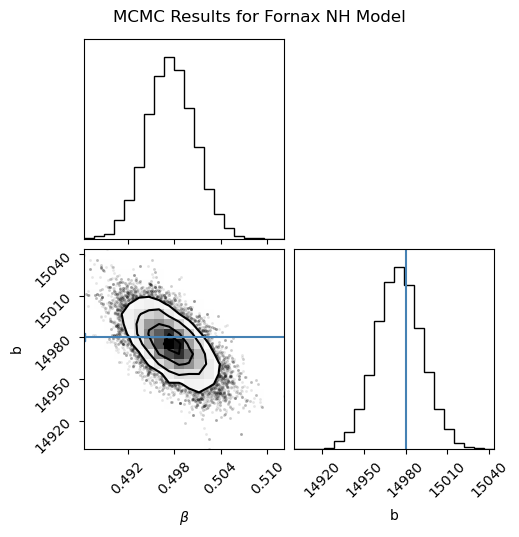

In [80]:
ndim = 2
nwalkers = 32

dist=10*u.kpc
dt=10*u.ms

#data=compute_hits_without_sub_bg(dist,dt,-.5*u.s,.46*u.s, sims['sukh_sfho'][1])
model=compute_hits(dist,dt,-.5*u.s,.46*u.s, sims['forn'][0])
model_sim=sims['sukh_ls220'][1]

times=np.arange(0,460,10)
energies=np.arange(0, 50, 1)
data_e=compute_data_energy(Sukhbold_2015(**sukh_param_sfho[0]),MassHierarchy.NORMAL,times,energies,.5)
model_e=sim_energies['forn'][0]

    
betamin=0
betamax=30000/np.max(model)
    
self=model_sim.detector
bg_mean= self.i3_dom_bg_mu * dt.to(u.s).value * self.n_i3_doms + self.dc_dom_bg_mu * dt.to(u.s).value * self.n_dc_doms
bg_var= (self.i3_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_i3_doms))**2 + (self.dc_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_dc_doms))**2
bg_sig=np.sqrt(bg_var)
    
bmin= bg_mean-3*bg_sig
bmax= bg_mean+3*bg_sig

bminguess= bg_mean-1*bg_sig
bmaxguess= bg_mean+1*bg_sig

initial_positions = np.random.uniform([betamin, bmin], [betamax, bmax], (nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_with_energy, args=(model, data, 
                                                                            model_e,data_e,.5,
                                                                            betamin, betamax, bmin, bmax))

nsteps = 1000
sampler.run_mcmc(initial_positions, nsteps)

burn_in = 100
samples = sampler.get_chain(discard=burn_in, flat=True)

fig = corner.corner(samples, labels=[r'$\beta$','b'], truths=[.486, 14980])
fig.suptitle('MCMC Results for Fornax NH Model')

In [ ]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["beta", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [226]:
priors=[.2,.2,.2,.2,.2]
prob_ih=log_probs_with_energies(sims['tamb'][1],sims, model_originals[i](**params[i][0]),
                                                       sim_energies, .5,priors,10*u.kpc,10*u.ms,
                                                       MassHierarchy.INVERTED,1)
        
prob_nh=log_probs_with_energies(sims['tamb'][0],sims, model_originals[i](**params[i][0]),
                                                       sim_energies, .5,priors,10*u.kpc,10*u.ms,
                                                       MassHierarchy.NORMAL,1)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

-1266.540697027123
-1402.3508231742787
sukh_sfho -1265.4015844548633 -1401.1306538875137
-1597.0565443185758
-1548.107630193074
sukh_ls220 -1596.0594636019862 -1546.8185315436874
-1742.2524956694103
-1481.464532552639
forn -1741.603585116829 -1480.769409175828
-3093.6201512685257
-2065.639209189269
zha -3093.157904047175 -2064.643417774106
-1030.0465932725633


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [07:36<00:00, 456.08s/it]

-677.4937232848552
tamb -1029.250841202626 -676.6525163799673



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

-1559.7913280641862
-2812.5993231651773
sukh_sfho -1558.7259669030616 -2811.339027701377
-1691.0285885023327
-2871.444762675805
sukh_ls220 -1690.1475698456552 -2870.344483371937
-1463.535452582407
-2138.2735298958714
forn -1463.0851436997846 -2137.447670899812
-2887.695072268634
-3905.7855881846917
zha -2887.286648058739 -3904.632413378727
-686.2378609158736


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [10:03<00:00, 603.69s/it]

-1201.5826419631583
tamb -685.5424611900585 -1200.739973465176


In [87]:
np.arange(.1)

[-0.22314356869328877, -0.2231435513142097]

In [335]:
sigmas=[5]
times=np.arange(0,460,10)
energies=np.arange(0, 50, 1)
    
        
for i in tqdm(range(len(sigmas))):
    sigma=sigmas[i]
    
    #SCENARIO 1: Fornax IH Data where Sukhbold SFHo is Uncertain
    sfho_for_forn_log_pd_nh=[]
    sfho_for_forn_log_pd_ih=[]
    for j in tqdm(range(25)):
        data_hits=compute_hits_without_sub_bg(10*u.kpc,10*u.ms,-.5*u.s,.46*u.s,sims['forn'][1])
        data_e=compute_data_energy(Fornax_2022(**forn_param[0]),MassHierarchy.INVERTED,times,energies,sigma)
        
        sfho_for_forn_log_pd_nh.append(compute_log_integral(data_hits,sims['sukh_sfho'][0], 
                                                data_e, sim_energies['sukh_sfho'][0], sigma, 10*u.kpc,10*u.ms))
        sfho_for_forn_log_pd_ih.append(compute_log_integral(data_hits,sims['sukh_sfho'][1], 
                                                data_e, sim_energies['sukh_sfho'][1], sigma, 10*u.kpc,10*u.ms))
    np.savez('sfho_for_forn_log_pd_nh_sig_{}'.format(sigma),sfho_for_forn_log_pd_nh)
    np.savez('sfho_for_forn_log_pd_ih_sig_{}'.format(sigma),sfho_for_forn_log_pd_ih)
        
    #SCENARIO 2: Tamb IH Data where Sukhbold LS220 is Uncertain
    ls220_for_tamb_log_pd_nh=[]
    ls220_for_tamb_log_pd_ih=[]
    for j in range(25):
        data_hits=compute_hits_without_sub_bg(10*u.kpc,10*u.ms,-.5*u.s,.46*u.s,sims['tamb'][1])
        data_e=compute_data_energy(Tamborra_2014(**tamb_param[0]),MassHierarchy.INVERTED,times,energies,sigma)
        
        ls220_for_tamb_log_pd_nh.append(compute_log_integral(data_hits,sims['sukh_ls220'][0], 
                                                data_e, sim_energies['sukh_ls220'][0], sigma, 10*u.kpc,10*u.ms))
        ls220_for_tamb_log_pd_ih.append(compute_log_integral(data_hits,sims['sukh_ls220'][1], 
                                                data_e, sim_energies['sukh_ls220'][1], sigma, 10*u.kpc,10*u.ms))
    np.savez('ls220_for_tamb_log_pd_nh_sig_{}'.format(sigma),ls220_for_tamb_log_pd_nh)
    np.savez('ls220_for_tamb_log_pd_ih_sig_{}'.format(sigma),ls220_for_tamb_log_pd_ih)
    
    
    
    #SCENARIO 3: Sukh LS220 NH Data where Forn, Tamb, Zha are Uncertain
    forn_for_ls220_log_pd_nh=[]
    forn_for_ls220_log_pd_ih=[]
    
    tamb_for_ls220_log_pd_nh=[]
    tamb_for_ls220_log_pd_ih=[]
    
    zha_for_ls220_log_pd_nh=[]
    zha_for_ls220_log_pd_ih=[]
    
    for j in tqdm(range(25)):
        data_hits=compute_hits_without_sub_bg(10*u.kpc,10*u.ms,-.5*u.s,.46*u.s,sims['sukh_ls220'][0])
        data_e=compute_data_energy(Sukhbold_2015(**sukh_param_ls220[0]),MassHierarchy.NORMAL,times,energies,sigma)
        
        forn_for_ls220_log_pd_nh.append(compute_log_integral(data_hits,sims['forn'][0], 
                                                data_e, sim_energies['forn'][0], sigma, 10*u.kpc,10*u.ms))
        forn_for_ls220_log_pd_ih.append(compute_log_integral(data_hits,sims['forn'][1], 
                                                data_e, sim_energies['forn'][1], sigma, 10*u.kpc,10*u.ms))
        
        tamb_for_ls220_log_pd_nh.append(compute_log_integral(data_hits,sims['tamb'][0], 
                                                data_e, sim_energies['tamb'][0], sigma, 10*u.kpc,10*u.ms))
        tamb_for_ls220_log_pd_ih.append(compute_log_integral(data_hits,sims['tamb'][1], 
                                                data_e, sim_energies['tamb'][1], sigma, 10*u.kpc,10*u.ms))
        
        zha_for_ls220_log_pd_nh.append(compute_log_integral(data_hits,sims['zha'][0], 
                                                data_e, sim_energies['zha'][0], sigma, 10*u.kpc,10*u.ms))
        zha_for_ls220_log_pd_ih.append(compute_log_integral(data_hits,sims['zha'][1], 
                                                data_e, sim_energies['zha'][1], sigma, 10*u.kpc,10*u.ms))
        
    np.savez('forn_for_ls220_log_pd_nh_sig_{}'.format(sigma),forn_for_ls220_log_pd_nh)
    np.savez('forn_for_ls220_log_pd_ih_sig_{}'.format(sigma),forn_for_ls220_log_pd_ih)
    
    np.savez('tamb_for_ls220_log_pd_nh_sig_{}'.format(sigma),tamb_for_ls220_log_pd_nh)
    np.savez('tamb_for_ls220_log_pd_ih_sig_{}'.format(sigma),tamb_for_ls220_log_pd_ih)
    
    np.savez('zha_for_ls220_log_pd_nh_sig_{}'.format(sigma),zha_for_ls220_log_pd_nh)
    np.savez('zha_for_ls220_log_pd_ih_sig_{}'.format(sigma),zha_for_ls220_log_pd_ih)
    
    #SCENARIO 4: Sukh SFHo NH Data where Forn, Tamb are Uncertain
    forn_for_sfho_log_pd_nh=[]
    forn_for_sfho_log_pd_ih=[]
    
    tamb_for_sfho_log_pd_nh=[]
    tamb_for_sfho_log_pd_ih=[]
    
    for j in range(25):
        data_hits=compute_hits_without_sub_bg(10*u.kpc,10*u.ms,-.5*u.s,.46*u.s,sims['sukh_sfho'][0])
        data_e=compute_data_energy(Sukhbold_2015(**sukh_param_sfho[0]),MassHierarchy.NORMAL,times,energies,sigma)
        
        forn_for_sfho_log_pd_nh.append(compute_log_integral(data_hits,sims['forn'][0], 
                                                data_e, sim_energies['forn'][0], sigma, 10*u.kpc,10*u.ms))
        forn_for_sfho_log_pd_ih.append(compute_log_integral(data_hits,sims['forn'][1], 
                                                data_e, sim_energies['forn'][1], sigma, 10*u.kpc,10*u.ms))
        
        tamb_for_sfho_log_pd_nh.append(compute_log_integral(data_hits,sims['tamb'][0], 
                                                data_e, sim_energies['tamb'][0], sigma, 10*u.kpc,10*u.ms))
        tamb_for_sfho_log_pd_ih.append(compute_log_integral(data_hits,sims['tamb'][1], 
                                                data_e, sim_energies['tamb'][1], sigma, 10*u.kpc,10*u.ms))
        
    np.savez('forn_for_sfho_log_pd_nh_sig_{}'.format(sigma),forn_for_sfho_log_pd_nh)
    np.savez('forn_for_sfho_log_pd_ih_sig_{}'.format(sigma),forn_for_sfho_log_pd_ih)
    
    np.savez('tamb_for_sfho_log_pd_nh_sig_{}'.format(sigma),tamb_for_sfho_log_pd_nh)
    np.savez('tamb_for_sfho_log_pd_ih_sig_{}'.format(sigma),tamb_for_sfho_log_pd_ih)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

-2092.389688951814



  4%|███▎                                                                               | 1/25 [00:34<13:41, 34.24s/it]

-2183.781439209725
-2056.607493394781



  8%|██████▋                                                                            | 2/25 [01:08<13:02, 34.00s/it]

-2085.8179307736214
-2052.044254989419



 12%|█████████▉                                                                         | 3/25 [01:43<12:39, 34.50s/it]

-2217.929220680506
-2042.1262790300166



 16%|█████████████▎                                                                     | 4/25 [02:24<12:59, 37.12s/it]

-2169.5421014884528
-2072.684587068931



 20%|████████████████▌                                                                  | 5/25 [03:03<12:35, 37.75s/it]

-2210.439435176738
-2134.995896369291



 24%|███████████████████▉                                                               | 6/25 [03:41<12:02, 38.00s/it]

-2193.9887068009803
-2130.4374199892777



 28%|███████████████████████▏                                                           | 7/25 [04:23<11:44, 39.13s/it]

-2208.491127941577
-2121.343881154414



 32%|██████████████████████████▌                                                        | 8/25 [05:05<11:21, 40.10s/it]

-2268.8568218023684
-2163.905183618171



 36%|█████████████████████████████▉                                                     | 9/25 [05:51<11:10, 41.88s/it]

-2225.861501946647
-2141.7260459336703



 40%|████████████████████████████████▊                                                 | 10/25 [06:34<10:35, 42.39s/it]

-2199.7187888934163
-2063.612037781932



 44%|████████████████████████████████████                                              | 11/25 [07:14<09:43, 41.69s/it]

-2120.5459868710504
-2031.7980535749514



 48%|███████████████████████████████████████▎                                          | 12/25 [07:54<08:55, 41.18s/it]

-2113.7262129305464
-2081.7225108062776



 52%|██████████████████████████████████████████▋                                       | 13/25 [08:37<08:20, 41.70s/it]

-2177.9475888228694
-2068.6897083342537



 56%|█████████████████████████████████████████████▉                                    | 14/25 [09:21<07:46, 42.38s/it]

-2155.165188375546
-2139.692994003008



 60%|█████████████████████████████████████████████████▏                                | 15/25 [10:03<07:03, 42.31s/it]

-2240.130967021264
-2268.088393367483



 64%|████████████████████████████████████████████████████▍                             | 16/25 [10:45<06:18, 42.10s/it]

-2338.850395851019
-2034.3675472801558



 68%|███████████████████████████████████████████████████████▊                          | 17/25 [11:26<05:33, 41.68s/it]

-2267.3153499735517
-2097.267677845492



 72%|███████████████████████████████████████████████████████████                       | 18/25 [12:08<04:52, 41.84s/it]

-2122.854974817377
-2134.828475245594



 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [12:49<04:10, 41.80s/it]

-2168.222403939872
-2144.5708752178975



 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [13:33<03:31, 42.36s/it]

-2154.305264400179
-2173.381356904061



 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [14:25<03:00, 45.11s/it]

-2207.9182641094458
-2174.4208844073223



 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [15:08<02:13, 44.52s/it]

-2278.789606870094
-2159.400343187559



 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [15:51<01:28, 44.14s/it]

-2223.7868216528836
-2051.299967124599



 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [16:33<00:43, 43.33s/it]

-2185.000922569346
-1963.697331028302



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [17:14<00:00, 41.37s/it]

-2047.0616615503002


-1429.4005544060497
-1401.922018620437
-1407.5934704348088
-1421.9776648502946
-1343.29533646956
-1426.8363911918013
-1391.4257668878697
-1428.939967726922
-1311.5348097344804
-1392.9513142659912
-1351.7192345499507
-1427.6509736331614
-1434.3516828220074
-1371.8541182458862
-1491.2046678609902
-1463.2586149570905
-1403.1367609260844
-1403.1807151085916
-1410.4900625258051
-1380.9140299557398
-1408.890788397546
-1446.9581022921384
-1335.3167483511938
-1411.6577343604026
-1359.2734539380206
-1433.7195923835395
-1387.8977693159786
-1416.1009393041732
-1390.5477371384525
-1493.4241177561687
-1379.438560392975
-1458.2984662683086
-1356.504596814022
-1408.8941542985754
-1412.5046325014484
-1437.2789450260761
-1356.834909651985
-1488.2803321307101
-1369.9390525240408
-1458.1112466270151
-1411.9969788717915
-1483.1384884701451
-1407.738430871585
-1383.6939974209147
-1364.7797082572015
-1419.9843344953003
-1473.1084571912236
-1442.696780881676
-1429.2447101013477
-1444.1995586554067



  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

-1936.2144466484237
-2058.9179326487438
-1425.043556870925
-1377.7038898769988
-2967.7530438307426



  4%|███▎                                                                              | 1/25 [02:02<49:01, 122.55s/it]

-2820.978469749153
-1873.2867910170673
-1889.3331528444592
-1494.8710128789007
-1374.731454145886
-2900.141381686923



  8%|██████▌                                                                           | 2/25 [04:05<46:59, 122.60s/it]

-2608.315731155073
-1842.4171362529369
-1907.226337645252
-1411.3910841215315
-1303.9227220187759
-2820.4560975752634



 12%|█████████▊                                                                        | 3/25 [06:07<44:53, 122.45s/it]

-2688.551764238123
-1889.8347300176315
-1985.7708671369435
-1443.8289414779033
-1386.7969979426343
-2939.7391539561218



 16%|█████████████                                                                     | 4/25 [08:07<42:32, 121.57s/it]

-2822.8639772648585
-1805.6976534925275
-1912.7024530693045
-1369.0441303979362
-1291.775079457048
-2872.994877461869



 20%|████████████████▍                                                                 | 5/25 [10:09<40:34, 121.72s/it]

-2807.4602707034915
-1710.9876240872538
-1832.6156700055399
-1358.4342255108488
-1332.1503492341446
-2625.1805326582453



 24%|███████████████████▋                                                              | 6/25 [12:13<38:47, 122.50s/it]

-2715.7956212218105
-1801.6577541583752
-1855.7159246239223
-1425.698788923874
-1334.0136297051783
-2830.7517644922655



 28%|██████████████████████▉                                                           | 7/25 [14:17<36:52, 122.92s/it]

-2652.1118186482463
-1719.8102101079555
-1856.2281535690352
-1296.7585858809437
-1270.8050989679018
-2805.680288841917



 32%|██████████████████████████▏                                                       | 8/25 [16:18<34:42, 122.47s/it]

-2737.296867720307
-1780.7070568671506
-1920.3215672645924
-1303.7608816613993
-1276.9723960810045
-2834.7354576515313



 36%|█████████████████████████████▌                                                    | 9/25 [18:21<32:40, 122.50s/it]

-2747.7021031457516
-1797.749625627656
-1903.029842078673
-1387.0492511660918
-1319.2731248086436
-2812.986722818042



 40%|████████████████████████████████▍                                                | 10/25 [20:24<30:37, 122.49s/it]

-2735.2992551013044
-1806.857818570235
-1898.9225769667219
-1420.4924784216735
-1352.3284662862393
-2793.6569056591925



 44%|███████████████████████████████████▋                                             | 11/25 [22:26<28:35, 122.54s/it]

-2742.496376443707
-1852.5075448575924
-1979.4752262458903
-1401.6213804984416
-1363.0082899085899
-2865.6446732864447



 48%|██████████████████████████████████████▉                                          | 12/25 [24:30<26:36, 122.80s/it]

-2758.5413256994534
-1808.3384535593516
-1852.8535416568063
-1399.7118473294386
-1287.0635575864908
-2827.45909794421



 52%|██████████████████████████████████████████                                       | 13/25 [26:31<24:27, 122.29s/it]

-2684.810914328204
-1855.492016663274
-1921.4756847671829
-1463.4911654652644
-1377.676314637957
-2864.856654423656



 56%|█████████████████████████████████████████████▎                                   | 14/25 [28:33<22:25, 122.33s/it]

-2825.3887519491072
-1755.254300538183
-1909.5418279360686
-1332.6597756518725
-1326.5725369339318
-2743.9027404226376



 60%|████████████████████████████████████████████████▌                                | 15/25 [30:38<20:31, 123.11s/it]

-2812.4449659988313
-1670.3417486186588
-1746.2333511007835
-1311.8027341246154
-1243.7815739048774
-2678.9764122144115



 64%|███████████████████████████████████████████████████▊                             | 16/25 [32:40<18:24, 122.77s/it]

-2619.333598771676
-1781.8469637928217
-1907.4053805632682
-1397.1729765088019
-1383.6954239654842
-2717.74648396045



 68%|███████████████████████████████████████████████████████                          | 17/25 [34:43<16:22, 122.84s/it]

-2763.373678698375
-1913.8069990502272
-1973.7206593837743
-1487.8136315557608
-1406.6835256427123
-2901.5458014733854



 72%|██████████████████████████████████████████████████████████▎                      | 18/25 [36:44<14:15, 122.23s/it]

-2789.7964577183075
-1799.9596818972425
-1951.7501522387934
-1366.6621234218308
-1347.5291903572795
-2761.4943512141112



 76%|█████████████████████████████████████████████████████████████▌                   | 19/25 [38:48<12:16, 122.71s/it]

-2769.9640981108823
-1937.6215558701902
-1994.1376356612695
-1443.9800657046305
-1330.9838113500123
-2996.8214928415086



 80%|████████████████████████████████████████████████████████████████▊                | 20/25 [40:49<10:11, 122.29s/it]

-2710.4317968742694
-1822.9706690901635
-1949.6435571412276
-1406.6828004625568
-1353.5993267065041
-2859.3459011765394



 84%|████████████████████████████████████████████████████████████████████             | 21/25 [42:50<08:07, 121.87s/it]

-2847.6539695995302
-1745.8597960948712
-1750.1101953875445
-1367.378142550362
-1237.6575833835213
-2790.018356493657



 88%|███████████████████████████████████████████████████████████████████████▎         | 22/25 [44:55<06:08, 122.94s/it]

-2502.493038825409
-1844.8101855259
-1970.0307283181191
-1428.9278583330947
-1386.0397080187731
-2817.9507890486157



 92%|██████████████████████████████████████████████████████████████████████████▌      | 23/25 [46:58<04:05, 122.87s/it]

-2787.4774669999733
-1856.6619540281492
-1944.1973633015866
-1445.4950595729774
-1373.913383853595
-2851.1941244826507



 96%|█████████████████████████████████████████████████████████████████████████████▊   | 24/25 [49:00<02:02, 122.72s/it]

-2821.61086184222
-1733.4640612045303
-1913.9085149597308
-1318.666612341864
-1353.5532463702755
-2694.5591259196035



100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [51:04<00:00, 122.59s/it]

-2907.5172947291007


-1517.8265194178887
-1454.951814833181
-1174.3540165960944
-999.560840320897
-1509.6611446000945
-1469.0019363227486
-1194.6757928651632
-1024.5524964426959
-1430.949950757574
-1363.1099121776779
-1168.9651846626818
-983.532279669198
-1472.709664091537
-1376.6436408996487
-1194.2754704211643
-985.0536266410887
-1348.068189553535
-1283.9619959912263
-1097.4615741033597
-934.5862354195518
-1462.098107759134
-1339.758231631056
-1149.4341423529647
-947.7870132819879
-1367.9521609501494
-1340.0132162808006
-1086.5571813082101
-938.8439584148408
-1464.5474977632996
-1330.294795817809
-1159.2788277570103
-933.1729711013279
-1418.7246671345893
-1292.952852889264
-1151.5017016529032
-939.9349412409023
-1374.945648737854
-1377.073482514449
-1098.0885164069527
-956.5077447843636
-1453.844520235244
-1390.538920101834
-1150.204597618075
-976.4413011846019
-1400.404156496023
-1332.8458929372625
-1124.6414575282952
-967.1435078553972
-1381.8826418474432
-1302.5711344860258
-1076.509907330794
-905.414

100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [2:00:14<00:00, 7214.26s/it]

-932.209694260635


In [ ]:
sigmas=[5]
times=np.arange(0,460,10)
energies=np.arange(0, 50, 1)
for s in tqdm(range(len(sigmas))):
    sigma=sigmas[s]
    data_hits={
            'sukh_sfho': [],
            'sukh_ls220': [],
            'forn': [],
            'zha': [],
            'tamb': []
    }

    data_energies={
            'sukh_sfho': [],
            'sukh_ls220': [],
            'forn': [],
            'zha': [],
            'tamb': []
    }

    models_nh={
            'sukh_sfho': [],
            'sukh_ls220': [],
            'forn': [],
            'zha': [],
            'tamb': []
    }

    models_ih={
            'sukh_sfho': [],
            'sukh_ls220': [],
            'forn': [],
            'zha': [],
            'tamb': []
    }

    for i,mod_name in enumerate(models_nh.keys()):
        data_hits_nh=compute_hits_without_sub_bg(10*u.kpc,10*u.ms,-.5*u.s,.46*u.s,sims[mod_name][0])
        data_e_nh=compute_data_energy(model_originals[i](**params[i][0]),MassHierarchy.NORMAL,times,energies,sigma)

        data_hits_ih=compute_hits_without_sub_bg(10*u.kpc,10*u.ms,-.5*u.s,.46*u.s,sims[mod_name][1])
        data_e_ih=compute_data_energy(model_originals[i](**params[i][0]),MassHierarchy.INVERTED,times,energies,sigma)

        data_hits[mod_name].append(data_hits_nh)
        data_hits[mod_name].append(data_hits_ih)

        data_energies[mod_name].append(data_e_nh)
        data_energies[mod_name].append(data_e_ih)

    for i,mod_name in enumerate(models_nh.keys()):
        probs_nh={
            'sukh_sfho': [], #[log_p_d_nh, log_p_d_ih]
            'sukh_ls220': [],
            'forn': [],
            'zha': [],
            'tamb': []
        }

        probs_ih={
                'sukh_sfho': [], #[log_p_d_nh, log_p_d_ih]
                'sukh_ls220': [],
                'forn': [],
                'zha': [],
                'tamb': []
        }
        for j,name in enumerate(probs_nh.keys()):
            probs_nh[name].append(compute_log_integral(data_hits[mod_name][0],sims[name][0], 
                                                        data_e, sim_energies[name][0], sigma, 10*u.kpc,10*u.ms))
            probs_nh[name].append(compute_log_integral(data_hits[mod_name][0],sims[name][1], 
                                                        data_e, sim_energies[name][1], sigma, 10*u.kpc,10*u.ms))

            probs_ih[name].append(compute_log_integral(data_hits[mod_name][1],sims[name][0], 
                                                        data_e, sim_energies[name][0], sigma, 10*u.kpc,10*u.ms))
            probs_ih[name].append(compute_log_integral(data_hits[mod_name][1],sims[name][1], 
                                                        data_e, sim_energies[name][1], sigma, 10*u.kpc,10*u.ms))
        models_nh[mod_name]=probs_nh
        models_ih[mod_name]=probs_ih
        
    print(models_nh,models_ih)
    np.savez('all_log_p_d_nh_sig={}'.format(sigma),models_nh)
    np.savez('all_log_p_d_ih_sig={}'.format(sigma),models_ih)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\sanya\AppData\Local\Temp\ipykernel_60364\167254339.py:40: UserWarning: Argument `eos` is deprecated.
  data_e_nh=compute_data_energy(model_originals[i](**params[i][0]),MassHierarchy.NORMAL,times,energies,sigma)
C:\Users\sanya\AppData\Local\Temp\ipykernel_60364\167254339.py:43: UserWarning: Argument `eos` is deprecated.
  data_e_ih=compute_data_energy(model_originals[i](**params[i][0]),MassHierarchy.INVERTED,times,energies,sigma)


-806.7307042245345
-1129.5226312973816
-1069.8014652370882
-813.0926694231446
-938.176860513898
-1106.5972802915621
-1365.8556769354084
-893.1061056119489
-1375.0805166935647
-1293.2435589930485
-1820.1238393969147
-1348.4482659134321
-2276.01199051839
-1793.5521064934185
-2767.276405778649
-1300.108059830007
-1100.4802907945
-932.017841234736
-1575.1426588222116
-1053.1862939931798
-1051.7551265233167
-1820.1687627769704
-1073.0400321057357
-969.1420855952153
-861.2935426085799
-1458.0726622646744
-1223.3953332602734
-832.7146526594425
-1899.713789925056
-2038.6945916679636
-2214.5765995670267
-1755.130690178654
-2917.156516073338
-2897.5793197575003
-3397.7766196967214
-1705.694475956687
-1443.8401618302619
-1432.3188886206244
-1786.497021361693
-1246.7221958636856
-2876.025217854735
-4694.281817019145
-2010.6949891656811
-2129.037296556779
-3341.081112990262
-5430.326025437271
-2622.485477353407
-2853.4167694937187
-810.4525239072722
-1700.843198375422
-1432.982218701833
-830.088660

In [295]:
def logs_to_ratios(log_prob_nh, log_prob_ih, priors, hierarchy):
    #log_prob_nh: length 5 array of log_p_d_nh for each model for a given dataset
    log_ratio=[]
    for i,prior in enumerate(priors):   
        p_nh=[]
        p_ih=[]
        for k,pro in enumerate(log_prob_nh):
            log_p_d_nh=log_prob_nh[k]
            log_p_d_ih=log_prob_ih[k]
                
            p_nh.append(log_p_d_nh-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(prior[k]))
            p_ih.append(log_p_d_ih-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(prior[k]))

        prob_nh=logsumexp(p_nh)
        prob_ih=logsumexp(p_ih)
            
        if(hierarchy==MassHierarchy.NORMAL):
            log_ratio.append(prob_nh-prob_ih)
        else:
            log_ratio.append(prob_ih-prob_nh)
            
    return log_ratio

In [322]:
models_nh

{'sukh_sfho': {'sukh_sfho': [-1461.0321581237, -1777.7179045115192],
  'sukh_ls220': [-1578.8481201338739, -1742.2429475061842],
  'forn': [-2051.211179917403, -2018.468903661873],
  'zha': [-3009.7949258209005, -2554.1626133170516],
  'tamb': [-1915.3829940163293, -1851.0263970379258]},
 'sukh_ls220': {'sukh_sfho': [-1609.01500486894, -2321.52048595306],
  'sukh_ls220': [-1422.6664998731799, -1996.6146403805506],
  'forn': [-2490.0052598837055, -2591.1178036089514],
  'zha': [-3546.479864727363, -3432.3873624209796],
  'tamb': [-2233.338098326789, -2243.9087021313912]},
 'forn': {'sukh_sfho': [-3734.8463284600907, -5638.799889712193],
  'sukh_ls220': [-4147.817146764879, -6395.180165042323],
  'forn': [-1501.5000794830055, -2433.948705858373],
  'zha': [-2871.767204487481, -6644.225569928232],
  'tamb': [-2667.9097089388642, -3355.8057758823525]},
 'zha': {'sukh_sfho': [-5897.466627015275, -8262.779530473694],
  'sukh_ls220': [-5874.955406134873, -8991.630895099333],
  'forn': [-2758.

In [320]:
forn_for_sfho_log_pd_nh

array([-1667.54662199, -1780.14342102, -1596.35610551, -1685.96899022,
       -1812.36666691, -1725.48937152, -1840.16917564, -1742.61410095,
       -1804.59250591, -1770.91733073, -1718.80981256, -1803.58361426,
       -1826.11318885, -1687.81698373, -1739.73002024, -1729.42097517,
       -1679.75438903, -1678.45025332, -1772.22800236, -1745.22262982,
       -1814.6534689 , -1665.52556283, -1801.28419332, -1781.32360054,
       -1749.01088418])

In [321]:
forn_for_sfho_log_pd_ih

array([-1254.57331647, -1298.59274409, -1162.78131847, -1278.16945591,
       -1319.47571045, -1275.19151451, -1320.38396821, -1260.91403987,
       -1344.98736041, -1255.66422225, -1269.50161588, -1326.64512401,
       -1312.85152201, -1269.35162196, -1301.34852909, -1237.65404   ,
       -1266.70671893, -1238.52595806, -1254.30680717, -1227.84042442,
       -1352.3942182 , -1239.53168065, -1307.53060691, -1307.50247777,
       -1263.87144181])

In [317]:
prior_list=np.linspace(.2,.9,8)
sigma=.5

models_nh=np.load('all_log_p_d_nh_sig={}.npz'.format(sigma),allow_pickle=True)['arr_0'].item()
models_ih=np.load('all_log_p_d_ih_sig={}.npz'.format(sigma),allow_pickle=True)['arr_0'].item()

forn_for_sfho_log_pd_nh=np.load('forn_for_sfho_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']
forn_for_sfho_log_pd_ih=np.load('forn_for_sfho_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']

tamb_for_sfho_log_pd_nh=np.load('tamb_for_sfho_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']
tamb_for_sfho_log_pd_ih=np.load('tamb_for_sfho_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']

forn_for_ls220_log_pd_nh=np.load('forn_for_ls220_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']
forn_for_ls220_log_pd_ih=np.load('forn_for_ls220_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']

tamb_for_ls220_log_pd_nh=np.load('tamb_for_ls220_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']
tamb_for_ls220_log_pd_ih=np.load('tamb_for_ls220_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']

zha_for_ls220_log_pd_nh=np.load('zha_for_ls220_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']
zha_for_ls220_log_pd_ih=np.load('zha_for_ls220_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']

#normal hierarchy
all_ratios_nh={
            'sukh_sfho': [],
            'sukh_ls220': [],
            'forn': [],
            'zha': [],
            'tamb': []
    }
for k in range(25):
    for i,mod_name in enumerate(ratios.keys()):
        all_priors=[]
        for j,prior in enumerate(prior_list):
            priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
            priors[i]=prior
            all_priors.append(priors)
            log_prob_nh=[]
            log_prob_ih=[]
        for l,name in enumerate(models_nh[mod_name].keys()):
            log_p_d_nh=models_nh[mod_name][name][0]
            log_p_d_ih=models_nh[mod_name][name][1]
            if(mod_name=='sukh_sfho' and name=='forn'):
                log_p_d_nh=forn_for_sfho_log_pd_nh[k]
                log_p_d_ih=forn_for_sfho_log_pd_ih[k]
            if(mod_name=='sukh_sfho' and name=='tamb'):
                log_p_d_nh=tamb_for_sfho_log_pd_nh[k]
                log_p_d_ih=tamb_for_sfho_log_pd_ih[k]
                    
            if(mod_name=='sukh_ls220' and name=='forn'):
                log_p_d_nh=forn_for_ls220_log_pd_nh[k]
                log_p_d_ih=forn_for_ls220_log_pd_ih[k]
                    
            if(mod_name=='sukh_ls220' and name=='tamb'):
                log_p_d_nh=tamb_for_ls220_log_pd_nh[k]
                log_p_d_ih=tamb_for_ls220_log_pd_ih[k]
                    
            if(mod_name=='sukh_ls220' and name=='zha'):
                log_p_d_nh=zha_for_ls220_log_pd_nh[k]
                log_p_d_ih=zha_for_ls220_log_pd_ih[k]
                    
            log_prob_nh.append(log_p_d_nh)
            log_prob_ih.append(log_p_d_ih)    
        ratios_nh=logs_to_ratios(log_prob_nh,log_prob_ih,all_priors,hierarchy=MassHierarchy.NORMAL)
        all_ratios_nh[mod_name].append(ratios_nh)
        
#inverted hierarchy
sfho_for_forn_log_pd_nh=np.load('sfho_for_forn_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']
sfho_for_forn_log_pd_ih=np.load('sfho_for_forn_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']

ls220_for_tamb_log_pd_nh=np.load('ls220_for_tamb_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']
ls220_for_tamb_log_pd_ih=np.load('ls220_for_tamb_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']

all_ratios_ih={
            'sukh_sfho': [],
            'sukh_ls220': [],
            'forn': [],
            'zha': [],
            'tamb': []
}

for k in range(25):
    for i,mod_name in enumerate(ratios.keys()):
        all_priors=[]
        for j,prior in enumerate(prior_list):
            priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
            priors[i]=prior
            all_priors.append(priors)
            log_prob_nh=[]
            log_prob_ih=[]
        for l,name in enumerate(models_ih[mod_name].keys()):
            log_p_d_nh=models_ih[mod_name][name][0]
            log_p_d_ih=models_ih[mod_name][name][1]
            if(mod_name=='forn' and name=='sukh_sfho'):
                log_p_d_nh=sfho_for_forn_log_pd_nh[k]
                log_p_d_ih=sfho_for_forn_log_pd_ih[k]
                
            if(mod_name=='tamb' and name=='sukh_ls220'):
                log_p_d_nh=ls220_for_tamb_log_pd_nh[k]
                log_p_d_ih=ls220_for_tamb_log_pd_ih[k]

                    
            log_prob_nh.append(log_p_d_nh)
            log_prob_ih.append(log_p_d_ih)
                    
        ratios_ih=logs_to_ratios(log_prob_nh,log_prob_ih,all_priors,hierarchy=MassHierarchy.INVERTED)
        all_ratios_ih[mod_name].append(ratios_ih)
        
        

In [325]:
all_ratios_nh

{'sukh_sfho': [[-0.4054651081081645,
   -0.10008345855698264,
   0.2006706954621511,
   0.5108256237659905,
   0.8472978603872033,
   1.2367626271489263,
   1.7346010553881066,
   2.512305623976115],
  [-0.4054651081081645,
   -0.10008345855698264,
   0.2006706954621511,
   0.5108256237659905,
   0.8472978603872033,
   1.2367626271489263,
   1.7346010553881066,
   2.512305623976115],
  [-0.4054651081081645,
   -0.10008345855698264,
   0.2006706954621511,
   0.5108256237659905,
   0.8472978603872033,
   1.2367626271489263,
   1.7346010553881066,
   2.512305623976115],
  [-0.4054651081081645,
   -0.10008345855698264,
   0.2006706954621511,
   0.5108256237659905,
   0.8472978603872033,
   1.2367626271489263,
   1.7346010553881066,
   2.512305623976115],
  [-0.4054651081081645,
   -0.10008345855698264,
   0.2006706954621511,
   0.5108256237659905,
   0.8472978603872033,
   1.2367626271489263,
   1.7346010553881066,
   2.512305623976115],
  [-0.4054651081081645,
   -0.10008345855698264,
   

In [214]:
prior_list=np.linspace(.2,.9,8)
ratios_ih={
        'sukh_sfho': [],
        'sukh_ls220': [],
        'forn': [],
        'zha': [],
        'tamb': []
        }
    
ratios_nh={
        'sukh_sfho': [],
        'sukh_ls220': [],
        'forn': [],
        'zha': [],
        'tamb': []
    }

for i,mod_name in enumerate(ratios.keys()):
    all_priors=[]
    for j,prior in enumerate(prior_list):
        priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
        priors[i]=prior
        all_priors.append(priors)

    mod_ratios_ih=log_probs_with_energies_mult_priors(sims[mod_name][1],sims, model_originals[i](**params[i][0]),
                                                       sim_energies, .5,all_priors,10*u.kpc,10*u.ms,
                                                       MassHierarchy.INVERTED,1)
        
    mod_ratios_nh=log_probs_with_energies_mult_priors(sims[mod_name][0],sims, model_originals[i](**params[i][0]),
                                                       sim_energies, .5,all_priors,10*u.kpc,10*u.ms,
                                                       MassHierarchy.NORMAL,1)
    ratios_ih[mod_name].append(mod_ratios_ih)
    ratios_nh[mod_name].append(mod_ratios_nh)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

-1054.6815461961726
-720.3714999568373
-1406.4981951178193
-864.5908116182702
-1798.7857163900342
-1239.7995262178915
-2995.0049410552824
-1263.189805602361
-1699.375692294174


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [06:42<00:00, 402.52s/it]


-1175.9947172784628
[-336.04487890867614, -543.5719961920906, -560.9211565439178, -1733.9984710047015, -525.3341411520001] [-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003]
[-335.639413800568, -543.7055275847151, -561.0546879365423, -1734.132002397326, -525.4676725446246] [-1.2039728043259361, -1.742969305058623, -1.742969305058623, -1.742969305058623, -1.742969305058623]
[-335.3517317281162, -543.8596782645424, -561.2088386163696, -1734.2861530771534, -525.6218232244519] [-0.916290731874155, -1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -1.8971199848858813]
[-335.128588176802, -544.0419998213363, -561.3911601731635, -1734.4684746339474, -525.8041447812458] [-0.6931471805599453, -2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -2.0794415416798357]
[-334.94626662000803, -544.2651433726505, -561.6143037244777, -1734.6916181852616, -526.02728833256] [-0.5108256237659907, -2.3025850929940455, -2.30258509

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

-721.8333590617746
-1062.5138819597648
-916.2735038663915
-1057.4084669980246
-1406.0467866828706
-1357.3607567498993
-2609.2468310340296
-1930.1777379765058
-1314.9854997303562


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [06:28<00:00, 388.15s/it]


-1229.5693680689626
[-1.6094379124341003, -1.6094379124341003, -50.398793688786625, -681.3779877482408, -87.25625897168409] [-342.22102094611154, -142.4698114481975, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003]
[-1.2039728043259361, -1.742969305058623, -50.532325081411145, -681.5115191408653, -87.38979036430861] [-341.8155558380034, -142.60334284082205, -1.742969305058623, -1.742969305058623, -1.742969305058623]
[-0.916290731874155, -1.8971199848858813, -50.686475761238405, -681.6656698206925, -87.54394104413586] [-341.5278737655516, -142.7574935206493, -1.8971199848858813, -1.8971199848858813, -1.8971199848858813]
[-0.6931471805599453, -2.0794415416798357, -50.86879731803236, -681.8479913774864, -87.72626260092983] [-341.3047302142374, -142.93981507744326, -2.0794415416798357, -2.0794415416798357, -2.0794415416798357]
[-0.5108256237659907, -2.3025850929940455, -51.091940869346566, -682.0711349288007, -87.94940615224404] [-341.12240865744343, -143.16295862875745, -2.3

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

-1113.9900631779392
-933.3642893802936
-1218.9818560325816
-719.5811117185303
-2352.1159453631344
-1804.3750495862657
-3572.247824833235
-1679.5820819541186
-1998.7708933576205


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [06:33<00:00, 393.03s/it]


-1449.3305957912619
[-182.47936472400687, -501.08093876219533, -549.5737880383514, -1894.6660860738066, -551.1477449973548] [-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003]
[-182.61289611663142, -500.67547365408717, -549.7073194309759, -1894.799617466431, -551.2812763899793] [-1.742969305058623, -1.2039728043259361, -1.742969305058623, -1.742969305058623, -1.742969305058623]
[-182.76704679645866, -500.3877915816354, -549.8614701108031, -1894.9537681462584, -551.4354270698066] [-1.8971199848858813, -0.916290731874155, -1.8971199848858813, -1.8971199848858813, -1.8971199848858813]
[-182.94936835325262, -500.1646480303212, -550.043791667597, -1895.1360897030524, -551.6177486266005] [-2.0794415416798357, -0.6931471805599453, -2.0794415416798357, -2.0794415416798357, -2.0794415416798357]
[-183.17251190456682, -499.9823264735272, -550.2669352189113, -1895.3592332543667, -551.8408921779147] [-2.3025850929940455, -0.5108256237659907, -2.

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

-876.2843597156484
-1628.534935474296
-719.7501177232429
-1322.4619660468124
-1748.892174420564
-1919.1651265101186
-2819.0691443345113
-2751.4767780485204
-1387.0234578731624


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [10:30<00:00, 630.15s/it]


-1452.9348172497491
[-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -69.80641854028302, -1.6094379124341003] [-753.5926603028568, -604.273696897279, -171.5275854489783, -1.6094379124341003, -67.28916140320446]
[-1.742969305058623, -1.2039728043259361, -1.742969305058623, -69.93994993290754, -1.742969305058623] [-753.7261916954812, -603.8682317891709, -171.66111684160285, -1.742969305058623, -67.42269279582898]
[-1.8971199848858813, -0.916290731874155, -1.8971199848858813, -70.09410061273479, -1.8971199848858813] [-753.8803423753085, -603.580549716719, -171.8152675214301, -1.8971199848858813, -67.57684347565623]
[-2.0794415416798357, -0.6931471805599453, -2.0794415416798357, -70.27642216952876, -2.0794415416798357] [-754.0626639321024, -603.3574061654048, -171.99758907822405, -2.0794415416798357, -67.7591650324502]
[-2.3025850929940455, -0.5108256237659907, -2.3025850929940455, -70.49956572084297, -2.3025850929940455] [-754.2858074834166, -603.1750846086109, -172.2207326

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

-2153.9775950421313
-2168.9810281817063
-2903.9379560489187
-3014.08225376416
-1397.3282069731833
-720.3831097615584
-3082.6201746720144
-2345.638273965941
-2322.5429023163115


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [07:38<00:00, 458.60s/it]


-1800.249387746845
[-1.6094382370232097, -1.6094379124341003, -678.8545183013593, -739.2429137090297, -524.0387787059464] [-16.55014379704046, -111.7777706740629, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003]
[-1.7429696296477324, -1.742969305058623, -678.4490531932512, -739.3764451016542, -524.1723100985708] [-16.68367518966498, -111.91130206668741, -1.2039728043259361, -1.742969305058623, -1.742969305058623]
[-1.8971203094749907, -1.8971199848858813, -678.1613711207993, -739.5305957814815, -524.3264607783981] [-16.837825869492242, -112.06545274651467, -0.916290731874155, -1.8971199848858813, -1.8971199848858813]
[-2.079441866268945, -2.0794415416798357, -677.9382275694851, -739.7129173382754, -524.508782335192] [-17.020147426286194, -112.24777430330863, -0.6931471805599453, -2.0794415416798357, -2.0794415416798357]
[-2.302585417583155, -2.3025850929940455, -677.7559060126912, -739.9360608895896, -524.7319258865062] [-17.243290977600406, -112.47091785462284, -0.510825

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

-2761.1726380942846
-4754.625532157173
-3156.0919155638553
-5448.862457587064
-693.1848621368449
-1731.545960298158
-2203.3862683115003
-5906.580033399307
-1787.109247207948


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [07:34<00:00, 454.55s/it]

-2559.227021272254
[-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003] [-1994.8974841196912, -2294.2039753335907, -1039.7217583935874, -3704.3217059616936, -773.4435316859095]
[-1.742969305058623, -1.742969305058623, -1.2039728043259361, -1.742969305058623, -1.742969305058623] [-1995.0310155123157, -2294.337506726215, -1039.3162932854793, -3704.455237354318, -773.577063078534]
[-1.8971199848858813, -1.8971199848858813, -0.916290731874155, -1.8971199848858813, -1.8971199848858813] [-1995.185166192143, -2294.4916574060426, -1039.0286112130275, -3704.6093880341455, -773.7312137583613]
[-2.0794415416798357, -2.0794415416798357, -0.6931471805599453, -2.0794415416798357, -2.0794415416798357] [-1995.367487748937, -2294.6739789628364, -1038.8054676617132, -3704.7917095909393, -773.9135353151552]
[-2.3025850929940455, -2.3025850929940455, -0.5108256237659907, -2.3025850929940455, -2.3025850929940455] [-1995.5906313002513, -2294.8971225141504


C:\Users\sanya\AppData\Local\Temp\ipykernel_60364\29188797.py:25: UserWarning: Argument `eos` is deprecated.
  mod_ratios_ih=log_probs_with_energies_mult_priors(sims[mod_name][1],sims, model_originals[i](**params[i][0]),
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

-1994.369840078073
-1393.0320262372757
-2466.7765551815196
-1710.962357068554
-2506.5084371572493
-1524.8136641220951
-3622.092275728396
-720.9382606926603
-2497.775090739191


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [07:52<00:00, 472.45s/it]

-1795.9066781022202
[-603.0305490983707, -757.5998492398093, -983.313793837459, -2903.23699356644, -703.5923158478207] [-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003]
[-603.1640804909952, -757.7333806324338, -983.4473252300835, -2902.831528458332, -703.7258472404452] [-1.742969305058623, -1.742969305058623, -1.742969305058623, -1.2039728043259361, -1.742969305058623]
[-603.3182311708224, -757.887531312261, -983.6014759099107, -2902.54384638588, -703.8799979202724] [-1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -0.916290731874155, -1.8971199848858813]
[-603.5005527276163, -758.0698528690549, -983.7837974667046, -2902.320702834566, -704.0623194770664] [-2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -0.6931471805599453, -2.0794415416798357]
[-603.7236962789306, -758.2929964203691, -984.0069410180189, -2902.1383812777717, -704.2854630283806] [-2.3025850929940455, -2.3025850929940455, -2.3025850929940


C:\Users\sanya\AppData\Local\Temp\ipykernel_60364\29188797.py:29: UserWarning: Argument `eos` is deprecated.
  mod_ratios_nh=log_probs_with_energies_mult_priors(sims[mod_name][0],sims, model_originals[i](**params[i][0]),
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

-5275.402468923516
-7653.098001747603
-5197.673755626372
-8338.772732919599
-2102.4249324180587
-3502.702549537204
-689.9611644838867
-7981.153499107613
-3964.8074868739604


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [07:52<00:00, 472.75s/it]

-5111.05894805955
[-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003] [-2379.3176073519453, -3142.4475902599042, -1401.7025716477976, -7292.310438168106, -1147.429935722256]
[-1.742969305058623, -1.742969305058623, -1.742969305058623, -1.2039728043259361, -1.742969305058623] [-2379.4511387445696, -3142.5811216525285, -1401.8361030404221, -7291.904973059997, -1147.5634671148805]
[-1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -0.916290731874155, -1.8971199848858813] [-2379.605289424397, -3142.735272332356, -1401.9902537202495, -7291.617290987546, -1147.7176177947078]
[-2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -0.6931471805599453, -2.0794415416798357] [-2379.787610981191, -3142.91759388915, -1402.1725752770435, -7291.394147436232, -1147.8999393515019]
[-2.3025850929940455, -2.3025850929940455, -2.3025850929940455, -0.5108256237659907, -2.3025850929940455] [-2380.010754532505, -3143.140737440464, -1


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

-1270.379228906631
-1479.6415177754734
-1567.1580012652673
-1595.4775702985924
-1779.6277616882483
-1577.1454598381229
-3175.6879503433393
-2127.543506265779
-1024.2941506044147


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [07:48<00:00, 468.50s/it]

-733.0443265343164
[-1.6094379124341003, -1.6094379124347824, -204.28616737830845, -1050.3396577805331, -292.8880363108087] [-210.63680381321984, -29.68268310619767, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003]
[-1.742969305058623, -1.7429693050593051, -204.419698770933, -1050.4731891731576, -292.4825712027005] [-210.7703352058444, -29.81621449882219, -1.742969305058623, -1.742969305058623, -1.2039728043259361]
[-1.8971199848858813, -1.8971199848865634, -204.57384945076024, -1050.627339852985, -292.1948891302487] [-210.92448588567163, -29.970365178649452, -1.8971199848858813, -1.8971199848858813, -0.916290731874155]
[-2.0794415416798357, -2.079441541680518, -204.7561710075542, -1050.809661409779, -291.97174557893453] [-211.1068074424656, -30.152686735443403, -2.0794415416798357, -2.0794415416798357, -0.6931471805599453]
[-2.3025850929940455, -2.3025850929947276, -204.9793145588684, -1051.0328049610932, -291.78942402214057] [-211.3299509937798, -30.375830286757616, -2.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

-1615.848827894595
-2860.2966752465272
-1758.995521527494
-2925.0595499426495
-1513.4140313254968
-2168.3171144503276
-3013.840242093585
-3882.0652744976032
-691.3216320803588


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [07:45<00:00, 465.88s/it]

-1197.352299897557
[-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003] [-1245.8864384340986, -1167.3659588255769, -656.390349224402, -869.0986997733725, -507.528216443025]
[-1.742969305058623, -1.742969305058623, -1.742969305058623, -1.742969305058623, -1.2039728043259361] [-1246.0199698267231, -1167.4994902182013, -656.5238806170265, -869.232231165997, -507.1227513349168]
[-1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -0.916290731874155] [-1246.1741205065505, -1167.6536408980287, -656.6780312968538, -869.3863818458242, -506.835069262465]
[-2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -0.6931471805599453] [-1246.3564420633445, -1167.8359624548227, -656.8603528536477, -869.5687034026181, -506.61192571115083]
[-2.3025850929940455, -2.3025850929940455, -2.3025850929940455, -2.3025850929940455, -0.5108256237659907] [-1246.5795856146588, -1168.059106006137, -657.

In [216]:
np.savez('all_mods_ih_energy_ratios_1_iter_sig=.5.npz',ratios_ih)
np.savez('all_mods_nh_energy_ratios_1_iter_sig=.5.npz',ratios_nh)

In [168]:
prior_list=np.linspace(.2,.9,8)
sigmas=np.arange(.25,2,.25)
for k,sigma in enumerate(sigmas):
    ratios_ih={
        'sukh_sfho': [],
        'sukh_ls220': [],
        'forn': [],
        'zha': [],
        'tamb': []
        }
    
    ratios_nh={
        'sukh_sfho': [],
        'sukh_ls220': [],
        'forn': [],
        'zha': [],
        'tamb': []
        }

    for i,mod_name in enumerate(ratios.keys()):
        all_priors=[]
        for j,prior in enumerate(prior_list):
            priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
            priors[i]=prior
            all_priors.append(priors)

        mod_ratios_ih=log_probs_with_energies_mult_priors(sims[mod_name][1],sims, model_originals[i](**params[i][0]),
                                                       sim_energies, sigma,all_priors,10*u.kpc,10*u.ms,
                                                       MassHierarchy.INVERTED,1)
        
        mod_ratios_nh=log_probs_with_energies_mult_priors(sims[mod_name][0],sims, model_originals[i](**params[i][0]),
                                                       sim_energies, sigma,all_priors,10*u.kpc,10*u.ms,
                                                       MassHierarchy.NORMAL,1)
        ratios_ih[mod_name].append(mod_ratios_ih)
        ratios_nh[mod_name].append(mod_ratios_nh)
        
    np.savez('all_mods_ih_energy_ratios_1_iter_sig={}.npz'.format(sigma),ratios_ih)
    np.savez('all_mods_nh_energy_ratios_1_iter_sig={}.npz'.format(sigma),ratios_nh)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1377.8382496340137, -1377.751041581324, -1376.6242386513704, -1376.7133816662326, -1376.5799207862374]
[-1258.408884510386, -1258.6539975086516, -1260.4728158117678, -1260.0012506290395, -1261.442519619598]
[-1570.7606992447743, -1570.536903198057, -1570.7794886490499, -1571.5809468289278, -1571.2574844338867]
[-1399.0843395685565, -1397.6403197975792, -1398.288682015807, -1398.0846116178923, -1397.7110677984215]
[-1478.46120498364, -1478.8562699004074, -1478.400308230714, -1478.3821679961225, -1479.6469426838999]
[-1321.3943146383658, -1321.2612217124383, -1322.7748779667722, -1324.1413965302613, -1321.1526013950765]
[-2328.6967665503003, -2330.624320292173, -2330.6748516358025, -2328.1912775692585, -2328.3114131851585]
[-1533.932079561031, -1532.661416631081, -1532.5591583449332, -1535.9484468007486, -1534.6450627569484]
[-2062.3998155791173, -2065.4598972533254, -2064.1416920056777, -2062.4439041484125, -2063.8522566935258]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:48<00:00, 288.80s/it]


[-2247.8925823492823, -2248.3165035206252, -2249.0408449142774, -2247.9095349939084, -2248.952080832772]
[-119.68642978669807, -174.68833926546887, -159.06449639963745, -797.1761085470256, -1.6094379124341003] [-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -187.0810322218711]
[-119.28096467858991, -174.82187065809342, -159.198027792262, -797.3096399396501, -1.742969305058623] [-1.2039728043259361, -1.742969305058623, -1.742969305058623, -1.742969305058623, -187.21456361449566]
[-118.99328260613812, -174.97602133792066, -159.35217847208924, -797.4637906194773, -1.8971199848858813] [-0.916290731874155, -1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -187.3687142943229]
[-118.77013905482391, -175.15834289471462, -159.5345000288832, -797.6461121762712, -2.0794415416798357] [-0.6931471805599453, -2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -187.55103585111686]
[-118.58781749802996, -175.38148644602882, -159.7576435801974

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1253.5496371623576, -1250.9686569576133, -1250.225887346458, -1252.0268315457051, -1250.6178242437873]
[-1400.5903941091442, -1399.915515927531, -1401.8222796879768, -1399.5750125808613, -1399.450560892385]
[-1448.6591809348681, -1448.4435935420986, -1449.0621532781877, -1448.789183066219, -1448.6966625696439]
[-1582.1867829926314, -1579.0621024425463, -1579.0947926785566, -1579.3812137448376, -1579.976158777351]
[-1287.2151536182646, -1283.656108294439, -1282.852919561832, -1282.8211589539715, -1282.7743320967566]
[-1447.6052979741432, -1446.733537820466, -1449.339409898246, -1447.0047410749319, -1447.1974676237658]
[-2141.2048492741455, -2138.2858860401616, -2138.0585818160766, -2138.266291738881, -2138.3107325641326]
[-1802.3432796307254, -1801.666083395315, -1801.8427018436862, -1801.6210001366064, -1801.5463453992063]
[-2170.494457217028, -2169.6211176821744, -2169.747243845901, -2170.243877337729, -2169.9439282645544]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [05:48<00:00, 348.99s/it]


[-2621.5596805614528, -2621.332650642265, -2621.727919226794, -2622.400511589794, -2621.2562753774305]
[-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -338.3467473298945, -1.6094379124341003] [-150.90750478984347, -131.97117567405468, -165.7158753876775, -1.6094379124341003, -453.3496482407225]
[-1.2039728043259361, -1.742969305058623, -1.742969305058623, -338.4802787225191, -1.742969305058623] [-150.5020396817353, -132.10470706667923, -165.84940678030205, -1.742969305058623, -453.48317963334705]
[-0.916290731874155, -1.8971199848858813, -1.8971199848858813, -338.6344294023463, -1.8971199848858813] [-150.21435760928352, -132.25885774650646, -166.0035574601293, -1.8971199848858813, -453.6373303131743]
[-0.6931471805599453, -2.0794415416798357, -2.0794415416798357, -338.8167509591403, -2.0794415416798357] [-149.99121405796933, -132.44117930330043, -166.18587901692325, -2.0794415416798357, -453.81965186996825]
[-0.5108256237659907, -2.3025850929940455, -2.3025850929940455,

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1590.1881623738432, -1589.864408079446, -1591.7866385799266, -1593.7990914187817, -1590.9568480702278]
[-1395.018894011451, -1392.120994820643, -1392.7953592382016, -1393.2810252987454, -1391.908651858588]
[-1496.5866666025072, -1496.3164223959434, -1498.665644055462, -1497.78120429604, -1496.2500770440352]
[-1256.4239646961514, -1255.2107273757583, -1256.2917782019076, -1254.6399547168849, -1255.3662021986393]
[-1792.8314209888192, -1791.261238937586, -1792.7396731402403, -1791.8095791251105, -1791.4189331702944]
[-1419.4272430017934, -1419.0912068307423, -1422.9424660950806, -1420.0961240586237, -1418.9620928927231]
[-2068.1440586574076, -2067.9870936365965, -2069.1804827080973, -2068.497822625815, -2067.9765848651637]
[-1382.8560467388825, -1382.1350199027156, -1381.6305496746872, -1382.1569836290519, -1382.9975034914178]
[-2068.9161819728834, -2066.135464904226, -2067.834608831785, -2067.315416826612, -2066.010379483916]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:49<00:00, 289.33s/it]


[-2135.8366004232817, -2135.5811317567427, -2136.158733831326, -2137.0042526271286, -2135.657350889975]
[-199.63634119671093, -243.29879966512254, -374.0963594437281, -688.0038100249252, -1.6094379124341003] [-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -71.19718788043959]
[-199.76987258933548, -242.89333455701438, -374.22989083635264, -688.1373414175497, -1.742969305058623] [-1.742969305058623, -1.2039728043259361, -1.742969305058623, -1.742969305058623, -71.3307192730641]
[-199.92402326916272, -242.6056524845626, -374.3840415161799, -688.2914920973769, -1.8971199848858813] [-1.8971199848858813, -0.916290731874155, -1.8971199848858813, -1.8971199848858813, -71.48486995289136]
[-200.10634482595668, -242.3825089332484, -374.56636307297384, -688.4738136541708, -2.0794415416798357] [-2.0794415416798357, -0.6931471805599453, -2.0794415416798357, -2.0794415416798357, -71.66719150968532]
[-200.32948837727088, -242.20018737645444, -374.78950662428804, -6

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1450.8438089579658, -1450.771678967686, -1451.4174544326024, -1450.9388608716772, -1450.939768396719]
[-1612.8288864465717, -1611.7248779049983, -1610.6275619832154, -1608.998635987387, -1609.3574202786544]
[-1261.066538165687, -1259.875123503836, -1260.1395477944604, -1259.8314370310106, -1261.20373071896]
[-1480.356615157029, -1477.6753327994252, -1477.6924029305396, -1478.7761844711663, -1477.7652978529827]
[-1528.3348304304818, -1528.2192012498272, -1527.526013768671, -1527.869299666214, -1528.228169583599]
[-1629.4043412929145, -1630.9703376637021, -1628.9374445416884, -1629.346696029546, -1630.6875260239153]
[-1576.6045720096638, -1576.58888165352, -1576.154734840505, -1575.6754106587516, -1575.5672392219178]
[-1679.0684299238544, -1680.5984760456247, -1680.9866997248516, -1680.1267603349168, -1679.3079098585347]
[-1987.6574456490682, -1987.741819723645, -1987.7780207470107, -1989.4901692786564, -1988.0629126479373]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [05:42<00:00, 342.08s/it]


[-2407.778374659793, -2407.6393923169458, -2407.381255930923, -2407.012395636492, -2407.8865498754244]
[-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003] [-159.77273516124325, -220.23862043144237, -102.94200350445597, -105.07266444344903, -420.86511733522644]
[-1.742969305058623, -1.2039728043259361, -1.742969305058623, -1.742969305058623, -1.742969305058623] [-159.9062665538678, -219.8331553233342, -103.07553489708049, -105.20619583607355, -420.998648727851]
[-1.8971199848858813, -0.916290731874155, -1.8971199848858813, -1.8971199848858813, -1.8971199848858813] [-160.06041723369503, -219.54547325088242, -103.22968557690774, -105.3603465159008, -421.15279940767823]
[-2.0794415416798357, -0.6931471805599453, -2.0794415416798357, -2.0794415416798357, -2.0794415416798357] [-160.242738790489, -219.32232969956823, -103.4120071337017, -105.54266807269477, -421.3351209644722]
[-2.3025850929940455, -0.5108256237659907, -2.3025850929940455,

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1460.447277765083, -1460.4796622445015, -1461.228848298199, -1460.5636835648497, -1460.3531970305653]
[-1332.5410572720893, -1331.4617534090676, -1333.5845914022239, -1328.932493829724, -1328.8835226657711]
[-1612.1369573243762, -1610.9612985158935, -1611.1333393989523, -1612.0930799982496, -1612.3576189783387]
[-1403.5659800389792, -1403.76277694126, -1402.9666029395692, -1403.9059018593205, -1402.87384943147]
[-1546.9835277243126, -1546.9055983658488, -1545.650245739556, -1545.4675317654635, -1545.3887553997354]
[-1258.0201785557479, -1258.8156040068757, -1257.7446190161177, -1257.0053901090764, -1257.2268396677869]
[-2328.6221042852408, -2329.3472242234852, -2328.4160357452197, -2328.3671342671437, -2329.356624610576]
[-1417.478323023273, -1415.7468786475526, -1416.0958580739114, -1413.204121426899, -1414.3817689588775]
[-2365.5113892934382, -2368.095608825642, -2365.4959423678733, -2367.6280246527235, -2365.522817699231]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:51<00:00, 291.77s/it]


[-2528.855271640064, -2528.0899697558684, -2527.1362483505413, -2527.151067341188, -2527.9959209600543]
[-132.9295113784579, -209.32697600952207, -290.29974489342936, -916.7211918180984, -1.6094379124341003] [-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -163.21736382252612]
[-133.06304277108245, -209.46050740214662, -289.8942797853212, -916.8547232107229, -1.742969305058623] [-1.742969305058623, -1.742969305058623, -1.2039728043259361, -1.742969305058623, -163.35089521515067]
[-133.2171934509097, -209.61465808197386, -289.6065977128694, -917.0088738905501, -1.8971199848858813] [-1.8971199848858813, -1.8971199848858813, -0.916290731874155, -1.8971199848858813, -163.5050458949779]
[-133.39951500770366, -209.79697963876782, -289.3834541615552, -917.1911954473441, -2.0794415416798357] [-2.0794415416798357, -2.0794415416798357, -0.6931471805599453, -2.0794415416798357, -163.68736745177188]
[-133.62265855901785, -210.02012319008202, -289.20113260476126,

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1299.731371208865, -1298.3119775710945, -1301.60078266295, -1298.8343301307175, -1297.9912814695706]
[-1518.8090023716663, -1520.3073344948366, -1518.047532934333, -1519.1013944495367, -1521.2720853733204]
[-1524.4996672361904, -1523.8736131199712, -1523.7504476523773, -1524.0636265753146, -1523.8593167353265]
[-1753.2216871739747, -1753.9388102258326, -1754.733811147651, -1753.1459616315497, -1752.7226947452818]
[-1249.6145091703515, -1252.8490001968898, -1251.2878214588713, -1250.9941528398926, -1252.3216664813813]
[-1536.3898203290737, -1535.42300000893, -1535.7508667152724, -1536.260305727017, -1535.779813001238]
[-2127.3743273366686, -2126.2388891788555, -2126.055061535733, -2126.399207611959, -2127.7580151880516]
[-1936.463522094028, -1937.852381039064, -1936.3006125854324, -1936.5042381521077, -1938.931767118777]
[-2304.4676088122637, -2303.8056916012997, -2302.8747317360962, -2302.9668347791435, -2303.409585032465]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:52<00:00, 292.63s/it]

[-2835.643526808773, -2834.192334308514, -2834.8710835759916, -2836.9255752533422, -2834.0540811449678]
[-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -191.39352250620374, -1.6094379124341003] [-221.60048624673624, -230.74178162271215, -287.0529842205704, -1.6094379124341003, -532.7051922454237]
[-1.742969305058623, -1.742969305058623, -1.2039728043259361, -191.52705389882829, -1.742969305058623] [-221.7340176393608, -230.8753130153367, -286.64751911246225, -1.742969305058623, -532.8387236380482]
[-1.8971199848858813, -1.8971199848858813, -0.916290731874155, -191.68120457865552, -1.8971199848858813] [-221.88816831918803, -231.02946369516394, -286.35983704001046, -1.8971199848858813, -532.9928743178755]
[-2.0794415416798357, -2.0794415416798357, -0.6931471805599453, -191.8635261354495, -2.0794415416798357] [-222.070489875982, -231.2117852519579, -286.13669348869627, -2.0794415416798357, -533.1751958746694]
[-2.3025850929940455, -2.3025850929940455, -0.5108256237659907, 


C:\Users\sanya\AppData\Local\Temp\ipykernel_60364\1279219632.py:27: UserWarning: Argument `eos` is deprecated.
  mod_ratios_ih=log_probs_with_energies_mult_priors(sims[mod_name][1],sims, model_originals[i](**params[i][0]),
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1762.5227163321752, -1762.7779440829245, -1762.4158059551037, -1762.1200506669766, -1764.2753098100284]
[-1509.4502838218912, -1508.5483825084236, -1508.5191579564423, -1508.6151032442147, -1508.8589386535175]
[-1622.9229777211951, -1623.275807171078, -1624.5224266339285, -1622.6698570807132, -1623.176292157783]
[-1358.5406881108897, -1358.428488391724, -1358.7966053985542, -1358.4731861494324, -1359.6414021796477]
[-1883.0671387686816, -1883.0568250161668, -1882.7057082464817, -1882.5470334319907, -1882.8043240875922]
[-1414.8683825218725, -1415.298240277549, -1415.929218227215, -1414.8511252546125, -1415.6514132059203]
[-2039.5459770611492, -2040.2749104904365, -2038.5555850160895, -2038.3178161101828, -2041.803164482743]
[-1249.7398443411844, -1249.667562609237, -1250.9026551766624, -1250.696327721908, -1250.7092850698723]
[-2170.3055319860455, -2170.130187841775, -2170.5560552266566, -2170.4645572568575, -2173.383764828601]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:53<00:00, 293.06s/it]

[-2185.924179803006, -2184.901356889656, -2185.180331704113, -2185.1231696064724, -2185.218997165074]
[-255.40449749577857, -265.7951503154798, -469.61808076742415, -789.3377974731642, -1.6094383360203437] [-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -16.283946647307243]
[-255.53802888840312, -265.92868170810436, -469.7516121600487, -788.932332365056, -1.7429697286448664] [-1.742969305058623, -1.742969305058623, -1.742969305058623, -1.2039728043259361, -16.417478039931765]
[-255.69217956823036, -266.0828323879316, -469.90576283987593, -788.6446502926042, -1.8971204084721247] [-1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -0.916290731874155, -16.571628719759026]
[-255.87450112502432, -266.26515394472557, -470.0880843966699, -788.4215067412899, -2.079441965266079] [-2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -0.6931471805599453, -16.753950276552978]
[-256.0976446763385, -266.48829749603976, -470.3112279479841, -7


C:\Users\sanya\AppData\Local\Temp\ipykernel_60364\1279219632.py:31: UserWarning: Argument `eos` is deprecated.
  mod_ratios_nh=log_probs_with_energies_mult_priors(sims[mod_name][0],sims, model_originals[i](**params[i][0]),
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-2195.1301749251434, -2194.6945764761185, -2195.059003529488, -2194.2690452622483, -2194.2757424784213]
[-2400.6960900333547, -2400.515603266777, -2400.6318490923773, -2401.350435341698, -2402.7997234747495]
[-1637.286752024788, -1636.1881727775387, -1637.527947974121, -1637.1769797465447, -1638.197839550622]
[-2072.686747289943, -2073.06659933463, -2075.9442583189775, -2072.087947685006, -2072.126678527635]
[-2176.536323399891, -2176.5693763742715, -2176.760856465084, -2176.2880069982025, -2176.654401923352]
[-2421.612589244028, -2421.0512328939326, -2423.395609009963, -2421.627938798479, -2421.3369142915576]
[-1262.6988205782552, -1264.594636719631, -1262.9976679855615, -1262.613420242066, -1262.5163142903045]
[-2183.9772360610395, -2184.6362235586885, -2184.9129707612183, -2183.7530361191193, -2183.9939880166085]
[-2099.0337110810106, -2097.8469520540857, -2097.4466520533933, -2098.2323115736835, -2096.785570703669]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:51<00:00, 291.75s/it]

[-2549.7410359101764, -2549.5239634653685, -2549.1387502296116, -2548.769337749762, -2550.0945598900275]
[-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003] [-207.83552993221411, -436.86377781941775, -246.20694654538858, -922.873943155373, -453.572206573547]
[-1.742969305058623, -1.742969305058623, -1.742969305058623, -1.2039728043259361, -1.742969305058623] [-207.96906132483866, -436.9973092120423, -246.34047793801312, -922.4684780472649, -453.70573796617157]
[-1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -0.916290731874155, -1.8971199848858813] [-208.1232120046659, -437.15145989186954, -246.49462861784036, -922.180795974813, -453.8598886459988]
[-2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -0.6931471805599453, -2.0794415416798357] [-208.30553356145987, -437.3337814486635, -246.67695017463433, -921.9576524234988, -454.0422102027928]
[-2.3025850929940455, -2.3025850929940455, -2.3025850929940455, -


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-2548.1622038691626, -2547.6864898705885, -2548.416460998464, -2551.2895166537987, -2550.0931153665647]
[-2155.6732973189214, -2155.491413829194, -2157.702997593035, -2156.443791350554, -2156.6504957481234]
[-2317.314280401877, -2317.5840272536207, -2318.029695795287, -2318.8592966286724, -2318.2969267358476]
[-2105.3587649380097, -2104.5916114803877, -2105.7110269171717, -2105.230245320625, -2105.993912962691]
[-2736.5993920269498, -2735.97266010685, -2735.9028666828776, -2738.1659962670633, -2735.9219496110704]
[-2496.8988065095905, -2496.82905397033, -2497.202495450779, -2498.118394659395, -2498.872937598469]
[-2520.4750288190503, -2519.7628872083974, -2520.3076133670643, -2520.1631483899205, -2519.7039480351473]
[-2142.938436786516, -2142.917451649514, -2142.4501549035367, -2145.065056477283, -2144.147302987173]
[-1374.4621650462134, -1373.460290619528, -1374.0359953403888, -1376.2769260153357, -1374.6033851932073]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:53<00:00, 293.68s/it]

[-1254.8469281674365, -1254.6255698395867, -1255.6691894337014, -1256.5439244443437, -1255.9266813956087]
[-393.7407033867274, -214.99228161641605, -240.40348956306462, -378.60254052734837, -120.54684301476102] [-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003]
[-393.8742347793519, -215.1258130090406, -240.53702095568917, -378.7360719199729, -120.14137790665286] [-1.742969305058623, -1.742969305058623, -1.742969305058623, -1.742969305058623, -1.2039728043259361]
[-394.02838545917916, -215.27996368886784, -240.6911716355164, -378.89022259980015, -119.85369583420108] [-1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -0.916290731874155]
[-394.2107070159731, -215.4622852456618, -240.87349319231038, -379.0725441565941, -119.63055228288687] [-2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -0.6931471805599453]
[-394.4338505672873, -215.685428796976, -241.09663674362457


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-2221.4511257584404, -2221.452655935313, -2223.597008997606, -2221.7336400692316, -2223.2747895647503]
[-2079.296931683666, -2077.3623635085514, -2077.127371934561, -2076.428833584998, -2077.4670995730394]
[-2004.9476628855239, -2005.2504472774647, -2006.477999392858, -2004.8889102760925, -2005.6690550273681]
[-2076.267921079028, -2076.4142250702766, -2076.898096338778, -2077.379235430393, -2079.2705048883704]
[-2327.958386488081, -2328.6171097984884, -2327.370398543932, -2327.6212341580363, -2327.660175348076]
[-2410.7941073961215, -2410.5703622041715, -2411.6013190428735, -2414.3243929456316, -2410.7027385354545]
[-2116.0366588058478, -2116.0477674612284, -2120.7053862464472, -2116.814177960807, -2117.9728175448636]
[-2208.438170745996, -2208.632588597682, -2209.071016468164, -2208.3601682524004, -2208.905326223974]
[-1254.763971149658, -1254.6505673658814, -1256.0346982829926, -1255.919181899559, -1255.0616735242204]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:51<00:00, 291.44s/it]


[-1390.2497434791153, -1390.4110433382016, -1389.8009375285915, -1391.1774388816561, -1389.9957628391135]
[-147.09015421223222, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003] [-1.6094379124341003, -72.97293017821796, -85.05475735440844, -94.13296716967746, -137.0338055058183]
[-147.22368560485677, -1.742969305058623, -1.742969305058623, -1.742969305058623, -1.2039728043259361] [-1.742969305058623, -73.10646157084248, -85.18828874703296, -94.26649856230198, -136.62834039771013]
[-147.377836284684, -1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -0.916290731874155] [-1.8971199848858813, -73.26061225066974, -85.34243942686021, -94.42064924212923, -136.34065832525835]
[-147.56015784147797, -2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -0.6931471805599453] [-2.0794415416798357, -73.4429338074637, -85.52476098365418, -94.6029707989232, -136.11751477394415]
[-147.78330139279217, -2.3025850929940455, -2.3025850929940455, -2.3

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1307.7089453880842, -1306.4723201355162, -1307.2854616413467, -1307.039367233571, -1307.9308942688738]
[-1279.711983912799, -1278.7072545608971, -1281.3228975585516, -1280.2352183029288, -1279.2205993215757]
[-1356.88005023832, -1355.6325471804848, -1355.8514496943935, -1355.8122964570175, -1355.3767197649686]
[-1313.8805325292046, -1312.8393636285905, -1312.3499516476436, -1312.5220969813086, -1317.7940373025917]
[-1342.8899097392102, -1342.9291352889238, -1342.7564528541086, -1344.2561510230705, -1342.4704157576605]
[-1307.3499580250696, -1306.2943875968826, -1307.3734001772877, -1306.3003692064717, -1306.425851453348]
[-1556.186945724897, -1555.9687935946852, -1555.9614948233932, -1555.8035519966354, -1556.1317921293514]
[-1364.577190242041, -1364.3863296774389, -1364.3590510979584, -1365.3163747501558, -1368.1572876347955]
[-1476.685358537432, -1476.662426557201, -1476.9941777548356, -1476.7450228922662, -1476.5218434601975]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:54<00:00, 294.77s/it]


[-1522.4945895157252, -1522.7619677955481, -1521.9063192960857, -1522.03672269046, -1523.1466536910266]
[-29.23283071550379, -44.47127591053443, -37.678109374468775, -193.2862067575648, -1.6094379124341003] [-1.6094379124350098, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -47.17829188859248]
[-28.827365607395627, -44.60480730315895, -37.811640767093294, -193.41973815018935, -1.742969305058623] [-1.2039728043268456, -1.742969305058623, -1.742969305058623, -1.742969305058623, -47.311823281217]
[-28.539683534943848, -44.75895798298621, -37.965791446920555, -193.57388883001659, -1.8971199848858813] [-0.9162907318750645, -1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -47.46597396104426]
[-28.316539983629635, -44.94127953978016, -38.148113003714506, -193.75621038681055, -2.0794415416798357] [-0.6931471805608548, -2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -47.648295517838214]
[-28.134218426835684, -45.16442309109437, -38.371256555028715, 

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1287.82392376088, -1288.0228742628392, -1288.834847335515, -1288.0416158357552, -1288.5655454623052]
[-1324.1759442181258, -1325.2592312470708, -1324.3624455763395, -1325.8670704009176, -1325.0277551302909]
[-1330.2009444265743, -1330.6974625139003, -1331.4317341050366, -1330.2813513143076, -1332.5606444854377]
[-1357.8086393863364, -1358.244728285778, -1357.8981926601723, -1357.8189915360877, -1360.2419683126814]
[-1299.8649594545286, -1300.5770301147577, -1300.1248033641323, -1300.569860060249, -1301.958535469953]
[-1331.2580962831823, -1331.1062134692008, -1331.9458656324248, -1331.4260505879035, -1331.221010889957]
[-1507.4482984524207, -1507.8715957740774, -1507.6420946751446, -1507.715963044508, -1508.4308270897004]
[-1419.9844953519325, -1420.1611888642485, -1420.1478174476335, -1422.2268829852667, -1420.925204483746]
[-1539.1642948225938, -1538.6127681692608, -1537.9169711430889, -1537.964882364454, -1538.2659063280164]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:50<00:00, 290.67s/it]


[-1650.528821975384, -1651.473765304587, -1650.4004005723239, -1652.2605209985907, -1651.236449557675]
[-1.6094379124341003, -1.6094379124354645, -1.6094379124341003, -88.87552007826851, -1.6094379124341003] [-38.21231349062607, -28.96520520405222, -32.917255003162, -1.6094379124341003, -114.24203677295425]
[-1.2039728043259361, -1.7429693050599873, -1.742969305058623, -89.00905147089303, -1.742969305058623] [-37.806848382517906, -29.098736596676744, -33.05078639578652, -1.742969305058623, -114.37556816557877]
[-0.916290731874155, -1.8971199848872455, -1.8971199848858813, -89.16320215072028, -1.8971199848858813] [-37.519166310066126, -29.252887276504005, -33.20493707561378, -1.8971199848858813, -114.52971884540602]
[-0.6931471805599453, -2.0794415416812, -2.0794415416798357, -89.34552370751425, -2.0794415416798357] [-37.29602275875192, -29.435208833297956, -33.38725863240773, -2.0794415416798357, -114.71204040219999]
[-0.5108256237659907, -2.3025850929954097, -2.3025850929940455, -89.5

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1376.8374123416777, -1374.749802563694, -1375.3411928913754, -1375.2221584457782, -1375.2225343139341]
[-1334.6779496529462, -1334.4763189200576, -1334.2461778512488, -1333.6304535530917, -1334.9338606276697]
[-1337.3029278101942, -1336.9644447135117, -1338.5529194074381, -1337.4344552066807, -1336.8676883601195]
[-1292.799387889781, -1290.2784961269622, -1292.1390473998886, -1290.4148302817316, -1290.6226348642354]
[-1421.8085617879813, -1419.8353042432689, -1420.2671748181426, -1419.1556476074445, -1419.385639260753]
[-1337.2778278898284, -1336.4560365050081, -1337.8145100463105, -1337.0147689478715, -1336.799676623962]
[-1455.660664648149, -1456.9154280863552, -1455.6095280810953, -1455.6655285353302, -1455.9506200606959]
[-1322.6828139762054, -1323.543186091583, -1322.7404456132479, -1323.2528174841552, -1322.7914607513355]
[-1488.0196159239772, -1487.9006422744483, -1488.598097268396, -1489.9254280221417, -1489.1947891032091]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:54<00:00, 294.66s/it]


[-1515.821333276828, -1515.9510125060694, -1515.629893460027, -1516.9829638232256, -1515.8530847700965]
[-42.23603353871779, -47.80909402933601, -84.4664041199522, -134.82818133131997, -1.6094379124350098] [-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -29.37000622160833]
[-42.36956493134231, -47.40362892122784, -84.59993551257672, -134.96171272394452, -1.7429693050595325] [-1.742969305058623, -1.2039728043259361, -1.742969305058623, -1.742969305058623, -29.503537614232854]
[-42.52371561116957, -47.11594684877606, -84.75408619240397, -135.11586340377175, -1.8971199848867908] [-1.8971199848858813, -0.916290731874155, -1.8971199848858813, -1.8971199848858813, -29.657688294060115]
[-42.70603716796352, -46.89280329746185, -84.93640774919794, -135.29818496056572, -2.0794415416807452] [-2.0794415416798357, -0.6931471805599453, -2.0794415416798357, -2.0794415416798357, -29.840009850854067]
[-42.92918071927773, -46.710481740667895, -85.15955130051215, -135

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1332.7136794208816, -1331.590143513651, -1331.3725436905258, -1331.3822709989506, -1332.522890286247]
[-1364.4393976017543, -1363.146908919787, -1363.256106501745, -1365.1601942193463, -1363.1799242733339]
[-1288.0950405530439, -1285.5357601178384, -1286.8904116793547, -1285.4929143700265, -1289.1903689211013]
[-1329.005409753136, -1331.3555491612174, -1330.2378275316264, -1330.8640283384707, -1329.0329774275565]
[-1354.366109145186, -1353.32081294999, -1353.2462563554793, -1355.0944776378376, -1353.3089311977885]
[-1367.559004793924, -1368.1506948221704, -1367.2383914239235, -1367.4885814349745, -1368.755578397444]
[-1391.7883999412834, -1391.0205372404116, -1390.4145425431007, -1390.359311185729, -1391.905322788628]
[-1382.8640257965355, -1382.395723094339, -1383.396273986092, -1383.3194160852483, -1382.1377575935524]
[-1478.9981869713147, -1473.363290038461, -1475.1343814439233, -1473.201524014693, -1476.0635912604548]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:44<00:00, 284.80s/it]


[-1573.860613919018, -1575.6290535593528, -1573.9971077001048, -1575.6241089723574, -1574.829407715379]
[-1.6094379124341003, -1.6094379124341003, -1.60943863521818, -9.944966376485649, -1.6094379124341003] [-33.890154473386545, -45.05236284962446, -15.749593625548936, -1.6096777836135743, -102.09009983991162]
[-1.742969305058623, -1.2039728043259361, -1.7429700278427027, -10.078497769110172, -1.742969305058623] [-34.023685866011064, -44.64689774151629, -15.883125018173459, -1.743209176238097, -102.22363123253614]
[-1.8971199848858813, -0.916290731874155, -1.897120707669961, -10.23264844893743, -1.8971199848858813] [-34.177836545838325, -44.35921566906451, -16.03727569800072, -1.8973598560653553, -102.37778191236339]
[-2.0794415416798357, -0.6931471805599453, -2.0794422644639154, -10.414970005731385, -2.0794415416798357] [-34.360158102632276, -44.1360721177503, -16.21959725479467, -2.0796814128593097, -102.56010346915735]
[-2.3025850929940455, -0.5108256237659907, -2.302585815778125, -

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1316.6884687583206, -1316.8022718869743, -1316.525073754192, -1316.4760380278003, -1318.444031226054]
[-1291.6931544757565, -1292.6482544872154, -1292.77075393555, -1291.6660999477492, -1293.3225184137148]
[-1354.6108261861987, -1355.2521239223456, -1354.734976322146, -1355.0598332758268, -1357.397229939586]
[-1312.616754902769, -1315.2783082586195, -1313.0046648656373, -1312.8331069129292, -1313.493370870938]
[-1334.990408717658, -1337.2365901375777, -1335.9293714517005, -1334.6436546853981, -1334.5075826515856]
[-1276.6240699418076, -1276.9030491499389, -1277.4183024723707, -1276.341589405517, -1276.7352554134077]
[-1529.3882841766876, -1529.8705515771994, -1529.7637738021417, -1532.4713611350721, -1531.4877315352765]
[-1322.7672764520119, -1322.91960868615, -1322.223973959526, -1320.4262616570647, -1320.3107205965805]
[-1542.621334203538, -1542.3400815390823, -1544.5217878780722, -1542.343727902674, -1542.2664956683775]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:46<00:00, 286.61s/it]


[-1592.0914249602533, -1592.6578994726765, -1593.1558672037968, -1592.7931597067977, -1591.9177969075276]
[-26.03769804734186, -43.856752461905515, -59.77516798393192, -210.78681017222704, -1.6094379124341003] [-1.6094379124586566, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -51.165721125752796]
[-26.171229439966382, -43.990283854530034, -59.369702875823755, -210.92034156485158, -1.742969305058623] [-1.7429693050831794, -1.742969305058623, -1.2039728043259361, -1.742969305058623, -51.299252518377315]
[-26.325380119793643, -44.144434534357295, -59.082020803371975, -211.07449224467882, -1.8971199848858813] [-1.8971199849104377, -1.8971199848858813, -0.916290731874155, -1.8971199848858813, -51.453403198204576]
[-26.507701676587594, -44.326756091151246, -58.858877252057766, -211.2568138014728, -2.0794415416798357] [-2.079441541704392, -2.0794415416798357, -0.6931471805599453, -2.0794415416798357, -51.63572475499853]
[-26.730845227901806, -44.549899642465455, -58.67655569

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1287.0094760300642, -1287.4952516790588, -1287.3618047893185, -1288.8493920307162, -1287.9922348649932]
[-1326.5537629547568, -1327.5338393887748, -1329.986641801758, -1326.6743163140297, -1326.1984196507062]
[-1335.1073991725686, -1336.0662340075767, -1335.0454834730888, -1335.2661515336629, -1334.9459066262323]
[-1372.9417890432178, -1375.7610397361077, -1372.910949791718, -1372.6989419645051, -1373.0338427142651]
[-1284.371426178138, -1284.2442378701483, -1284.6837047714755, -1283.6784578015897, -1285.9142891529002]
[-1328.7074592315319, -1329.5565669938503, -1327.8872630101966, -1327.6247060304293, -1327.8699764310575]
[-1490.6952834960064, -1490.8600310011495, -1491.683044876652, -1490.542234856486, -1490.8370282267676]
[-1415.622959858717, -1415.5495119472407, -1415.665050748511, -1415.1510264728213, -1415.6478391603096]
[-1528.026043319901, -1528.6193833504376, -1528.4027134496873, -1528.5768673785942, -1527.7780178913245]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:43<00:00, 283.45s/it]

[-1645.5437010066516, -1645.7673786423393, -1645.8706741528722, -1644.950205556116, -1646.568943070145]
[-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -76.99962203511957, -1.6094379124341003] [-41.055741106762596, -39.48705403031438, -45.94904893941255, -1.6094379124341003, -118.72158500111784]
[-1.742969305058623, -1.742969305058623, -1.2039728043259361, -77.13315342774409, -1.742969305058623] [-41.189272499387116, -39.6205854229389, -45.54358383130438, -1.742969305058623, -118.85511639374236]
[-1.8971199848858813, -1.8971199848858813, -0.916290731874155, -77.28730410757134, -1.8971199848858813] [-41.343423179214376, -39.77473610276616, -45.2559017588526, -1.8971199848858813, -119.00926707356962]
[-2.0794415416798357, -2.0794415416798357, -0.6931471805599453, -77.46962566436531, -2.0794415416798357] [-41.52574473600833, -39.957057659560114, -45.03275820753839, -2.0794415416798357, -119.19158863036358]
[-2.3025850929940455, -2.3025850929940455, -0.5108256237659907, -77


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1420.7371211834559, -1419.9471765837968, -1417.8104760330332, -1417.3185204752388, -1422.3254339974826]
[-1340.807247181717, -1342.42435076705, -1340.4269445448037, -1340.7526513125079, -1342.0877247755154]
[-1400.8772291760836, -1401.504823234631, -1400.833960314849, -1401.9802497338098, -1402.4779093282998]
[-1318.1285005740633, -1318.575961897614, -1317.5363868821428, -1322.1257819675507, -1317.9834137206476]
[-1450.3295707823006, -1451.51716773755, -1450.7391371546134, -1451.5186468036288, -1450.3668270274527]
[-1325.236473311669, -1325.610803378541, -1324.1349262624997, -1328.6557301816345, -1325.9244356842235]
[-1531.708862423804, -1530.9433962171406, -1530.131148209237, -1530.2890704390247, -1529.9952868688797]
[-1289.3532986604446, -1289.2367537262076, -1289.3587194704055, -1290.3324842065817, -1289.421503961003]
[-1510.6543037678139, -1510.897191238947, -1510.5994702173566, -1511.2508389635996, -1513.3735609825608]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:46<00:00, 286.59s/it]

[-1505.163804362091, -1504.6073058884353, -1507.0304919892073, -1504.5730323554012, -1505.7886587578246]
[-79.19570266239369, -84.82793592813876, -127.65123970753059, -242.21404277134872, -7.887482811555697] [-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6113167431959254]
[-79.3292340550182, -84.96146732076328, -127.78477110015511, -241.80857766324056, -8.021014204180219] [-1.742969305058623, -1.742969305058623, -1.742969305058623, -1.2039728043259361, -1.7448481358204482]
[-79.48338473484546, -85.11561800059053, -127.93892177998237, -241.52089559078877, -8.175164884007478] [-1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -0.916290731874155, -1.8989988156477065]
[-79.66570629163942, -85.2979395573845, -128.12124333677633, -241.29775203947457, -8.357486440801432] [-2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -0.6931471805599453, -2.081320372441661]
[-79.88884984295363, -85.5210831086987, -128.34438688809053, -241.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1485.7280992453254, -1485.1985735078872, -1485.0062521239981, -1485.6395565521036, -1484.634074750875]
[-1539.4457629928465, -1539.3143833176682, -1539.8925736147748, -1539.878226851356, -1539.549968072427]
[-1354.4361331079144, -1354.7136135099736, -1355.7582053785027, -1354.217523043948, -1356.2917330233631]
[-1462.5357387249223, -1460.0808977468241, -1460.5805822353414, -1460.9382268750905, -1460.444230056235]
[-1477.7697235621265, -1477.728406259553, -1478.22929903099, -1477.8775501272714, -1477.8455366707742]
[-1536.2662105994125, -1535.8270165142778, -1537.2411880600296, -1536.7829497491941, -1537.2275346983254]
[-1278.7596702146852, -1282.369190253377, -1282.2569572103835, -1279.7448318932306, -1280.2472089692906]
[-1490.481632698828, -1491.8699536781555, -1490.7547569950316, -1490.7967384344142, -1491.0266168032308]
[-1503.6462467912227, -1503.3941680105074, -1503.8335989101054, -1505.4004464600605, -1503.5807250623059]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:46<00:00, 286.56s/it]

[-1622.3417169582167, -1623.036340904138, -1621.6120993378204, -1622.0879854252048, -1623.4495612691458]
[-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003] [-56.206963039786686, -107.40041053414991, -59.73103529005387, -213.2357790375566, -120.31776035232777]
[-1.742969305058623, -1.742969305058623, -1.742969305058623, -1.2039728043259361, -1.742969305058623] [-56.340494432411205, -107.53394192677443, -59.86456668267839, -212.83031392944844, -120.45129174495229]
[-1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -0.916290731874155, -1.8971199848858813] [-56.494645112238466, -107.68809260660169, -60.01871736250565, -212.54263185699665, -120.60544242477954]
[-2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -0.6931471805599453, -2.0794415416798357] [-56.67696666903242, -107.87041416339565, -60.2010389192996, -212.31948830568246, -120.7877639815735]
[-2.3025850929940455, -2.3025850929940455, -2.30258509299404


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1608.8206996091253, -1608.0604057954265, -1608.0277266772687, -1609.0132340163332, -1607.835514766332]
[-1507.2770323996938, -1506.4031325978121, -1506.9916230675572, -1507.1626700016914, -1506.6656117858347]
[-1554.4203572269694, -1552.776110649917, -1553.445809039033, -1553.2428318113166, -1553.5186719931303]
[-1491.4960402079143, -1490.8646582578933, -1490.2845365067753, -1492.031441532816, -1491.6124925106835]
[-1657.8507407107506, -1658.786078079688, -1657.9539500581566, -1658.9296043008333, -1658.3411399424483]
[-1584.2428871436057, -1583.8058532695793, -1583.5912449964305, -1583.9798552628997, -1584.5592292299186]
[-1611.2886915789034, -1609.9650223268593, -1611.2036101020396, -1614.9120536267048, -1609.9378406125227]
[-1496.0962258402888, -1495.3239769903757, -1495.3202192742046, -1495.1291504573037, -1495.9195332735562]
[-1323.3593249558592, -1321.401454120479, -1322.3457494532606, -1321.6429616795624, -1321.2984797624497]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:41<00:00, 281.98s/it]

[-1286.1412429674635, -1285.9066685704418, -1286.0315659351143, -1286.664740536038, -1286.6399232500223]
[-103.42091264730023, -64.0416974594337, -75.97459868034237, -116.47290598503817, -37.12657594509035] [-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003]
[-103.55444403992475, -64.17522885205823, -76.10813007296689, -116.60643737766269, -36.721110836982184] [-1.742969305058623, -1.742969305058623, -1.742969305058623, -1.742969305058623, -1.2039728043259361]
[-103.708594719752, -64.32937953188548, -76.26228075279414, -116.76058805748994, -36.433428764530404] [-1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -1.8971199848858813, -0.916290731874155]
[-103.89091627654597, -64.51170108867944, -76.4446023095881, -116.9429096142839, -36.210285213216196] [-2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -2.0794415416798357, -0.6931471805599453]
[-104.11405982786017, -64.73484463999365, -76.66774586090231, -117


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1499.48559825731, -1499.0585171234743, -1499.5894746295853, -1499.7150720183017, -1499.0006004308561]
[-1465.0894879697335, -1467.9364458543168, -1464.7430058771606, -1465.0162592971064, -1465.0188589242061]
[-1460.391087459733, -1462.1873653845375, -1460.2795122043005, -1459.7034152224348, -1461.1706027382586]
[-1470.8006561395994, -1469.6269049943037, -1469.6018937734586, -1469.5871499748134, -1469.281068058928]
[-1526.934765744708, -1528.0489853424963, -1525.743268578882, -1527.093097518272, -1526.223435709516]
[-1546.1735181220286, -1546.821057510577, -1548.4782927626368, -1546.6491958520057, -1546.1248547627622]
[-1505.3004044157376, -1504.4079065891517, -1504.5104956888197, -1505.3009258594927, -1504.7371367507828]
[-1514.7177208736882, -1512.5320197368471, -1512.02904345183, -1512.7672224571922, -1512.3743726443406]
[-1299.6928481043374, -1299.908654261258, -1300.5651302173442, -1300.825055757677, -1300.1355003155418]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:48<00:00, 288.13s/it]


[-1339.6117325500875, -1338.1498855145676, -1337.826618769983, -1340.198966838687, -1338.1255009228246]
[-35.59999358438047, -1.6095036295949512, -1.6094379143058404, -1.6098777836915132, -1.6094379124341003] [-1.6094379124341003, -11.239621238780568, -21.705855791601447, -9.338686310447041, -39.50813386836292]
[-35.73352497700499, -1.743035022219474, -1.7429693069303631, -1.743409176316036, -1.2039728043259361] [-1.742969305058623, -11.373152631405091, -21.83938718422597, -9.472217703071564, -39.10266876025475]
[-35.88767565683225, -1.8971857020467322, -1.8971199867576214, -1.8975598561432943, -0.916290731874155] [-1.8971199848858813, -11.52730331123235, -21.99353786405323, -9.626368382898823, -38.81498668780297]
[-36.0699972136262, -2.0795072588406867, -2.079441543551576, -2.0798814129372487, -0.6931471805599453] [-2.0794415416798357, -11.709624868026305, -22.175859420847182, -9.808689939692778, -38.59184313648876]
[-36.29314076494041, -2.3026508101548964, -2.3025850948657856, -2.303

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1325.936694982117, -1324.4157873010017, -1324.23234385267, -1324.5127281042414, -1325.534160394037]
[-1305.0680145946649, -1305.001760806114, -1305.3226277864273, -1306.3898558930346, -1307.4857046646034]
[-1335.2005648255322, -1334.9867249556296, -1336.6212786695282, -1336.8378156635767, -1336.3652436040024]
[-1315.0236142513477, -1317.1122662128491, -1314.1594821226627, -1314.371292107624, -1314.583899592939]
[-1338.3097127297385, -1338.2480748181858, -1338.23701405911, -1338.5916987102844, -1338.3690632242376]
[-1315.3904078539288, -1317.3963594314353, -1315.1736888787652, -1314.8092452611252, -1315.5749434476108]
[-1404.0767336905924, -1403.771956984398, -1403.6246595844063, -1407.841317595005, -1405.402178853336]
[-1325.2216895569215, -1325.3716941344971, -1325.6874575984036, -1327.3308028708195, -1327.4342935100938]
[-1370.1866475531224, -1369.2097171317819, -1369.2486548733668, -1369.6150765043803, -1370.324331075195]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:44<00:00, 284.36s/it]


[-1385.0007405657414, -1382.761740822814, -1382.6915368379448, -1385.8218529879848, -1383.9245942030718]
[-20.645219575057876, -22.298585194803376, -24.788429459311214, -80.22404438323981, -1.6094388876022776] [-1.6094379178399094, -1.6094379134688779, -1.6094379125198202, -1.6094379124341003, -15.450094274206617]
[-20.239754466949712, -22.4321165874279, -24.921960851935737, -80.35757577586433, -1.7429702802268003] [-1.2039728097317453, -1.7429693060934006, -1.742969305144343, -1.742969305058623, -15.58362566683114]
[-19.952072394497932, -22.58626726725516, -25.076111531762997, -80.51172645569159, -1.8971209600540586] [-0.9162907372799641, -1.897119985920659, -1.8971199849716012, -1.8971199848858813, -15.737776346658398]
[-19.72892884318372, -22.76858882404911, -25.25843308855695, -80.69404801248555, -2.079442516848013] [-0.6931471859657544, -2.0794415427146133, -2.0794415417655556, -2.0794415416798357, -15.920097903452353]
[-19.54660728638977, -22.991732375363323, -25.48157663987116, 

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1304.3327252271715, -1304.807278123962, -1303.0362415107534, -1303.2336734676514, -1303.0200120135719]
[-1331.7646496326681, -1328.8595756004845, -1327.7124833488099, -1329.1383291421273, -1328.6708574765119]
[-1313.6483025771765, -1315.6952668935435, -1312.8784528248532, -1313.0446621843173, -1313.0440043385631]
[-1338.8170912478329, -1338.2541026260099, -1339.1719349358557, -1338.1951153218345, -1339.1561588710995]
[-1301.7098313705624, -1304.3757537556207, -1302.0051558688551, -1304.1839157281188, -1302.4705706838117]
[-1328.8712326801194, -1330.500192766123, -1328.3767824506374, -1328.735931681951, -1329.4641518718142]
[-1366.0427137300562, -1366.8882728731683, -1365.3267393309202, -1366.127959510965, -1365.4203966271002]
[-1363.5678585338485, -1363.546890911299, -1363.3850218328464, -1363.8073484119252, -1363.3654278865017]
[-1401.8893797928497, -1401.8558392809966, -1401.5883735538985, -1402.153295377476, -1403.050580532293]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:44<00:00, 284.47s/it]


[-1461.0780187733549, -1460.730657911285, -1460.0284529244168, -1459.5476240175708, -1460.6590790616397]
[-1.6094379124550187, -1.6094379124470606, -1.6094379124368288, -3.127832533294236, -1.6094379124341003] [-26.1958643555168, -26.670539330659107, -28.277394048956307, -1.8566990748734724, -59.17933929147269]
[-1.2039728043468545, -1.7429693050715833, -1.7429693050613515, -3.261363925918759, -1.742969305058623] [-25.790399247408637, -26.80407072328363, -28.41092544158083, -1.9902304674979951, -59.312870684097206]
[-0.9162907318950734, -1.8971199848988416, -1.8971199848886098, -3.415514605746017, -1.8971199848858813] [-25.502717174956857, -26.95822140311089, -28.56507612140809, -2.1443811473252534, -59.46702136392447]
[-0.6931471805808637, -2.079441541692796, -2.0794415416825642, -3.5978361625399713, -2.0794415416798357] [-25.279573623642644, -27.140542959904842, -28.74739767820204, -2.326702704119208, -59.64934292071842]
[-0.5108256237869091, -2.3025850930070058, -2.302585092996774, 

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1339.5740099888662, -1339.784859096866, -1340.9634249265237, -1341.6021970277816, -1340.2164616329992]
[-1324.629805529812, -1325.9892247367843, -1324.5113810600324, -1325.5740120816208, -1325.0440235259612]
[-1330.2792461541464, -1330.2076452659019, -1329.7580227582437, -1332.101948977557, -1329.9810875642358]
[-1308.1688043079364, -1309.1795380332649, -1308.5950232416533, -1308.4874504076458, -1308.4571876124853]
[-1360.5170662455012, -1361.0735691712134, -1360.8813960322104, -1364.046671419036, -1360.8271072486632]
[-1323.8688971830854, -1325.2444581177554, -1324.8061471016847, -1326.6684079442205, -1322.3388978031874]
[-1401.8793745434662, -1402.4117747327248, -1402.4485669983108, -1404.247935383871, -1404.8656577684008]
[-1323.2941849158246, -1323.2644717412054, -1322.5947015806464, -1324.9202565816536, -1322.6305346622553]
[-1412.9606312068615, -1411.2060483945795, -1410.636829421445, -1411.8944803785678, -1412.3891243383812]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:41<00:00, 281.27s/it]


[-1426.8450792522588, -1429.2377429629803, -1427.9277975067332, -1428.2511249671613, -1428.90083605426]
[-16.760191811351273, -22.925837643868885, -39.57542535745877, -81.0957033641176, -1.6094380293323638] [-1.6094381755281801, -1.6094379129866183, -1.6094379124341003, -1.6094379124341003, -17.571399692267573]
[-16.893723203975796, -22.52037253576072, -39.70895675008329, -81.22923475674212, -1.7429694219568865] [-1.7429695681527029, -1.2039728048784542, -1.742969305058623, -1.742969305058623, -17.704931084892095]
[-17.047873883803057, -22.23269046330894, -39.86310742991055, -81.38338543656937, -1.8971201017841448] [-1.8971202479799611, -0.916290732426673, -1.8971199848858813, -1.8971199848858813, -17.859081764719356]
[-17.230195440597008, -22.00954691199473, -40.0454289867045, -81.56570699336334, -2.0794416585780993] [-2.0794418047739156, -0.6931471811124633, -2.0794415416798357, -2.0794415416798357, -18.041403321513307]
[-17.45333899191122, -21.827225355200778, -40.26857253801871, -8

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1332.4574797033804, -1331.5812249954272, -1332.1060526915046, -1332.131439779647, -1332.5616237662564]
[-1353.6673494858842, -1353.458707328915, -1354.7935262152605, -1353.9435496365331, -1354.0656242197583]
[-1312.3684149008618, -1310.226600790687, -1313.8147845274357, -1311.1333236761561, -1310.5398910664658]
[-1340.000742003711, -1340.5686100697021, -1342.0117847909678, -1340.2359555154217, -1339.8635805716003]
[-1335.1284163205446, -1335.4835124345582, -1336.4172647871192, -1335.6807584568332, -1335.2281159098811]
[-1352.8169905095217, -1352.5420591385716, -1354.2706136759168, -1353.0151963529877, -1353.634796994165]
[-1339.1690456965969, -1340.1943670931594, -1339.1648812778092, -1339.1458233939572, -1339.2023650938297]
[-1361.7385378722008, -1361.9828671008925, -1369.3952608744055, -1361.7472712412907, -1361.3172619662416]
[-1394.8630878039412, -1394.723852152355, -1395.7898923460461, -1398.0476968120938, -1398.1315088696]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:47<00:00, 287.29s/it]


[-1445.9966411061384, -1446.083082668955, -1445.8880900653373, -1445.970223324263, -1446.7014159873859]
[-1.6094379127562888, -1.6094379124343277, -1.609437939174154, -1.6094379126260037, -1.6094379124341003] [-23.46531961267176, -31.25202815431437, -19.046544817360722, -23.983207332981305, -52.674195479711514]
[-1.7429693053808115, -1.2039728043261635, -1.7429693317986767, -1.7429693052505264, -1.742969305058623] [-23.598851005296282, -30.846563046206207, -19.180076209985245, -24.116738725605828, -52.80772687233603]
[-1.8971199852080698, -0.9162907318743824, -1.897120011625935, -1.8971199850777847, -1.8971199848858813] [-23.753001685123543, -30.558880973754427, -19.334226889812506, -24.27088940543309, -52.961877552163294]
[-2.0794415420020242, -0.6931471805601727, -2.0794415684198895, -2.079441541871739, -2.0794415416798357] [-23.935323241917494, -30.335737422440214, -19.516548446606457, -24.45321096222704, -53.144199108957245]
[-2.302585093316234, -0.5108256237662181, -2.302585119734

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1326.636838204751, -1326.7021009438756, -1326.7789396719306, -1326.9809431456958, -1326.4336457351308]
[-1309.177001534738, -1309.0394648469762, -1308.2482794815103, -1308.4936503796587, -1308.5239258938334]
[-1349.975954650722, -1350.0289008646168, -1350.356100322805, -1350.1390363159544, -1350.516070439563]
[-1319.7046110874871, -1320.4827350518535, -1320.9815631467864, -1321.9240996540393, -1320.8045914876639]
[-1336.8116576954092, -1337.980541881003, -1337.8096913783268, -1337.7107045863124, -1336.8947824799436]
[-1298.1479469304493, -1298.9794326292638, -1298.9602267480684, -1298.546376609377, -1298.6044210652205]
[-1441.846874164167, -1441.886970967386, -1443.7522656957124, -1443.2941470848134, -1442.8483499452966]
[-1319.7922830089717, -1320.7189125275088, -1321.1630941728124, -1320.290890234615, -1319.8337522271956]
[-1439.1113165404602, -1439.4232467397303, -1440.1995295935556, -1440.8857100483654, -1439.0996706283256]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:42<00:00, 282.07s/it]


[-1456.748815745769, -1454.095084047002, -1456.7337231770641, -1454.6053205915075, -1454.2797286416887]
[-19.914277912699458, -31.848758416272243, -40.561837246760504, -123.50432105480452, -1.609438100213606] [-1.6094379236622671, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -17.09743511812105]
[-20.04780930532398, -31.982289808896766, -40.15637213865234, -123.63785244742904, -1.7429694928381287] [-1.7429693162867899, -1.742969305058623, -1.2039728043259361, -1.742969305058623, -17.230966510745574]
[-20.20195998515124, -32.13644048872403, -39.86869006620056, -123.7920031272563, -1.897120172665387] [-1.8971199961140481, -1.8971199848858813, -0.916290731874155, -1.8971199848858813, -17.385117190572835]
[-20.384281541945192, -32.31876204551798, -39.64554651488635, -123.97432468405026, -2.0794417294593415] [-2.0794415529080026, -2.0794415416798357, -0.6931471805599453, -2.0794415416798357, -17.567438747366786]
[-20.607425093259405, -32.54190559683219, -39.46322495809239, 

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1306.3013631206366, -1306.5419645531608, -1306.4634341262233, -1307.2769813566508, -1307.446813145604]
[-1338.5782464615218, -1338.4043676661418, -1341.1506131301026, -1339.0667799106482, -1338.5736352443087]
[-1320.9829381957059, -1321.3386031389925, -1322.1612104595076, -1321.0234583902454, -1320.4783858113622]
[-1357.2138821766935, -1356.85446273366, -1360.447077830359, -1356.764882938915, -1357.8107126968175]
[-1302.726424431093, -1302.3992313707415, -1305.4635094949474, -1302.4028123419114, -1302.7822456239367]
[-1343.4999355255723, -1343.2255648961736, -1345.534963727464, -1344.255174658655, -1343.1029301229582]
[-1381.6488781548933, -1380.76937514367, -1381.1353952675518, -1381.2888464721573, -1381.6172375023261]
[-1385.2344737618816, -1389.2860940454095, -1384.8478487600053, -1385.651093455291, -1384.892040403077]
[-1403.1453721687553, -1402.916290239094, -1403.1320808895084, -1403.2301280535735, -1402.6140500254237]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:45<00:00, 285.21s/it]

[-1469.1707317075477, -1468.9775830585702, -1469.4233516680094, -1469.1749175758875, -1468.8610102961673]
[-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6242867759602404, -1.6094379124341003] [-33.509711351203194, -37.9106072110272, -42.29819524327225, -5.8266851040721805, -67.96933794383934]
[-1.742969305058623, -1.742969305058623, -1.2039728043259361, -1.7578181685847631, -1.742969305058623] [-33.64324274382771, -38.04413860365172, -41.89273013516408, -5.960216496696703, -68.10286933646385]
[-1.8971199848858813, -1.8971199848858813, -0.916290731874155, -1.9119688484120214, -1.8971199848858813] [-33.797393423654974, -38.19828928347898, -41.6050480627123, -6.114367176523961, -68.25702001629111]
[-2.0794415416798357, -2.0794415416798357, -0.6931471805599453, -2.094290405205976, -2.0794415416798357] [-33.979714980448925, -38.38061084027293, -41.38190451139809, -6.296688733317916, -68.43934157308507]
[-2.3025850929940455, -2.3025850929940455, -0.5108256237659907, -2.31


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1367.6971368772847, -1367.1365756395444, -1366.8311115922024, -1368.0455844355947, -1367.005908124096]
[-1342.3563175260592, -1343.0173778164558, -1342.2298523345912, -1342.3066988677842, -1342.2680065960399]
[-1352.2729949558654, -1357.792504473817, -1355.1403731434932, -1352.594851134165, -1355.4747754052607]
[-1325.2823500210395, -1324.9209574254817, -1324.905371336619, -1325.0727892001485, -1325.6247578387154]
[-1379.9419811152577, -1380.036386003277, -1379.4210217929606, -1379.8939706615304, -1381.1903869296323]
[-1329.7767176004947, -1326.865989449094, -1327.3773814521503, -1326.9044321144559, -1329.0612945613486]
[-1404.1159488838089, -1404.5265060188171, -1404.623922481543, -1404.3592619044425, -1408.6848141667356]
[-1309.6485476750236, -1308.6871878510424, -1310.8574822150108, -1308.7155089238072, -1311.308051894826]
[-1422.4260600965074, -1420.2974496523395, -1420.593689855946, -1421.880175515865, -1421.2076166099007]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:42<00:00, 282.87s/it]

[-1424.4455724980608, -1425.5014243830474, -1424.4948810891465, -1424.6861260124233, -1424.0111035347027]
[-26.29045752569716, -28.812755835806524, -54.27321728761497, -97.47933616582311, -1.6272523313580904] [-1.6094379124531997, -1.609437912435692, -1.6094379124341003, -1.6094379124341003, -5.646078996556139]
[-26.423988918321683, -28.946287228431046, -54.40674868023949, -97.07387105771495, -1.7607837239826132] [-1.7429693050777224, -1.7429693050602146, -1.742969305058623, -1.2039728043259361, -5.779610389180662]
[-26.578139598148944, -29.100437908258307, -54.56089936006675, -96.78618898526317, -1.9149344038098715] [-1.8971199849049807, -1.897119984887473, -1.8971199848858813, -0.916290731874155, -5.93376106900792]
[-26.760461154942895, -29.28275946505226, -54.7432209168607, -96.56304543394896, -2.097255960603826] [-2.079441541698935, -2.0794415416814274, -2.0794415416798357, -0.6931471805599453, -6.116082625801875]
[-26.983604706257108, -29.50590301636647, -54.96636446817491, -96.38


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1412.5362054501259, -1414.3136916246824, -1411.8590342280752, -1412.3754890871298, -1413.4430514876824]
[-1431.4575544068052, -1429.8713426896124, -1429.9759229626347, -1432.5364031766644, -1430.1442275031427]
[-1352.89923135154, -1352.6081516258337, -1352.8707422929792, -1353.0550932646065, -1352.2820937911083]
[-1396.7475893614978, -1397.6471649881064, -1399.8444481471747, -1395.8926357178502, -1396.325089792554]
[-1410.2017283367622, -1410.632758120426, -1411.6473693671887, -1410.0637178785128, -1410.9758327073669]
[-1433.5557520514817, -1435.055156842322, -1436.0778900771807, -1434.0010652301976, -1434.824368131373]
[-1309.7607181187805, -1310.0444934659636, -1309.8623856111399, -1311.2899780167672, -1311.0438149725842]
[-1403.9409710855664, -1403.7732508156016, -1404.2675678524367, -1404.2783333551463, -1406.1333423432636]
[-1386.7807390454757, -1386.4364759778903, -1386.2136138231647, -1386.8449921641798, -1386.2131341915003]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:44<00:00, 284.57s/it]

[-1431.5614789744782, -1431.4982896508504, -1431.9381627650641, -1431.457070548137, -1431.4537822624466]
[-1.6094379277343023, -1.6094379124341003, -1.6094379124870783, -1.6094379124341003, -1.6094379124341003] [-19.60483374114808, -45.18863514339985, -25.272658844528973, -95.54684312055436, -46.94251747761412]
[-1.742969320358825, -1.742969305058623, -1.742969305111601, -1.2039728043259361, -1.742969305058623] [-19.738365133772604, -45.32216653602437, -25.406190237153496, -95.1413780124462, -47.07604887023864]
[-1.8971200001860833, -1.8971199848858813, -1.8971199849388594, -0.916290731874155, -1.8971199848858813] [-19.892515813599864, -45.47631721585163, -25.560340916980756, -94.85369593999441, -47.2301995500659]
[-2.0794415569800377, -2.0794415416798357, -2.079441541732814, -0.6931471805599453, -2.0794415416798357] [-20.074837370393816, -45.65863877264558, -25.742662473774708, -94.6305523886802, -47.41252110685985]
[-2.3025851082942475, -2.3025850929940455, -2.3025850930470235, -0.51


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1484.6331929622547, -1481.913151976537, -1482.3657011953046, -1481.7181504917107, -1482.3513870287143]
[-1432.2667738845014, -1432.461983779209, -1434.227941927162, -1432.3242475363043, -1433.7022504818271]
[-1459.8553304821612, -1457.5713090093263, -1457.5244217053182, -1457.6360641315327, -1458.2486225260723]
[-1431.3108030558283, -1431.3662900255363, -1432.973292999704, -1430.3009000192465, -1432.4221681961567]
[-1496.8719034236196, -1497.5289929945206, -1498.489481033706, -1496.631598710031, -1499.395999455453]
[-1470.713011782244, -1468.4314984080906, -1468.4631615515013, -1468.3933803495515, -1468.3677126059542]
[-1467.1483286280318, -1467.9298625952115, -1468.119422874971, -1467.8201292250642, -1467.2709150107157]
[-1426.2272551326878, -1430.3727431613352, -1426.671928450245, -1426.2932301181554, -1427.6102764822554]
[-1339.1716090861696, -1337.369063049376, -1337.1969036874466, -1337.3835413340817, -1337.6266410408093]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:41<00:00, 281.54s/it]

[-1319.3930257387688, -1320.3703745330854, -1323.4960898046552, -1319.4992689438218, -1320.4197390157055]
[-51.238724539737476, -28.894215867206025, -29.97300671483897, -42.218642584360694, -19.519026986148514] [-1.6094379124341003, -1.6094379124354645, -1.609437912434555, -1.6094379124341003, -1.6094379291051382]
[-51.372255932361995, -29.027747259830548, -30.106538107463493, -42.35217397698521, -19.11356187804035] [-1.742969305058623, -1.7429693050599873, -1.7429693050590778, -1.742969305058623, -1.203972820996974]
[-51.526406612189255, -29.18189793965781, -30.260688787290754, -42.506324656812474, -18.82587980558857] [-1.8971199848858813, -1.8971199848872455, -1.897119984886336, -1.8971199848858813, -0.9162907485451929]
[-51.70872816898321, -29.36421949645176, -30.443010344084705, -42.688646213606425, -18.602736254274358] [-2.0794415416798357, -2.0794415416812, -2.0794415416802905, -2.0794415416798357, -0.6931471972309832]
[-51.931871720297416, -29.587363047765972, -30.66615389539891


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1393.146814446016, -1393.7029033664367, -1394.0239952293123, -1393.3311073596924, -1393.0971138111126]
[-1377.9351371051243, -1378.435631067966, -1378.1152087918827, -1378.4095523624355, -1378.3662550685776]
[-1370.9208358564836, -1370.9433201856343, -1370.747660545171, -1372.0921394647346, -1370.7197045852706]
[-1378.1116537049238, -1377.8205526499514, -1377.9950114481617, -1379.8235931121453, -1377.5694612296938]
[-1402.2166730850709, -1402.1047602267768, -1402.2066236221267, -1404.4669396655931, -1402.0649465740694]
[-1411.0164272458521, -1410.8453553477327, -1410.6308341883584, -1410.7340362372368, -1410.952373667448]
[-1386.6597403483595, -1385.3069326317911, -1385.2154565490912, -1384.6954571663066, -1384.6423902598456]
[-1391.7063926373887, -1391.550016732763, -1392.411645769702, -1393.694098336615, -1390.9720329165068]
[-1297.4186656424756, -1298.0599829391324, -1297.5320815053167, -1299.755444492843, -1298.1841475605654]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:43<00:00, 283.48s/it]


[-1316.4750585664308, -1316.0607241553528, -1314.6648119009635, -1314.2643889248295, -1314.9605656415672]
[-16.916665208134486, -1.610580161396524, -1.6096232939963329, -1.6110791541544358, -1.6094379530891956] [-1.6094381374201248, -8.384765168350281, -10.20262496023231, -8.022560598123231, -18.62757806718839]
[-17.05019660075901, -1.7441115540210468, -1.7431546866208556, -1.7446105467789585, -1.2039728449810314] [-1.7429695300446475, -8.518296560974804, -10.336156352856833, -8.156091990747754, -18.222112959080228]
[-17.20434728058627, -1.898262233848305, -1.8973053664481139, -1.8987612266062168, -0.9162907725292503] [-1.8971202098719058, -8.672447240802063, -10.490307032684091, -8.310242670575013, -17.934430886628448]
[-17.38666883738022, -2.0805837906422595, -2.0796269232420683, -2.0810827834001713, -0.6931472212150406] [-2.0794417666658602, -8.854768797596018, -10.672628589478046, -8.492564227368968, -17.711287335314235]
[-17.609812388694433, -2.303727341956469, -2.302770474556278,

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1315.7555257993713, -1315.8446868320657, -1315.9535986128953, -1318.114000961175, -1318.6376948954617]
[-1311.9151546317676, -1310.3929667532734, -1310.4593700869823, -1312.6464018450583, -1313.060864294]
[-1330.0188679759558, -1332.8167014451574, -1330.4770768820563, -1328.9597511225838, -1328.662459751049]
[-1320.1248690806913, -1319.453316580804, -1320.5138347860718, -1321.9059924054397, -1322.2726184798028]
[-1324.3598194599838, -1323.4562141523859, -1324.1402554443414, -1323.0377450344606, -1323.0332560317113]
[-1313.4158799406327, -1313.87479541716, -1313.6554367096, -1315.519104162628, -1315.3363088186347]
[-1378.869421373782, -1379.450403542511, -1377.706162509878, -1379.3282950938503, -1377.778011398381]
[-1329.1240268317295, -1327.7772236127155, -1328.1215821129106, -1327.5514868080597, -1327.5240004876057]
[-1359.0736646623072, -1358.3399136582984, -1358.9314096554544, -1358.848425388157, -1358.7751130150818]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:45<00:00, 285.19s/it]


[-1371.4595043314466, -1371.6068109332546, -1371.5406642875741, -1372.3797856913434, -1372.8561487579418]
[-7.194297330722361, -11.088375888805398, -11.194379760975675, -51.61945898804022, -1.6094397516161052] [-1.6131992549374672, -1.609514360436674, -1.6095066711214485, -1.6094379124341003, -14.815628500197658]
[-6.788832222614197, -11.221907281429921, -11.327911153600198, -51.75299038066474, -1.742971144240628] [-1.207734146829303, -1.7430457530611967, -1.7430380637459713, -1.742969305058623, -14.94915989282218]
[-6.501150150162416, -11.37605796125718, -11.482061833427457, -51.907141060492, -1.8971218240678862] [-0.9200520743775219, -1.897196432888455, -1.8971887435732295, -1.8971199848858813, -15.10331057264944]
[-6.278006598848206, -11.558379518051135, -11.664383390221412, -52.08946261728595, -2.0794433808618407] [-0.6969085230633122, -2.0795179896824094, -2.079510300367184, -2.0794415416798357, -15.285632129443394]
[-6.095685042054251, -11.781523069365344, -11.88752694153562, -52

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1321.4199937695205, -1322.4984005163835, -1321.077710985873, -1321.1975904342664, -1320.7018181204887]
[-1330.3592927092322, -1330.9518419378655, -1331.2920352786823, -1331.8709361759757, -1330.4452250597606]
[-1330.8899627166006, -1331.0838000302515, -1330.7911262333268, -1330.1107971136712, -1330.7895981529923]
[-1339.3196898307062, -1341.2995560920383, -1340.327046686288, -1339.4718169344408, -1338.9198870518442]
[-1318.9480386791067, -1318.6794769951623, -1320.5878322375604, -1317.889911897971, -1317.9435146024728]
[-1327.2408022896886, -1325.1969553419656, -1325.334333561859, -1325.7798859827633, -1326.4971870779589]
[-1368.6436331787695, -1372.0871940608044, -1370.1698161532981, -1368.207255127781, -1369.9415422689194]
[-1346.229195224999, -1347.19522294893, -1346.8686325386418, -1347.122178624971, -1346.707002126049]
[-1387.6413190357384, -1388.574569190689, -1388.7783657654186, -1389.5639513140163, -1387.4279442651718]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:43<00:00, 283.20s/it]


[-1417.5876965265427, -1419.7745827299307, -1423.188245547318, -1418.8591491017808, -1417.241395381957]
[-1.6094953392353772, -1.6096149318178277, -1.6100916207252112, -23.293224604080773, -1.6094379124343277] [-11.37446606726719, -10.248777739764659, -8.942614092809503, -1.6094379128167702, -31.351060181513798]
[-1.204030231127213, -1.7431463244423504, -1.743623013349734, -23.426755996705296, -1.7429693050588504] [-10.969000959159025, -10.382309132389182, -9.076145485434026, -1.742969305441293, -31.48459157413832]
[-0.916348158675432, -1.8972970042696087, -1.8977736931769922, -23.580906676532557, -1.8971199848861087] [-10.681318886707244, -10.53645981221644, -9.230296165261285, -1.8971199852685512, -31.63874225396558]
[-0.6932046073612222, -2.079618561063563, -2.0800952499709466, -23.763228233326508, -2.079441541680063] [-10.458175335393035, -10.718781369010395, -9.41261772205524, -2.0794415420625056, -31.821063810759533]
[-0.5108830505672677, -2.302762112377773, -2.3032388012851563, 

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1335.1642438159051, -1335.1489816658304, -1334.4565307266912, -1335.1437185494597, -1334.6250032978005]
[-1328.2762059019317, -1325.8821627577001, -1326.0198165309432, -1325.740207377212, -1328.3806825243103]
[-1331.4522932063048, -1331.605100822919, -1331.200154052109, -1331.077763788686, -1333.1111450995306]
[-1321.8488476859338, -1321.0494768848866, -1320.7839540909035, -1321.353407749527, -1321.1183402618326]
[-1343.0024982711795, -1343.060049206458, -1342.848268436009, -1342.7185787733645, -1344.2440569257044]
[-1327.3474685182414, -1326.1385225806848, -1325.7759724379398, -1327.657104902301, -1326.3652677315226]
[-1367.1899274193904, -1366.971914093597, -1367.5526026834898, -1367.0768292248151, -1367.7168051105593]
[-1325.7580967094163, -1326.5722823080632, -1325.9916292635953, -1325.6459462337134, -1327.5780978075545]
[-1363.080727659125, -1361.8991338180376, -1361.551401479318, -1362.788746810288, -1363.597131463338]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:43<00:00, 283.60s/it]


[-1372.0061838484723, -1372.4344675640057, -1371.6117467103356, -1371.1519152509024, -1371.836430311119]
[-10.141096270839238, -11.593549698525816, -18.704464138041043, -42.99415226450999, -1.6095119376773936] [-1.6096350596565798, -1.6094840405122113, -1.609437950080587, -1.6094379124341003, -11.120579322992693]
[-10.274627663463761, -11.188084590417652, -18.837995530665566, -43.12768365713451, -1.7430433303019164] [-1.7431664522811026, -1.2040189324040471, -1.7429693427051098, -1.742969305058623, -11.254110715617216]
[-10.42877834329102, -10.90040251796587, -18.992146210492827, -43.28183433696177, -1.8971940101291747] [-1.8973171321083608, -0.916336859952266, -1.897120022532368, -1.8971199848858813, -11.408261395444475]
[-10.611099900084975, -10.677258966651662, -19.174467767286778, -43.46415589375572, -2.079515566923129] [-2.0796386889023153, -0.6931933086380563, -2.0794415793263226, -2.0794415416798357, -11.59058295223843]
[-10.834243451399184, -10.494937409857707, -19.397611318600

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1338.8992781490817, -1334.7023444474619, -1334.2786778286247, -1334.6259500206509, -1334.821937289846]
[-1342.5508515778854, -1341.4706221354788, -1342.5498121344206, -1342.408109084972, -1341.4960625129386]
[-1331.009702649324, -1327.4017549667842, -1327.381987136374, -1328.3233085910688, -1327.0713801600868]
[-1343.1286590226932, -1338.4691371711356, -1338.7385824642383, -1338.540899528261, -1337.7979535664176]
[-1337.4993187202272, -1336.6823986968302, -1337.7034176075904, -1337.133734840325, -1336.9059067000999]
[-1344.3007609142735, -1343.2573170678882, -1342.7373405213223, -1343.6604563428193, -1344.44218795027]
[-1344.7683587678207, -1344.020487763601, -1344.2518618285999, -1344.2436764133186, -1343.89731154041]
[-1349.5235468711528, -1349.6046237847388, -1348.8298049669886, -1348.9578621910534, -1349.3883963450555]
[-1367.2679851623714, -1367.0229296855275, -1367.6638545373014, -1367.175752291342, -1366.9848035841594]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:44<00:00, 284.17s/it]


[-1392.1781531545817, -1394.0829731001681, -1392.0145381333964, -1392.18129050788, -1391.6908186769829]
[-1.6102564690484769, -1.6094615097839096, -1.6116824807136936, -1.6193929113745298, -1.6094379124495617] [-8.717815157975632, -12.263825856998732, -7.7098020660210524, -6.224091730562191, -26.505668187006517]
[-1.7437878616729996, -1.2039964016757454, -1.7452138733382163, -1.7529243039990525, -1.7429693050740844] [-8.851346550600155, -11.858360748890568, -7.843333458645575, -6.3576231231867135, -26.63919957963104]
[-1.8979385415002579, -0.9163143292239643, -1.8993645531654746, -1.9070749838263108, -1.8971199849013427] [-9.005497230427414, -11.570678676438787, -7.997484138472833, -6.511773803013972, -26.7933502594583]
[-2.0802600982942123, -0.6931707779097546, -2.081686109959429, -2.0893965406202653, -2.079441541695297] [-9.187818787221369, -11.347535125124578, -8.179805695266788, -6.6940953598079265, -26.97567181625225]
[-2.303403649608422, -0.5108492211158, -2.3048296612736388, -2.

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1323.776008091665, -1323.3978397028422, -1324.991067222205, -1323.8990261207236, -1323.395530341064]
[-1315.9724919149387, -1316.002882651673, -1316.3343742892696, -1316.5998578773372, -1320.6609741367513]
[-1330.844910170774, -1330.3671197257866, -1330.3883653488813, -1331.912139363507, -1330.7081561772868]
[-1317.1625745251467, -1317.6682366996783, -1318.5872985834094, -1318.0529570195313, -1317.4331148478768]
[-1328.9118583783882, -1328.9212319077803, -1331.0105722740434, -1329.171107252422, -1331.312826398486]
[-1313.453865340446, -1312.0843407613293, -1313.338819934871, -1312.4272500619563, -1312.373985573432]
[-1370.6392236769884, -1370.665302965876, -1370.1379346855379, -1371.150988568696, -1370.3867125898091]
[-1321.7884813833398, -1321.6484673639088, -1322.0202661857065, -1322.7838762723432, -1321.538123475827]
[-1376.680375511652, -1378.1433075577474, -1377.206165212057, -1377.3181523226917, -1378.7172977682162]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:44<00:00, 284.76s/it]


[-1386.6207199719045, -1389.4087163109923, -1385.7996915692909, -1386.8760990568242, -1387.986352603997]
[-10.319647850316482, -14.163028829110385, -18.999105549777664, -50.779639981219205, -1.6095347405956317] [-1.6096028196639736, -1.609441444635945, -1.6094379404731398, -1.6094379124341003, -10.852059007557568]
[-10.453179242941005, -14.296560221734907, -18.5936404416695, -50.913171373843724, -1.7430661332201545] [-1.7431342122884963, -1.7429728372604678, -1.2039728323649757, -1.742969305058623, -10.98559040018209]
[-10.607329922768264, -14.450710901562166, -18.30595836921772, -51.067322053670985, -1.8972168130474127] [-1.8972848921157546, -1.897123517087726, -0.9162907599131945, -1.8971199848858813, -11.13974108000935]
[-10.789651479562218, -14.633032458356121, -18.082814817903508, -51.249643610464936, -2.079538369841367] [-2.079606448909709, -2.0794450738816805, -0.6931472085989848, -2.0794415416798357, -11.322062636803304]
[-11.012795030876427, -14.85617600967033, -17.90049326110

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1318.4679345969848, -1315.9161634287807, -1316.5398984243725, -1316.2736058317018, -1316.0704551693411]
[-1327.3836927616358, -1330.3409749641578, -1327.3695123530197, -1327.9971344823716, -1331.040590531251]
[-1328.1685871493735, -1329.2310628186149, -1327.9846361561847, -1329.9541944028658, -1328.0075992407417]
[-1342.5337601845263, -1346.1719032940332, -1342.34013357718, -1342.5519443194958, -1342.6677208973292]
[-1313.0863949754278, -1313.2855942793105, -1312.4814001659836, -1312.4126312428855, -1313.8593720353676]
[-1330.787729463879, -1329.9915280961766, -1330.347732679006, -1329.3805692098147, -1329.0121203368951]
[-1367.1934410577473, -1368.8006887281467, -1365.8713520909173, -1365.6268616523835, -1365.9305951447845]
[-1351.336120048346, -1359.7304262309453, -1350.545191812399, -1351.223161664323, -1351.0941727786094]
[-1371.819612514545, -1373.2670707880725, -1373.2788599379974, -1371.332218724213, -1371.8442261182618]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:43<00:00, 283.85s/it]

[-1403.007873218609, -1406.3991408787265, -1403.1028256665745, -1402.7539162947946, -1408.869601353203]
[-1.6094476970161622, -1.609438932812577, -1.6094379931938192, -16.54635031559435, -1.6094379124341003] [-13.144145484626346, -15.404775374816222, -17.941224224801385, -1.6094382382569392, -32.97804702627771]
[-1.742979089640685, -1.7429703254370998, -1.203972885085655, -16.679881708218872, -1.742969305058623] [-13.277676877250869, -15.538306767440744, -17.53575911669322, -1.742969630881462, -33.111578418902226]
[-1.8971297694679432, -1.8971210052643581, -0.9162908126338739, -16.834032388046133, -1.8971199848858813] [-13.431827557078128, -15.692457447268003, -17.24807704424144, -1.8971203107087202, -33.26572909872949]
[-2.0794513262618977, -2.0794425620583126, -0.6931472613196642, -17.016353944840084, -2.0794415416798357] [-13.614149113872083, -15.874779004061958, -17.02493349292723, -2.0794418675026747, -33.44805065552344]
[-2.3025948775761074, -2.3025861133725223, -0.51082570452570


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1357.0885418398816, -1357.003725193454, -1357.3831958564683, -1357.267533266901, -1357.4219451219237]
[-1340.596257222436, -1342.9197270471175, -1340.372064350913, -1340.2196625170743, -1340.431085231712]
[-1346.7254295367936, -1348.2436982782717, -1346.7006585535607, -1346.6333312926915, -1346.9263490012424]
[-1327.2566687996484, -1327.735794116136, -1327.1887244357683, -1327.2042006294257, -1327.9901775550431]
[-1363.5096621775397, -1366.0045580744577, -1365.3222308525242, -1364.7912028949163, -1363.2650054480423]
[-1329.7486114523776, -1329.51920997136, -1331.5944322904393, -1329.6010030143366, -1329.9089769065463]
[-1374.8307328524716, -1375.658258170315, -1374.851352657035, -1374.6712134194713, -1375.353077571217]
[-1319.5387727126765, -1318.9055976112834, -1319.4585829239334, -1318.7578683176364, -1319.029734267195]
[-1391.1326702811327, -1392.008122756042, -1391.112134763998, -1391.2946385630473, -1392.2578653201033]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [05:30<00:00, 330.53s/it]

[-1392.0667080133703, -1391.6998487267979, -1393.2227965306797, -1391.94670061019, -1395.5774265234782]
[-18.463731614337416, -20.87262655629122, -35.46917608039264, -57.562236643257236, -2.0150425122154276] [-1.6094379603271818, -1.6094379167403303, -1.6094379124341003, -1.6094379124341003, -2.707771276116387]
[-18.59726300696194, -21.006157948915742, -35.60270747301716, -57.15677153514907, -2.1485739048399504] [-1.7429693529517045, -1.742969309364853, -1.742969305058623, -1.2039728043259361, -2.8413026687409095]
[-18.7514136867892, -21.160308628743003, -35.75685815284442, -56.86908946269729, -2.3027245846672084] [-1.8971200327789628, -1.8971199891921113, -1.8971199848858813, -0.916290731874155, -2.9954533485681676]
[-18.93373524358315, -21.342630185536954, -35.939179709638374, -56.64594591138308, -2.485046141461163] [-2.0794415895729172, -2.079441545986066, -2.0794415416798357, -0.6931471805599453, -3.177774905362122]
[-19.156878794897363, -21.565773736851167, -36.16232326095258, -56


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1387.5445890804558, -1386.7251098699644, -1389.2717898601122, -1387.0251978185706, -1387.254401029103]
[-1403.3097027325116, -1400.93367501677, -1401.4601362468225, -1401.7676837818276, -1400.989643160136]
[-1351.3281229962552, -1350.0541892200374, -1351.824622735726, -1350.5434094054028, -1352.1502882889574]
[-1381.711984866527, -1381.0628934755323, -1382.5648579402723, -1381.5926245188703, -1380.3254087174964]
[-1391.0409981695964, -1388.8237973916519, -1389.9734024072793, -1388.6721758466417, -1389.2825798324018]
[-1410.6468983787915, -1408.8779791935801, -1409.2837209343986, -1410.4948847691255, -1410.9945945702773]
[-1327.9291999178693, -1324.8792457523102, -1328.9118010123218, -1325.3508059641479, -1325.155150335822]
[-1395.014813224069, -1394.3541489177994, -1395.396667530539, -1394.95491780515, -1394.7703259151283]
[-1368.8164847217486, -1368.2502418955482, -1368.2278252390024, -1369.6931466851456, -1368.6669836298897]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:44<00:00, 284.24s/it]

[-1397.2220388902938, -1396.2169848441995, -1400.0215352457458, -1397.5585015107504, -1396.2256141271214]
[-1.6094384800483794, -1.6094379124341003, -1.6094379144411277, -1.6094379124341003, -1.6094379124347824] [-15.991261929478082, -31.4555108187247, -21.636029720703004, -71.03781914934855, -29.75137538788847]
[-1.7429698726729022, -1.742969305058623, -1.7429693070656505, -1.2039728043259361, -1.7429693050593051] [-16.124793322102605, -31.589042211349224, -21.769561113327526, -70.63235404124039, -29.884906780512992]
[-1.8971205525001604, -1.8971199848858813, -1.8971199868929087, -0.916290731874155, -1.8971199848865634] [-16.278944001929865, -31.743192891176484, -21.923711793154787, -70.3446719687886, -30.039057460340253]
[-2.079442109294115, -2.0794415416798357, -2.079441543686863, -0.6931471805599453, -2.079441541680518] [-16.461265558723817, -31.925514447970436, -22.10603334994874, -70.1215284174744, -30.221379017134204]
[-2.3025856606083246, -2.3025850929940455, -2.302585095001073


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1405.4105565077418, -1404.6673807337586, -1405.9851100646713, -1404.3950514820547, -1404.5134235390226]
[-1379.9458718502437, -1380.3027375024694, -1380.8452583914195, -1381.4100199352406, -1380.7624561977436]
[-1394.5965022410605, -1394.296165301152, -1394.0557279669379, -1396.519264325158, -1394.6383942902253]
[-1381.7371749871859, -1382.3269862217753, -1382.8114953492227, -1381.9554093092925, -1381.8128116699122]
[-1413.0027406386305, -1412.4883209980997, -1412.5324120278763, -1415.1903612934636, -1412.9148736160948]
[-1404.758021931035, -1404.089226679995, -1404.0644740049631, -1404.1764986241926, -1409.8921870168435]
[-1403.585249277263, -1403.5392212492827, -1405.3668774592027, -1403.292171967196, -1403.1824907929206]
[-1386.823231671634, -1386.2524796952666, -1389.0204138075087, -1389.9703374898845, -1386.441793235822]
[-1323.6659996179906, -1324.2513150993864, -1324.424512542314, -1323.8318605519407, -1323.563711818012]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:40<00:00, 280.87s/it]

[-1319.1628659794492, -1317.9989236788947, -1319.370006902985, -1322.5745275761851, -1319.9160676532024]
[-26.296756196237833, -14.062707014345118, -10.06536121506026, -18.808173722690366, -8.0069259202083] [-1.6094379124531997, -1.609441817378024, -1.6096505722080792, -1.609437946371895, -1.611105037654238]
[-26.430287588862356, -14.196238406969641, -10.198892607684783, -18.94170511531489, -7.601460812100136] [-1.7429693050777224, -1.7429732100025468, -1.743181964832602, -1.7429693389964178, -1.2056399295460738]
[-26.584438268689617, -14.3503890867969, -10.353043287512042, -19.09585579514215, -7.313778739648355] [-1.8971199849049807, -1.897123889829805, -1.8973326446598602, -1.897120018823676, -0.9179578570942927]
[-26.766759825483568, -14.532710643590855, -10.535364844305997, -19.2781773519361, -7.090635188334145] [-2.079441541698935, -2.0794454466237595, -2.0796542014538146, -2.0794415756176305, -0.694814305780083]
[-26.98990337679778, -14.755854194905064, -10.758508395620206, -19.5


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1380.225012294723, -1380.0568357063244, -1379.6126758776304, -1380.0501419186553, -1381.2381757703483]
[-1375.8236614769344, -1377.6203537125625, -1376.10986478709, -1376.7264275975253, -1377.858689533729]
[-1366.1909586621105, -1368.1241958645178, -1365.788483418516, -1366.2445251095842, -1365.8252673165762]
[-1375.410280782252, -1376.334635612834, -1376.2012087450594, -1376.3323966081107, -1377.3498389653569]
[-1385.4237323582972, -1386.6074745796402, -1384.6257187589551, -1385.413549123016, -1385.0519699436306]
[-1399.872977907283, -1400.8129412725623, -1398.0480948460838, -1400.6397684496417, -1397.9434637617608]
[-1371.5883192821666, -1372.3630249016887, -1372.6659775175385, -1372.117577144195, -1372.4938302647524]
[-1389.4165846677304, -1388.6657333149876, -1389.0721856867992, -1389.1124043176776, -1389.706238159294]
[-1327.3938559928458, -1328.1183847814639, -1328.2844391446663, -1327.3121576183723, -1327.5943132605128]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:43<00:00, 283.64s/it]


[-1343.2427480925264, -1342.0855777122645, -1341.6026282898395, -1341.9742534407571, -1340.8503572266502]
[-5.452270832552199, -1.609492050603717, -1.609439745770328, -1.609437947091078, -1.6094383647289987] [-1.6311037282012648, -11.433436062135183, -14.81881196237789, -18.78720366340151, -16.218369701312053]
[-5.585802225176722, -1.7430234432282397, -1.7429711383948507, -1.7429693397156008, -1.2039732566208345] [-1.7646351208257876, -11.566967454759705, -14.952343355002412, -18.920735056026032, -15.81290459320389]
[-5.73995290500398, -1.897174123055498, -1.897121818222109, -1.897120019542859, -0.9162911841690534] [-1.9187858006530458, -11.721118134586964, -15.106494034829671, -19.074885735853293, -15.525222520752108]
[-5.922274461797935, -2.0794956798494524, -2.0794433750160635, -2.0794415763368135, -0.6931476328548437] [-2.1011073574470003, -11.90343969138092, -15.288815591623626, -19.257207292647244, -15.302078969437899]
[-6.145418013112144, -2.302639231163662, -2.302586926330273, 

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1341.1068435949555, -1340.7387749555483, -1341.0806769035398, -1341.1870337695427, -1343.4342326582546]
[-1333.9543334907196, -1334.2440839296016, -1334.1469329079248, -1335.3367025931204, -1333.8850593114169]
[-1339.375150727073, -1338.728235412092, -1339.667904970856, -1339.044199157573, -1338.823505573027]
[-1332.8888146862507, -1333.3014967748084, -1332.1649317259787, -1332.042074416974, -1331.8373858365]
[-1347.482942812659, -1349.4049038889693, -1349.2673575683198, -1349.9050452240822, -1347.345445543911]
[-1334.182658360725, -1333.6330674684066, -1334.0440846273193, -1333.410314255212, -1333.3029437015573]
[-1363.9131089266534, -1364.6699203648254, -1363.2586736679455, -1365.426415857824, -1365.2480767756729]
[-1336.0373296856587, -1334.3122430323883, -1334.1764858594715, -1334.1482252326268, -1334.3965787151274]
[-1360.6153582939571, -1362.3636303584628, -1361.1725762468398, -1359.2920790438932, -1359.4663262438683]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:38<00:00, 278.16s/it]


[-1364.9202375747527, -1364.9245338071023, -1364.2522310281174, -1365.7633127948475, -1367.2906667324833]
[-8.688604181403502, -9.657718474718717, -15.60371085408799, -30.737495213795295, -1.617563133932731] [-1.6102807427692596, -1.6097576146037909, -1.609438748739035, -1.6094379124343277, -6.426280062140745]
[-8.283139073295338, -9.79124986734324, -15.737242246712512, -30.871026606419818, -1.7510945265572537] [-1.2048156346610954, -1.7432890072283136, -1.7429701413635577, -1.7429693050588504, -6.559811454765268]
[-7.995457000843557, -9.945400547170498, -15.89139292653977, -31.02517728624708, -1.905245206384512] [-0.9171335622093143, -1.8974396870555719, -1.897120821190816, -1.8971199848861087, -6.713962134592526]
[-7.7723134495293476, -10.127722103964453, -16.073714483333724, -31.20749884304103, -2.0875667631784665] [-0.6939900108951046, -2.0797612438495263, -2.0794423779847704, -2.079441541680063, -6.896283691386481]
[-7.589991892735393, -10.350865655278662, -16.296858034647936, -31

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1332.4644823555354, -1331.9352270056625, -1331.5716565140829, -1331.8916259768666, -1331.4259438593654]
[-1335.1161276816242, -1334.5584481143856, -1335.1032773477314, -1335.730621815423, -1334.959686423154]
[-1347.4985653109106, -1347.4619840079758, -1346.141428892799, -1347.1316527813105, -1346.287427682073]
[-1348.1906880729775, -1345.4113335837874, -1347.3493890525397, -1345.978845992894, -1345.9940677783861]
[-1334.2912496809172, -1333.5587626031215, -1334.4791714661137, -1335.1921654606726, -1333.8682039762957]
[-1337.1444257113124, -1335.4516782594962, -1337.60154744256, -1335.4701886926139, -1336.9669200179867]
[-1380.6873123386224, -1384.505591080718, -1381.7330012316718, -1380.635363970073, -1382.043643667833]
[-1353.9709134457946, -1354.0572422936523, -1354.9030193048668, -1352.9945920596213, -1355.8911710104287]
[-1377.8923946017835, -1376.7817800200223, -1378.6845914677774, -1376.6230839065042, -1380.3917754425288]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:39<00:00, 279.51s/it]


[-1392.3319404313722, -1395.37697698242, -1393.8150367425758, -1392.786827611292, -1391.9995892516806]
[-1.6658302579597375, -2.658752265959788, -1.7961370712622056, -29.417713274349875, -1.6094380893244533] [-4.512923431998911, -2.040494350497579, -3.3795922900715825, -1.6094379124350098, -17.157174254227424]
[-1.2603651498515733, -2.792283658584311, -1.9296684638867283, -29.551244666974398, -1.742969481948976] [-4.1074583238907465, -2.174025743122102, -3.513123682696105, -1.7429693050595325, -17.290705646851947]
[-0.9726830773997922, -2.946434338411569, -2.0838191437139866, -29.70539534680166, -1.8971201617762343] [-3.8197762514389657, -2.32817642294936, -3.6672743625233633, -1.8971199848867908, -17.444856326679208]
[-0.7495395260855825, -3.1287558952055234, -2.266140700507941, -29.88771690359561, -2.079441718570189] [-3.596632700124756, -2.5104979797433145, -3.8495959193173177, -2.0794415416807452, -17.62717788347316]
[-0.5672179692916279, -3.351899446519733, -2.4892842518221507, -3

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1344.5401052136522, -1342.9658967748337, -1343.7522441889969, -1343.909782369251, -1348.9402227718756]
[-1332.8798250410064, -1332.0616045434754, -1332.8297660458657, -1331.5873860462189, -1331.7239371473433]
[-1341.7388610242667, -1342.5099118493124, -1341.839668965087, -1343.5150098657502, -1341.197658416833]
[-1326.436620770004, -1326.0487747789557, -1328.7542704168845, -1326.15417706902, -1327.397815757151]
[-1354.374401989524, -1353.9668715960142, -1353.877724603386, -1354.4954985470395, -1353.6664170553413]
[-1334.9426607247467, -1334.7125895868255, -1334.7128408879096, -1336.2898795150275, -1335.195626435542]
[-1368.2908423068513, -1366.5757090556365, -1366.6615740114141, -1367.3095889335457, -1366.763534485792]
[-1334.3093029605777, -1334.3741864511946, -1333.940527624564, -1335.9463530312757, -1334.712271941459]
[-1364.256274092255, -1363.411647731842, -1364.2120622101174, -1363.408491427468, -1363.6084433301112]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:41<00:00, 281.04s/it]


[-1361.7083161931455, -1361.8510846121876, -1361.816113081551, -1361.4347072243922, -1361.586922136668]
[-13.198155078757576, -16.691617913166123, -20.044468592227826, -34.444218989736626, -3.6453469032272325] [-1.6094471825698065, -1.6094381942026075, -1.6094379222916586, -1.6094379124341003, -1.7493458769586823]
[-13.331686471382099, -16.28615280505796, -20.17799998485235, -34.577750382361145, -3.7788782958517553] [-1.7429785751943292, -1.2039730860944433, -1.7429693149161813, -1.742969305058623, -1.882877269583205]
[-13.485837151209358, -15.998470732606178, -20.33215066467961, -34.731901062188406, -3.9330289756790133] [-1.8971292550215875, -0.9162910136426622, -1.8971199947434396, -1.8971199848858813, -2.0370279494104633]
[-13.668158708003313, -15.775327181291969, -20.51447222147356, -34.91422261898236, -4.115350532472968] [-2.079450811815542, -0.6931474623284525, -2.079441551537394, -2.0794415416798357, -2.2193495062044177]
[-13.891302259317522, -15.593005624498014, -20.73761577278

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1346.3848607651532, -1345.3273306069539, -1343.5292553901024, -1342.7563241951946, -1344.8414740159576]
[-1356.831896754336, -1355.4525650611808, -1354.8999917501255, -1354.4084366571674, -1354.1458529151619]
[-1337.4040934620614, -1333.9157920181212, -1335.0024036619332, -1334.992699361498, -1334.1933325945326]
[-1351.4226942312043, -1351.6793614352746, -1350.20057664248, -1351.4110087946274, -1351.2588908098505]
[-1347.6398467463462, -1346.5138118374764, -1344.8661991435968, -1344.7053712321815, -1345.9730805524034]
[-1358.0616265435813, -1358.8502596103929, -1357.507153869533, -1359.3798206686909, -1358.1925715782702]
[-1343.7127798055935, -1344.118666034532, -1351.310546031431, -1345.6442168186677, -1343.3161753040386]
[-1361.5455763093685, -1361.162336815372, -1361.0395065474784, -1362.7259400826931, -1361.590188756896]
[-1355.4673023673424, -1354.7318501520533, -1353.7334118094625, -1354.634294192005, -1353.0837864790121]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:39<00:00, 279.99s/it]


[-1374.887234398857, -1375.2979725459682, -1381.8567748092264, -1375.0704206891187, -1374.189692466296]
[-1.6094469508860356, -1.6094379651274948, -1.6094397664122198, -1.609437948648133, -1.6094379133060783] [-13.223465072954763, -18.368215008831452, -14.807615753318554, -18.7432598310864, -22.469711529708842]
[-1.7429783435105584, -1.2039728570193307, -1.7429711590367425, -1.7429693412726557, -1.742969305930601] [-13.356996465579286, -17.96274990072329, -14.941147145943077, -18.876791223710924, -22.603242922333365]
[-1.8971290233378166, -0.9162907845675495, -1.8971218388640008, -1.897120021099914, -1.8971199857578593] [-13.511147145406545, -17.67506782827151, -15.095297825770336, -19.030941903538185, -22.757393602160626]
[-2.079450580131771, -0.6931472332533398, -2.079443395657955, -2.0794415778938684, -2.079441542551814] [-13.6934687022005, -17.451924276957296, -15.277619382564291, -19.213263460332136, -22.939715158954577]
[-2.302594131445981, -0.5108256764593853, -2.302586946972165

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1330.6374261503763, -1331.7513456915433, -1330.3814563569424, -1331.8162429849428, -1332.207088763632]
[-1334.9068554502571, -1333.983560398801, -1334.033515465793, -1333.7882261162429, -1335.0975804931638]
[-1341.1034823181972, -1342.3476063938424, -1340.6511651479805, -1342.2016284445554, -1341.766067550153]
[-1341.2706901299362, -1341.4553848816986, -1342.459719457137, -1342.8536525928184, -1342.6370610013664]
[-1332.372211654665, -1332.8907198874895, -1332.4329309548866, -1332.379026256598, -1334.6942119861433]
[-1332.395231057894, -1332.6473020128221, -1332.184589525398, -1332.7948910288148, -1332.4201459283547]
[-1376.745036576403, -1376.508982755849, -1375.1988438387575, -1375.7642969258245, -1375.3613251095317]
[-1349.381496353486, -1348.8704967395934, -1349.2632620452532, -1350.1885577100948, -1349.7159478422873]
[-1383.2623570045741, -1383.618362875224, -1383.2217072595865, -1385.1952309967799, -1383.749268116653]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:38<00:00, 278.18s/it]


[-1400.8483424755937, -1400.6364961909671, -1400.0723487609025, -1401.7414520936977, -1400.5878507590055]
[-1.6365225241439247, -2.0877936394154633, -2.3158638769787787, -28.09704091622127, -1.6094379582769534] [-5.231739198761102, -2.5765001737393733, -2.289480326891021, -1.6094379124372835, -18.507482616300262]
[-1.7700539167684475, -2.221325032039986, -1.9103987688706143, -28.230572308845794, -1.742969350901476] [-5.365270591385625, -2.710031566363896, -1.8840152187828567, -1.7429693050618063, -18.641014008924785]
[-1.9242045965957058, -2.375475711867244, -1.6227166964188333, -28.384722988673055, -1.8971200307287344] [-5.519421271212883, -2.864182246191154, -1.5963331463310757, -1.8971199848890645, -18.795164688752045]
[-2.10652615338966, -2.5577972686611985, -1.3995731451046236, -28.567044545467006, -2.079441587522689] [-5.701742828006838, -3.0465038029851086, -1.373189595016866, -2.079441541683019, -18.977486245545997]
[-2.32966970470387, -2.780940819975408, -1.217251588310669, -2

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1326.8864753592914, -1326.2062814004146, -1328.0990528385134, -1327.9636241669775, -1327.376954352743]
[-1335.8492810967575, -1334.2864263572985, -1334.7706307088222, -1334.5687527128896, -1334.9074706054955]
[-1331.0482882687759, -1331.0159824002442, -1331.99026440072, -1331.1944945069374, -1331.3664673286369]
[-1340.693903047584, -1340.9004055253824, -1340.6516930774012, -1340.7414925700793, -1340.2382623579394]
[-1324.727096972131, -1324.0218875410817, -1325.0819553107456, -1324.9413210381924, -1325.0336914991083]
[-1341.774425992564, -1339.9238245971464, -1338.0792999667574, -1338.1472038351021, -1338.5069612332118]
[-1351.3843046500242, -1350.7531971804547, -1350.8465802703558, -1352.567125133979, -1351.6455998029978]
[-1352.346546215566, -1352.1588382019331, -1350.885200060024, -1351.0268877454296, -1353.2958803795268]
[-1353.184865027797, -1352.1797284054337, -1352.6591719319986, -1352.60007620354, -1351.899222197273]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:42<00:00, 282.10s/it]

[-1373.8145596718416, -1372.5593290963036, -1372.5829113856482, -1373.7852504865616, -1372.6466872565682]
[-1.6097951380439326, -1.6095596969794996, -1.609438895003518, -2.3331223051846566, -1.6094379130420975] [-9.546759535141586, -10.622755900061588, -15.442533245881872, -2.272952835572892, -22.830342441484458]
[-1.7433265306684553, -1.7430910896040224, -1.203973786895354, -2.4666536978091793, -1.7429693056666202] [-9.680290927766109, -10.75628729268611, -15.037068137773709, -2.4064842281974146, -22.96387383410898]
[-1.8974772104957136, -1.8972417694312806, -0.9162917144435728, -2.6208043776364374, -1.8971199854938785] [-9.834441607593368, -10.91043797251337, -14.749386065321927, -2.5606349080246726, -23.11802451393624]
[-2.079798767289668, -2.079563326225235, -0.6931481631293631, -2.803125934430392, -2.079441542287833] [-10.016763164387323, -11.092759529307324, -14.526242514007718, -2.742956464818627, -23.300346070730193]
[-2.3029423186038778, -2.302706877539445, -0.5108266063354086


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1351.7730461066947, -1349.2541287688634, -1347.8202802702706, -1348.5624799322811, -1350.430472835125]
[-1334.9876921300875, -1333.806476226031, -1333.893492743604, -1334.3128134343842, -1334.3531751059181]
[-1343.8573228303987, -1343.5454620060166, -1343.6656522179958, -1347.034436265077, -1343.48754745464]
[-1333.5340104486354, -1328.4515549945613, -1328.4149900349698, -1329.4064160875828, -1328.4162467564279]
[-1352.9297631248146, -1352.1917001800566, -1352.5303099566472, -1352.98927662786, -1353.5610966721533]
[-1330.1843309067774, -1330.5271719135346, -1335.3744361655847, -1329.9514413662548, -1329.9069029518434]
[-1360.8455548242978, -1360.6224801098338, -1360.6679075047482, -1360.933143776439, -1360.4621537030812]
[-1321.7168658345136, -1323.0885214512336, -1322.9906773235225, -1322.9222790328304, -1321.6474336946221]
[-1368.3804516526363, -1362.6153119886806, -1362.5975655856384, -1364.279704247405, -1362.9023286885715]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:38<00:00, 278.23s/it]

[-1359.8769718696662, -1360.7948125984062, -1359.3880938854077, -1359.5043483574068, -1361.5942630058075]
[-15.662972381790564, -16.962274881048483, -24.546834104957338, -40.4379195320367, -4.768628728332556] [-1.6094387006183524, -1.6094381273890803, -1.6094379125432396, -1.6094379124341003, -1.652825784764741]
[-15.796503774415086, -17.095806273673006, -24.68036549758186, -40.032454423928534, -4.902160120957078] [-1.742970093242875, -1.742969520013603, -1.7429693051677624, -1.2039728043259361, -1.7863571773892637]
[-15.950654454242345, -17.249956953500266, -24.83451617740912, -39.744772351476755, -5.0563108007843365] [-1.8971207730701334, -1.8971201998408613, -1.8971199849950207, -0.916290731874155, -1.940507857216522]
[-16.1329760110363, -17.432278510294218, -25.016837734203072, -39.521628800162546, -5.238632357578291] [-2.079442329864088, -2.079441756634816, -2.079441541788975, -0.6931471805599453, -2.1228294140104764]
[-16.35611956235051, -17.65542206160843, -25.239981285517285, -


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1351.0571612900358, -1351.4520657430521, -1350.706795519579, -1350.4759219953967, -1354.1471648744746]
[-1361.09013651182, -1360.2582927022315, -1360.6315532407473, -1360.1408179188886, -1359.8873674161016]
[-1334.8686022832414, -1333.956171802566, -1334.0482213517978, -1333.9073416589097, -1334.3205409264635]
[-1351.507025952744, -1350.2307966611281, -1350.500410770854, -1350.7266644479698, -1350.2466863860193]
[-1348.5753045568588, -1349.2988346994268, -1348.9428700658634, -1348.2172248603626, -1349.9034924274772]
[-1360.969708247213, -1359.1883410680175, -1359.023703225016, -1359.7466425326866, -1359.0852172262248]
[-1325.9809601910479, -1325.8711273067552, -1326.6235509276544, -1326.0605935653243, -1327.6377733436043]
[-1355.3749579444416, -1356.0079382660047, -1355.3383178710797, -1356.3033200488285, -1356.7149927949363]
[-1361.5624262013607, -1361.8905717725593, -1361.6204284589057, -1360.8512432075822, -1361.9578777798033]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:42<00:00, 282.37s/it]

[-1381.4453880781864, -1380.781621974186, -1380.8661350472746, -1381.2463247598268, -1381.3707338721786]
[-1.6095310954854767, -1.6094380210061672, -1.6094614563276763, -1.6094379124343277, -1.609437916522961] [-10.890429208568616, -17.645288887910578, -12.266093754073676, -31.082919325499528, -20.924438647566898]
[-1.7430624881099994, -1.74296941363069, -1.742992848952199, -1.2039728043261635, -1.7429693091474838] [-11.023960601193139, -17.7788202805351, -12.399625146698199, -30.677454217391364, -21.05797004019142]
[-1.8972131679372577, -1.8971200934579482, -1.8971435287794574, -0.9162907318743824, -1.897119988974742] [-11.178111281020398, -17.93297096036236, -12.553775826525458, -30.389772144939585, -21.21212072001868]
[-2.079534724731212, -2.0794416502519026, -2.079465085573412, -0.6931471805601727, -2.0794415457686966] [-11.360432837814352, -18.115292517156313, -12.736097383319413, -30.166628593625372, -21.394442276812633]
[-2.302678276045422, -2.3025852015661123, -2.30260863688762


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1398.456763320301, -1397.5303056507441, -1397.8294706495403, -1397.7338032319863, -1398.4130664344598]
[-1376.4007751792221, -1379.237352418945, -1376.6174444556661, -1375.7596573197504, -1377.5096073472657]
[-1395.0273687878473, -1394.281027267087, -1394.7657929783275, -1394.3842556334678, -1395.8419967479097]
[-1379.1701977402645, -1378.8931072702198, -1379.492673085124, -1380.333267645512, -1379.1224139455826]
[-1404.4611607208126, -1405.5835510951065, -1404.9800278135144, -1403.6268296385597, -1404.3721967858064]
[-1391.1546101647339, -1390.9852013864668, -1390.8340105609034, -1391.7029024933229, -1390.963818377256]
[-1405.2652937832984, -1407.4271593033275, -1407.9275429697093, -1405.3524653328434, -1407.4028284094322]
[-1379.986357599161, -1380.3125989343523, -1382.2985124963586, -1379.546994268442, -1379.5479332408856]
[-1339.5303918536715, -1339.7379776954817, -1340.7049662442637, -1339.5198046328928, -1339.978693397517]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:40<00:00, 280.42s/it]

[-1331.4131746596145, -1331.6508013168245, -1332.2758827675757, -1331.472082290104, -1331.6771461254143]
[-23.486209707235798, -16.621728808270586, -13.961358805792838, -27.26202617499491, -10.269207151066507] [-1.609437912749695, -1.6094382145996178, -1.6094422338877166, -1.6094379124413762, -1.609611351795661]
[-23.61974109986032, -16.75526020089511, -14.09489019841736, -27.395557567619434, -9.863742042958343] [-1.7429693053742177, -1.7429696072241405, -1.7429736265122393, -1.742969305065899, -1.2041462436874968]
[-23.77389177968758, -16.90941088072237, -14.24904087824462, -27.549708247446695, -9.576059970506561] [-1.897119985201476, -1.8971202870513988, -1.8971243063394976, -1.8971199848931573, -0.9164641712357157]
[-23.956213336481532, -17.09173243751632, -14.431362435038574, -27.732029804240646, -9.352916419192352] [-2.0794415419954304, -2.0794418438453532, -2.079445863133452, -2.0794415416871117, -0.693320619921506]
[-24.179356887795745, -17.314875988830533, -14.654505986352783, 


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1360.5805186320385, -1360.2588124836502, -1360.5931639182554, -1360.408151496088, -1360.0958937321438]
[-1351.5733388901817, -1351.2667326187902, -1352.0583248951252, -1350.5689713658458, -1350.92062473838]
[-1349.0820953224018, -1348.9907867062273, -1349.4310537794215, -1349.4073225170857, -1350.5702217600763]
[-1344.7474026726513, -1344.8358264857334, -1346.5410233293323, -1344.6244724775124, -1344.8544838784537]
[-1368.3171414580372, -1367.8711025706814, -1368.0245543099243, -1367.890115711323, -1368.6451614518971]
[-1364.766005814153, -1363.9143926432637, -1362.3420487530577, -1363.4719724366635, -1363.7441387483461]
[-1360.9875975935079, -1360.7383984980784, -1361.154927015226, -1360.9360598776198, -1361.1897341860981]
[-1354.2832122150344, -1353.9494459816692, -1355.2583499498346, -1355.7469322671445, -1355.6286896699662]
[-1332.7972132372236, -1333.036286338029, -1332.9992847280666, -1333.1673690626778, -1334.5256255253337]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:40<00:00, 280.81s/it]


[-1335.729318987736, -1333.9866858735309, -1334.7586947359064, -1333.8216851252923, -1336.7176745391894]
[-11.210430450723674, -6.039849400252774, -7.2557548536004335, -8.49889314666218, -1.9176714285059233] [-1.6095055762696802, -1.6214189877478702, -1.612974655224957, -1.6104568999422326, -2.93649675164495]
[-11.343961843348197, -6.173380792877297, -7.389286246224956, -8.632424539286703, -1.5122063203977592] [-1.743036968894203, -1.754950380372393, -1.7465060478494798, -1.7439882925667554, -2.5310316435367852]
[-11.498112523175456, -6.327531472704555, -7.543436926052214, -8.786575219113962, -1.2245242479459781] [-1.8971876487214612, -1.9091010601996512, -1.900656727676738, -1.8981389723940136, -2.2433495710850044]
[-11.68043407996941, -6.50985302949851, -7.725758482846169, -8.968896775907917, -1.0013806966317684] [-2.0795092055154156, -2.0914226169936057, -2.0829782844706926, -2.080460529187968, -2.0202060197707947]
[-11.90357763128362, -6.732996580812719, -7.948902034160378, -9.1920

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1341.1634766700681, -1342.9003666632289, -1341.6436698057169, -1339.8473599332447, -1343.1626307004135]
[-1337.1954828003013, -1338.2590428296185, -1338.591096901096, -1338.8216739214636, -1337.8561795130313]
[-1346.021173914586, -1346.1636421299452, -1344.934593370778, -1345.7019918918056, -1347.0963888179801]
[-1342.09447590161, -1342.5904141338076, -1342.5552549976826, -1341.6853325326927, -1341.8978642622212]
[-1340.9905043888375, -1341.9672784447703, -1341.6891857283717, -1340.6087323242627, -1340.709381758419]
[-1338.6914355608117, -1337.6841552396165, -1337.3998829851719, -1337.962807392056, -1338.337647557268]
[-1361.140683485316, -1362.0495271355949, -1363.3828573035908, -1362.0968818034207, -1361.8600964721745]
[-1343.6338057883845, -1342.9811869270347, -1344.1553402667637, -1345.5450231805157, -1343.5697680984745]
[-1358.5815500121162, -1358.30362559064, -1356.923598238477, -1356.8901758731436, -1357.1714612492424]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:41<00:00, 281.16s/it]


[-1363.6640060290638, -1363.569118042241, -1364.7140735152907, -1364.3452634216928, -1362.4946475425504]
[-4.455110439308851, -5.466969940588183, -4.820940971926416, -19.58760331458809, -1.6125822113891217] [-1.6692889654980945, -1.6307841906928615, -1.65056828829604, -1.6094379280003295, -7.373173971456777]
[-4.049645331200686, -5.600501333212706, -4.954472364550939, -19.721134707212613, -1.7461136040136445] [-1.2638238573899303, -1.7643155833173843, -1.7840996809205627, -1.7429693206248522, -7.5067053640812995]
[-3.7619632587489056, -5.754652013039964, -5.108623044378197, -19.875285387039874, -1.9002642838409027] [-0.9761417849381492, -1.9184662631446425, -1.938250360747821, -1.8971200004521105, -7.660856043908558]
[-3.538819707434696, -5.936973569833919, -5.290944601172152, -20.057606943833825, -2.082585840634857] [-0.7529982336239395, -2.100787819938597, -2.1205719175417754, -2.079441557246065, -7.8431776007025125]
[-3.356498150640741, -6.160117121148128, -5.5140881524863605, -20.2

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1338.513957778328, -1338.506904575524, -1339.368153656194, -1341.466111703035, -1339.5965809645581]
[-1345.4164389358648, -1346.0410179408664, -1347.2015121018649, -1347.2739646333375, -1345.7870639966586]
[-1341.1424922957283, -1341.6599167367, -1342.1104106263863, -1341.6888394457399, -1344.6888989265915]
[-1349.8660430798136, -1347.6844012994206, -1347.9862711407131, -1347.9071162297714, -1348.2592198611765]
[-1338.555301768618, -1336.978570763662, -1341.6015696445684, -1337.3596379712253, -1337.6322410930443]
[-1344.8509103507918, -1343.5889373093328, -1347.68431616315, -1343.5452882809136, -1343.87391380485]
[-1359.2409153786402, -1359.7416829087133, -1358.3523359967048, -1361.991620457481, -1358.502036788047]
[-1354.8747397851926, -1353.1211918315907, -1354.3330075863864, -1353.3881779306334, -1353.7417272241087]
[-1367.1234312369195, -1367.153727273471, -1368.756368224145, -1367.3709280755863, -1368.5614850741692]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:39<00:00, 279.67s/it]


[-1384.2967679691565, -1384.0234758158977, -1383.016348565775, -1386.740931132189, -1383.2438919919432]
[-1.6107095172495292, -1.6106612596207242, -1.6114102970476096, -6.887755647719655, -1.609438041977296] [-8.277549189571186, -8.316214105077801, -7.838935947218329, -1.6145519717914112, -17.46868902053195]
[-1.205244409141365, -1.7441926522452469, -1.7449416896721324, -7.021287040344178, -1.7429694346018187] [-7.872084081463022, -8.449745497702324, -7.972467339842852, -1.748083364415934, -17.602220413156473]
[-0.9175623366895839, -1.8983433320725052, -1.8990923694993906, -7.175437720171436, -1.897120114429077] [-7.584402009011241, -8.603896177529583, -8.12661801967011, -1.9022340442431922, -17.756371092983734]
[-0.6944187853753742, -2.0806648888664596, -2.081413926293345, -7.357759276965391, -2.0794416712230315] [-7.361258457697032, -8.786217734323538, -8.308939576464065, -2.0845556010371467, -17.938692649777686]
[-0.5120972285814196, -2.3038084401806693, -2.304557477607555, -7.58090

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1359.6080472718172, -1359.4062582623305, -1357.7356498400336, -1358.2005487635765, -1359.4037419976235]
[-1356.5475421464578, -1356.5276510301553, -1357.0605779182877, -1358.3193009602471, -1358.992039935263]
[-1351.1000128308726, -1351.259204957539, -1351.8849367661962, -1351.65995857257, -1352.3988471222904]
[-1349.6697255149697, -1350.9922150027483, -1349.6673711244434, -1353.1851481484841, -1351.7916364908665]
[-1361.0456070633807, -1362.6674361783369, -1360.7358884210405, -1360.5510296168065, -1363.1359389920688]
[-1356.2138544602576, -1357.0320687760768, -1356.6366757923033, -1356.1865126658167, -1356.9085092640535]
[-1357.5602886002882, -1357.4502467834966, -1358.0542499674768, -1357.140576209785, -1358.6733602660963]
[-1356.0373910340818, -1357.8369624355942, -1355.4266969196283, -1355.1458662460605, -1355.0946519585518]
[-1369.1739019906288, -1371.1420027926558, -1368.7305126630142, -1369.8359792866738, -1369.5275187738932]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:37<00:00, 277.70s/it]


[-1378.485774434519, -1374.2592925598274, -1374.2300371784495, -1374.2398800272767, -1375.3715975409414]
[-3.3065484855372462, -2.994156563379488, -5.885041122681128, -3.6130102839302483, -1.61396392909121] [-1.8118137851912024, -1.8976457738413728, -1.623439133026136, -1.7542933843786386, -7.0096131186761115]
[-3.440079878161769, -2.5886914552713236, -6.01857251530565, -3.746541676554771, -1.7474953217157327] [-1.9453451778157251, -1.4921806657332086, -1.7569705256506587, -1.8878247770031613, -7.143144511300634]
[-3.594230557989027, -2.301009382819543, -6.1727231951329085, -3.900692356382029, -1.901646001542991] [-2.0994958576429834, -1.2044985932814276, -1.911121205477917, -2.0419754568304196, -7.297295191127892]
[-3.7765521147829815, -2.077865831505333, -6.355044751926863, -4.083013913175984, -2.0839675583369455] [-2.281817414436938, -0.9813550419672178, -2.0934427622718714, -2.224297013624374, -7.479616747921847]
[-3.999695666097191, -1.8955442747113784, -6.578188303241072, -4.3061

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1346.7194725559589, -1348.8003615455586, -1346.2864980498766, -1346.0497288859538, -1346.081208172886]
[-1353.5672893581595, -1354.8573316793863, -1361.2477305053126, -1353.7581363455774, -1353.632841742272]
[-1338.6065121793265, -1338.0117432540767, -1337.2945009343723, -1337.632721690495, -1336.9580105528778]
[-1348.039400985745, -1346.483511991512, -1346.804923965396, -1346.9384401299362, -1346.763097521402]
[-1346.3328793117112, -1346.0685457545046, -1346.3691394364146, -1346.2905816086281, -1347.1401600928516]
[-1349.7185134885667, -1349.8816526607852, -1349.857690479971, -1350.6200263328656, -1350.5532679479375]
[-1345.086615945262, -1343.299684533666, -1342.2278548041709, -1342.8347496339034, -1342.8701342627087]
[-1351.5538212788715, -1350.7026307009555, -1350.6058895398646, -1352.7343887444194, -1352.1180972458433]
[-1368.9239390270604, -1367.8132990137465, -1367.929294614246, -1368.8004020762537, -1368.3926958913298]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:39<00:00, 279.26s/it]


[-1383.3154356070809, -1384.4253178382278, -1383.3110776803296, -1382.9597964887143, -1386.0618174173214]
[-1.6100889420309386, -1.6095217717020887, -1.6423728289840482, -1.60974623841646, -1.6094383656885156] [-8.946718862716647, -10.995850388223129, -5.0390820655944255, -9.693945022064394, -16.21625063040967]
[-1.7436203346554613, -1.2040566635939245, -1.775904221608571, -1.7432776310409828, -1.7429697583130384] [-9.08025025534117, -10.590385280114965, -5.172613458218948, -9.827476414688917, -16.349782023034194]
[-1.8977710144827196, -0.9163745911421434, -1.9300549014358293, -1.897428310868241, -1.8971204381402966] [-9.234400935168429, -10.302703207663184, -5.326764138046206, -9.981627094516176, -16.503932702861455]
[-2.080092571276674, -0.6932310398279337, -2.1123764582297837, -2.0797498676621955, -2.079441994934251] [-9.416722491962384, -10.079559656348975, -5.509085694840161, -10.16394865131013, -16.686254259655406]
[-2.3032361225908837, -0.5109094830339791, -2.3355200095439934, -

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1349.3553086403717, -1345.5217434231035, -1344.174368287424, -1344.1066353205551, -1345.5811805691937]
[-1336.395473757237, -1334.878375020113, -1334.856668870709, -1335.9098303028898, -1335.791634550102]
[-1351.7606543151455, -1352.5200954533034, -1349.9503063419656, -1349.7316537002448, -1350.9225270887368]
[-1340.4527328676006, -1337.5264067961355, -1337.3832336937878, -1339.369435179465, -1338.2779036012755]
[-1348.7046831620269, -1346.1010574833658, -1346.9255136387242, -1347.1607207963848, -1346.6408093101222]
[-1331.736412312873, -1333.3688832513374, -1331.9532558854492, -1331.4616700243434, -1331.690005528487]
[-1374.928451591682, -1373.1097850721721, -1373.768460058434, -1372.6277471900262, -1374.744284019996]
[-1334.053305412659, -1335.4395664944623, -1335.2567051369424, -1333.3571621330502, -1333.5160001022468]
[-1363.6802783295007, -1364.1108394063212, -1363.235807031424, -1363.0688194709965, -1363.6304864477443]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:35<00:00, 275.87s/it]


[-1362.6859351198377, -1363.6516045127078, -1362.1938510042105, -1362.1097799964496, -1362.8497114760698]
[-10.85973925497235, -13.716882723998719, -16.106493878914602, -40.472331892904165, -2.7756205851092774] [-1.6095339997442124, -1.6094434307268102, -1.6094384182689054, -1.6094379124341003, -1.9827562752794392]
[-10.993270647596873, -13.850414116623242, -15.701028770806438, -40.605863285528685, -2.9091519777338] [-1.7430653923687351, -1.742974823351333, -1.2039733101607413, -1.742969305058623, -2.116287667903962]
[-11.147421327424132, -14.0045647964505, -15.413346698354657, -40.760013965355945, -3.0633026575610582] [-1.8972160721959934, -1.8971255031785912, -0.9162912377089601, -1.8971199848858813, -2.27043834773122]
[-11.329742884218087, -14.186886353244455, -15.190203147040448, -40.9423355221499, -3.2456242143550127] [-2.079537628989948, -2.0794470599725456, -0.6931476863947504, -2.0794415416798357, -2.4527599045251747]
[-11.552886435532296, -14.410029904558664, -15.0078815902464

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1337.0902021042057, -1337.8342554176415, -1336.9066070356275, -1336.8956718543704, -1337.043778919855]
[-1343.844422511282, -1344.8551635866954, -1344.9539204967934, -1343.8309267430943, -1343.298084398519]
[-1342.665307614338, -1340.9849161463612, -1342.6320344754172, -1341.0813976146133, -1340.8280367423545]
[-1350.4470846282081, -1349.7959029755027, -1349.9546182177753, -1350.3946024725617, -1349.8634958360224]
[-1333.129750136278, -1336.4889621199466, -1334.2540921598622, -1335.8086359833608, -1333.0359803443491]
[-1345.1453358572344, -1346.1275170096214, -1345.2318839339441, -1345.0844987248438, -1345.7254555006675]
[-1350.357448885523, -1352.7958496103965, -1351.6674682540906, -1350.4276209301897, -1350.6275175399933]
[-1355.7208913713594, -1358.2436197548277, -1356.4074046948126, -1356.1469396352813, -1356.1407393589225]
[-1353.1958133338153, -1353.4097681191593, -1354.4726157780347, -1353.1787000847212, -1353.536180478371]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:41<00:00, 281.12s/it]

[-1368.4653561479424, -1368.9367746043933, -1369.395553711707, -1369.5403378933768, -1368.6421620050166]
[-1.6112272910580259, -1.6096273460405655, -1.6094443959553473, -1.6146786618410942, -1.6094380718908041] [-7.936219325251682, -10.181004583868866, -13.55568795788356, -6.863347917031729, -17.260931465200496]
[-1.7447586836825486, -1.7431587386650882, -1.203979287847183, -1.748210054465617, -1.7429694645153269] [-8.069750717876204, -10.314535976493389, -13.150222849775396, -6.996879309656252, -17.39446285782502]
[-1.8989093635098069, -1.8973094184923465, -0.916297215395402, -1.9023607342928752, -1.8971201443425851] [-8.223901397703463, -10.468686656320648, -12.862540777323614, -7.15102998948351, -17.54861353765228]
[-2.0812309203037613, -2.079630975286301, -0.6931536640811923, -2.0846822910868297, -2.0794417011365396] [-8.406222954497418, -10.651008213114602, -12.639397226009406, -7.3333515462774645, -17.73093509444623]
[-2.304374471617971, -2.3027745266005106, -0.5108321072872377, 


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1360.5556796984963, -1358.3363530784625, -1358.6431214542606, -1362.6769609551482, -1361.1621801325743]
[-1345.7839500778339, -1345.833554369323, -1345.6624359940163, -1345.0641347510812, -1347.0903848839937]
[-1359.30894214023, -1359.664822805532, -1359.1624103205586, -1361.1469962689926, -1359.9919192562857]
[-1347.1794143485065, -1344.4367459539687, -1344.4267064415515, -1344.3395469137656, -1344.4656609887213]
[-1365.120902133786, -1364.476006342972, -1364.1633805685713, -1364.279259635369, -1365.610938352708]
[-1347.7210334234342, -1346.2748221262382, -1346.4475600548694, -1348.0106637697836, -1347.1254251151777]
[-1377.7348253411544, -1378.677307875441, -1379.093355244251, -1377.417830258091, -1377.5817997635966]
[-1341.6136082922994, -1341.9215280372546, -1342.1789270868421, -1341.580716821768, -1341.5550165311824]
[-1360.1650445037849, -1360.054635268596, -1360.6020014649584, -1360.2937573465642, -1360.4418255929959]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:39<00:00, 279.43s/it]

[-1353.5490370664786, -1355.009042144696, -1354.1136314834596, -1355.4303502848936, -1355.8299552412075]
[-15.02440048001797, -16.79888284452984, -19.13093459127033, -37.04901148166512, -7.59631002682188] [-1.6094394050777054, -1.6094381655432926, -1.6094379370100114, -1.6094379124341003, -1.6119525790448506]
[-15.157931872642493, -16.93241423715436, -19.26446598389485, -36.64354637355695, -7.7298414194464025] [-1.7429707977022282, -1.7429695581678153, -1.742969329634534, -1.2039728043259361, -1.7454839716693733]
[-15.312082552469752, -17.086564916981622, -19.418616663722112, -36.35586430110517, -7.8839920992736605] [-1.8971214775294865, -1.8971202379950736, -1.8971200094617924, -0.916290731874155, -1.8996346514966316]
[-15.494404109263707, -17.268886473775574, -19.600938220516063, -36.13272074979096, -8.066313656067615] [-2.079443034323441, -2.079441794789028, -2.079441566255747, -0.6931471805599453, -2.081956208290586]
[-15.717547660577916, -17.492030025089786, -19.824081771830276, -


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1361.5971799019958, -1362.0467168866949, -1361.5849588849874, -1361.5147581707338, -1361.8103775580007]
[-1365.6295777154062, -1366.8749442433088, -1365.1618703140318, -1365.1361619193246, -1365.149611710867]
[-1349.2877192245173, -1349.828246909146, -1351.6545443643658, -1352.41157147269, -1349.4652686559089]
[-1358.00644858599, -1359.70025063549, -1357.947151527637, -1358.2885551874922, -1358.0372452034196]
[-1361.897125872649, -1362.5254240666075, -1362.9951799477824, -1364.280283849814, -1362.168528201739]
[-1367.6906219745717, -1367.039629477454, -1366.655470513767, -1366.746293897245, -1368.1816537133993]
[-1346.028435565446, -1345.253849768271, -1345.2352233366712, -1346.1736436826634, -1345.5859648531352]
[-1362.3740719400544, -1361.5244104335748, -1362.6611270331364, -1362.1479583735077, -1362.110476092787]
[-1358.7953621254978, -1359.5551350638975, -1358.665449102276, -1358.5840168107948, -1358.3676759153]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:45<00:00, 285.61s/it]

[-1368.926910530142, -1368.2539867092194, -1368.0076994438925, -1368.3271919065367, -1368.3944445707232]
[-1.6535498440858418, -1.609631251009955, -1.6174434341038022, -1.6094379697165777, -1.6094912751469337] [-4.752437776096326, -10.160602206709267, -6.441061769603334, -18.284707299546493, -11.447862909344462]
[-1.7870812367103646, -1.7431626436344778, -1.750974826728325, -1.2039728616084135, -1.7430226677714564] [-4.885969168720849, -10.29413359933379, -6.574593162227857, -17.87924219143833, -11.581394301968984]
[-1.9412319165376228, -1.897313323461736, -1.9051255065555832, -0.9162907891566324, -1.8971733475987147] [-5.040119848548107, -10.448284279161049, -6.728743842055115, -17.59156011898655, -11.735544981796243]
[-2.1235534733315773, -2.0796348802556905, -2.0874470633495377, -0.6931472378424227, -2.079494904392669] [-5.222441405342062, -10.630605835955004, -6.91106539884907, -17.368416567672337, -11.917866538590198]
[-2.346697024645787, -2.3027784315699003, -2.3105906146637474, 


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1387.8868001197588, -1387.2835491527985, -1387.21588446225, -1387.1333227427567, -1387.805092848157]
[-1370.5007343757281, -1371.2170534610161, -1370.3388332988945, -1371.271096724635, -1373.1108024029202]
[-1380.7864995238044, -1380.3713008318148, -1380.5341784660116, -1380.6872319837123, -1380.1860107468522]
[-1369.4083997823382, -1369.7398175087783, -1369.3139202055372, -1370.5058307286145, -1372.229584016246]
[-1393.7826731679713, -1394.2394174587869, -1393.3969935178072, -1393.7585529718242, -1395.10757961583]
[-1382.8530736221066, -1382.3641518968427, -1382.2966212003587, -1382.3192216579985, -1383.1973130814506]
[-1385.0284093886435, -1385.2371675994214, -1384.2734458478803, -1384.489145772502, -1384.975290608068]
[-1368.7776832816432, -1371.1912159857873, -1369.463115845572, -1368.4618652296174, -1368.234156109085]
[-1340.4285031624095, -1340.9242622860984, -1340.72302866885, -1340.6118692579257, -1341.9207493558424]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:38<00:00, 278.83s/it]

[-1330.6982150730205, -1331.7152712945121, -1331.791596565005, -1331.0457464585802, -1331.0508499942976]
[-18.350245659919732, -12.731966315513386, -12.671204770153576, -17.53757398514706, -11.035788478231847] [-1.609437966082919, -1.609452688216902, -1.6094536138603643, -1.6094380333541494, -1.6095184883891533]
[-18.483777052544255, -12.865497708137909, -12.804736162778099, -17.671105377771582, -10.630323370123683] [-1.7429693587074417, -1.7429840808414248, -1.742985006484887, -1.742969425978672, -1.2040533802809892]
[-18.637927732371516, -13.019648387965168, -12.958886842605358, -17.825256057598843, -10.342641297671902] [-1.8971200385347, -1.897134760668683, -1.8971356863121454, -1.8971201058059304, -0.9163713078292081]
[-18.820249289165467, -13.201969944759123, -13.141208399399313, -18.007577614392794, -10.119497746357693] [-2.0794415953286545, -2.0794563174626375, -2.0794572431061, -2.079441662599885, -0.6932277565149984]
[-19.04339284047968, -13.425113496073331, -13.36435195071352


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1367.098360437214, -1366.4128141582896, -1366.56982670276, -1366.8436841426574, -1370.7774026549432]
[-1367.1055702263004, -1366.9120908155494, -1368.6341737721852, -1367.5254820575394, -1371.9560861224056]
[-1363.9594102813094, -1365.570599021226, -1363.9918198724004, -1365.6118072763743, -1365.5608421119791]
[-1369.8310169305266, -1370.5302761721766, -1371.8393085204814, -1370.9198581184544, -1373.2407014071148]
[-1365.6544261775075, -1366.6866687669049, -1367.156828741538, -1366.5958268868367, -1365.7472477529031]
[-1375.897449969882, -1376.1358279843703, -1375.3015092364662, -1375.2341266869048, -1376.8627851645]
[-1370.3502513444892, -1368.15716211964, -1369.1410175037363, -1369.7726619677323, -1369.1634674515572]
[-1373.7936512440515, -1373.9668205619978, -1373.7790506868637, -1373.591656854363, -1373.5632240020218]
[-1348.62127097414, -1348.9537544092916, -1348.2373657996238, -1347.8486510562095, -1349.3660553147372]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:41<00:00, 281.52s/it]


[-1356.4589334659743, -1356.665792410122, -1357.343087948195, -1357.7085776542574, -1359.769696147827]
[-1.9665045820230034, -1.611339455221082, -1.6095824922327437, -1.6165138595504913, -1.609611197451909] [-2.812497286547864, -7.875478262327374, -10.451189164925221, -6.564027776170474, -10.27009737116789]
[-2.1000359746475263, -1.7448708478456048, -1.7431138848572665, -1.750045252175014, -1.2041460893437448] [-2.946028679172387, -8.009009654951896, -10.584720557549744, -6.697559168794997, -9.864632263059725]
[-2.2541866544747844, -1.899021527672863, -1.8972645646845248, -1.9041959320022723, -0.9164640168919637] [-3.100179358999645, -8.163160334779155, -10.738871237377003, -6.851709848622255, -9.576950190607944]
[-2.436508211268739, -2.0813430844668175, -2.079586121478479, -2.086517488796227, -0.693320465577754] [-3.2825009157935994, -8.34548189157311, -10.921192794170958, -7.03403140541621, -9.353806639293735]
[-2.6596517625829486, -2.304486635781027, -2.302729672792689, -2.309661040

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1346.9633370893903, -1347.1170749124035, -1346.6970569187292, -1350.4906245045026, -1347.639614761913]
[-1345.051902951001, -1346.4595575539547, -1343.7700587296254, -1344.113319472131, -1348.3057571619115]
[-1352.7418275670364, -1354.7714180901687, -1353.436001072537, -1353.4580569593247, -1353.8324730506004]
[-1348.366967397733, -1348.6596872053835, -1351.7305080728167, -1349.6378309536578, -1348.9748009050584]
[-1348.8273871051788, -1351.3819298230374, -1350.1042780021962, -1348.9727771176113, -1348.6774889207445]
[-1346.2219109240339, -1346.2007334654425, -1350.01789907754, -1346.1042499353296, -1346.637982707494]
[-1370.481192405461, -1370.620760548112, -1369.0196954178916, -1369.038345304836, -1369.7028211289378]
[-1351.5258505188451, -1352.5909389331266, -1351.6733307845918, -1353.7619675923982, -1353.135650605231]
[-1360.6440205942056, -1360.1584643621902, -1364.471007835615, -1360.7138884759627, -1360.8134472251552]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:38<00:00, 278.52s/it]


[-1362.8335296944206, -1364.1791333142683, -1362.5985983609062, -1362.5179865336904, -1362.8964363138148]
[-4.675455960195518, -6.042295737836025, -4.197920048149013, -19.428603156433677, -1.6377005672314453] [-1.6571653302217555, -1.6213895381791417, -1.6875443257900542, -1.609437930682884, -5.189749921920407]
[-4.2699908520873535, -6.175827130460548, -4.331451440773535, -19.5621345490582, -1.771231959855968] [-1.2517002221135913, -1.7549209308036644, -1.821075718414577, -1.7429693233074068, -5.323281314544929]
[-3.9823087796355727, -6.329977810287806, -4.485602120600793, -19.71628522888546, -1.9253826396832263] [-0.9640181496618102, -1.9090716106309227, -1.9752263982418352, -1.8971200031346651, -5.477431994372187]
[-3.759165228321363, -6.512299367081761, -4.667923677394748, -19.898606785679412, -2.1077041964771808] [-0.7408745983476005, -2.091393167424877, -2.1575479550357897, -2.0794415599286196, -5.659753551166142]
[-3.576843671527408, -6.73544291839597, -4.891067228708957, -20.121

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1348.9575235966015, -1347.8722255142468, -1348.1558026485702, -1348.5350613306339, -1349.2357978824996]
[-1350.0743873380566, -1346.5810207860636, -1346.6002312645874, -1347.5820429189775, -1346.7525384754122]
[-1346.6246219445384, -1351.6062081201453, -1352.1221070017855, -1352.0762151361923, -1347.7262470855276]
[-1344.6561716842837, -1344.6142092283255, -1346.1555050055606, -1345.0682674502016, -1345.2068209247366]
[-1351.3076454708535, -1351.4231541682711, -1353.1463830373432, -1351.217064563043, -1355.0854926389766]
[-1348.6630974669185, -1350.4190718196567, -1349.3051086258436, -1348.2850917080302, -1349.1770462993825]
[-1364.9254974458133, -1360.9675873199565, -1360.833848593288, -1360.9362354459706, -1360.933947508657]
[-1351.0175390166241, -1353.699676004615, -1354.3202769028412, -1352.3999858867446, -1354.4949105924734]
[-1364.4064169931296, -1363.094628694678, -1363.1516843379138, -1363.4667615937285, -1363.7350550933259]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:38<00:00, 278.94s/it]


[-1373.8482764257096, -1367.9689312814044, -1367.8045249098832, -1368.337391763187, -1368.5451291395475]
[-3.1468263482423255, -3.843487871334287, -4.982308935741071, -11.410070860965629, -1.6201336272616345] [-1.8514352128750715, -1.7227116833312948, -1.6443306919282576, -1.609493330482178, -6.152693104388459]
[-2.741361240134161, -3.97701926395881, -5.115840328365594, -11.543602253590151, -1.7536650198861572] [-1.4459701047669073, -1.8562430759558175, -1.7778620845527804, -1.7430247231067006, -6.286224497012982]
[-2.45367916768238, -4.131169943786068, -5.269991008192852, -11.69775293341741, -1.9078156997134155] [-1.1582880323151263, -2.0103937557830758, -1.9320127643800387, -1.897175402933959, -6.44037517684024]
[-2.2305356163681704, -4.313491500580023, -5.452312564986807, -11.880074490211365, -2.09013725650737] [-0.9351444810009165, -2.1927153125770302, -2.114334321173993, -2.0794969597279134, -6.622696733634195]
[-2.0482140595742155, -4.5366350518942316, -5.6754561163010155, -12.10

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1352.3685731021249, -1353.0870290324963, -1352.7137090480826, -1352.5019557029734, -1352.926710093452]
[-1348.3009147754756, -1347.2436506997155, -1348.2933894339922, -1347.3849226287684, -1347.2806508720068]
[-1353.0103231237526, -1353.670238521162, -1353.0826654709754, -1352.4440266174724, -1353.0257905457484]
[-1344.827377273667, -1346.0831408753097, -1344.5107432168102, -1344.3840928245577, -1345.094100668934]
[-1358.836175509411, -1357.7455621747822, -1361.064695186872, -1364.8122936961472, -1357.7809030529925]
[-1346.7490838431238, -1347.3489778123164, -1346.8276249237222, -1346.7569054520407, -1349.0315168053328]
[-1369.0690070548949, -1370.314453901628, -1368.5783266096328, -1368.5089413152523, -1370.159705885169]
[-1348.0075831487118, -1348.4048440298573, -1350.3604537636636, -1347.7635981727142, -1348.4018611893769]
[-1367.6022215713754, -1367.9436476790586, -1367.117475417749, -1367.4470871697129, -1367.054393537707]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:37<00:00, 277.26s/it]


[-1367.255246327013, -1367.2719864036499, -1369.6933817113331, -1367.06408484436, -1367.4593134649494]
[-7.114839243545771, -9.747066762988492, -12.65190194106533, -22.169802021935833, -2.2881255146376818] [-1.6135109529535157, -1.6097302847047785, -1.6094539198887332, -1.6094379136109864, -2.3172568221178382]
[-7.248370636170294, -9.341601654880328, -12.785433333689852, -22.303333414560356, -2.4216569072622045] [-1.7470423455780384, -1.2042651765966144, -1.742985312513256, -1.7429693062355092, -2.450788214742361]
[-7.402521315997552, -9.053919582428547, -12.939584013517111, -22.457484094387617, -2.5758075870894626] [-1.9011930254052967, -0.9165831041448332, -1.8971359923405142, -1.8971199860627674, -2.604938894569619]
[-7.584842872791507, -8.830776031114338, -13.121905570311066, -22.639805651181568, -2.758129143883417] [-2.083514582199251, -0.6934395528306235, -2.0794575491344687, -2.079441542856722, -2.7872604513635735]
[-7.8079864241057155, -8.648454474320383, -13.345049121625275, -

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1351.3822240658276, -1352.7031689558728, -1352.005452235034, -1350.183968965671, -1350.8512472629602]
[-1357.1133111282859, -1353.970306729915, -1355.0620215556871, -1358.239644678603, -1353.3257623954876]
[-1343.6159508707137, -1342.6247700838653, -1342.7215455433402, -1342.64283778023, -1342.6066852288427]
[-1351.931332402677, -1350.201698258421, -1352.5251585128608, -1357.830779982647, -1350.000048358579]
[-1350.7166024502824, -1350.191868030148, -1352.0364075353157, -1350.190326430284, -1352.6499346283256]
[-1357.033222248417, -1357.3523787265033, -1357.4958893558826, -1360.0636944052706, -1356.443967993025]
[-1341.4493952398598, -1341.4942827511086, -1344.3361962401805, -1346.2967186631986, -1341.3843525864768]
[-1355.5177320475202, -1355.7750320541243, -1357.8061620182277, -1355.2726628120733, -1359.6256746026781]
[-1347.8199069246584, -1346.44499625744, -1347.6973069011547, -1351.214569601445, -1346.9806943920812]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:40<00:00, 280.06s/it]


[-1355.1392378360836, -1354.6547188648476, -1356.521810331302, -1357.4945880068774, -1354.7507717377523]
[-1.6619616577577971, -1.6102472658920532, -1.6116227040411786, -1.6094386580637774, -1.6096056735444335] [-4.582074759838702, -8.72911739081685, -7.736764938639749, -15.718475092231824, -10.302491344631175]
[-1.7954930503823199, -1.204782157783889, -1.7451540966657013, -1.7429700506883001, -1.7431370661689563] [-4.7156061524632245, -8.323652282708686, -7.870296331264272, -15.852006484856346, -10.436022737255698]
[-1.9496437302095782, -0.917100085332108, -1.8993047764929596, -1.8971207305155584, -1.8972877459962145] [-4.8697568322904825, -8.035970210256904, -8.02444701109153, -16.006157164683607, -10.590173417082957]
[-2.1319652870035326, -0.6939565340178983, -2.081626333286914, -2.079442287309513, -2.079609302790169] [-5.052078389084437, -7.812826658942695, -8.206768567885485, -16.18847872147756, -10.772494973876912]
[-2.3551088383177423, -0.5116349772239437, -2.3047698846011238, -

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1340.5177484448063, -1341.1130000589324, -1342.4618274801173, -1342.3357419934177, -1340.344822829065]
[-1339.7824754807482, -1339.7237859769195, -1340.256353857589, -1339.8567668106373, -1341.144619431547]
[-1346.3028263325675, -1345.874081164481, -1347.2715930588008, -1346.9433008835902, -1345.1502880954347]
[-1344.637169260701, -1343.6624087824987, -1344.8022445519985, -1343.9943275941134, -1344.0200587403908]
[-1340.353412443979, -1339.7711776156973, -1339.5572530898387, -1341.146268269196, -1340.6501137970079]
[-1337.159943813754, -1337.68151862118, -1337.5210516896525, -1337.4706667196926, -1337.321124266154]
[-1358.2848078515228, -1357.460567215617, -1360.0497250427427, -1357.1788339858315, -1358.1196949479192]
[-1343.2721310029362, -1343.314451337478, -1343.3759665309105, -1342.6814329364631, -1342.7160978757954]
[-1362.5172847457334, -1366.37842234632, -1364.2307338650908, -1363.9510371708357, -1362.3365221454924]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:40<00:00, 280.85s/it]


[-1368.6853039538473, -1368.9914108579178, -1368.9415886795396, -1368.672501821442, -1368.7519624241613]
[-2.657045557161678, -3.2766990939013114, -4.30678701117206, -15.983873883135697, -1.6126900620952938] [-2.0414152750395944, -1.8186333757594866, -1.6791995481976982, -1.609438484257521, -7.339502613665968]
[-2.7905769497862005, -3.410230486525834, -3.901321903063895, -16.11740527576022, -1.7462214547198165] [-2.174946667664117, -1.9521647683840093, -1.273734440089534, -1.7429698768820436, -7.473034006290491]
[-2.9447276296134586, -3.564381166353092, -3.6136398306121142, -16.27155595558748, -1.9003721345470748] [-2.329097347491375, -2.1063154482112676, -0.986052367637753, -1.897120556709302, -7.627184686117749]
[-3.127049186407413, -3.7467027231470467, -3.3904962792979045, -16.453877512381432, -2.082693691341029] [-2.5114189042853297, -2.288637005005222, -0.7629088163235432, -2.0794421135032564, -7.809506242911704]
[-3.3501927377216227, -3.9698462744612564, -3.2081747225039496, -16.

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1346.6378277232036, -1345.924289343213, -1351.3356231338587, -1346.4689695254385, -1346.0932380366032]
[-1352.4472187355793, -1352.5372395888196, -1355.9627896841928, -1353.884175441978, -1352.4377991240842]
[-1348.2966760546487, -1348.9226367542806, -1350.3821485148446, -1349.252885832867, -1348.6112891090243]
[-1356.2300422744179, -1356.3782374278985, -1357.4804963896481, -1357.815708057055, -1356.8258615474792]
[-1343.5979295411, -1343.3378069338562, -1344.2947803375048, -1344.4122003370342, -1343.7631170086445]
[-1351.688508143779, -1351.66429153546, -1353.8717019346072, -1352.71830316761, -1351.62162284732]
[-1357.5427335906004, -1358.6945509561936, -1360.0210793450694, -1357.66832673755, -1358.0479961316903]
[-1360.721630825757, -1364.2652162941754, -1362.148565838413, -1360.3802691487158, -1360.511671149719]
[-1368.5369163355042, -1369.5315753117736, -1368.5768935820504, -1368.7556129341226, -1370.5610839330163]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:46<00:00, 286.20s/it]

[-1383.8483519735478, -1383.928501335659, -1384.3915715733478, -1381.7578674008423, -1383.407280158283]
[-1.6105501346228948, -1.6100325144171392, -1.609728824863464, -1.669757225724038, -1.6094392411496983] [-8.411389264992817, -9.03735351097232, -9.752071631121066, -4.447548912657635, -15.140736330135791]
[-1.7440815272474175, -1.743563907041662, -1.2042637167552999, -1.8032886183485608, -1.742970633774221] [-8.54492065761734, -9.170884903596843, -9.346606523012902, -4.581080305282158, -15.274267722760314]
[-1.8982322070746758, -1.8977145868689203, -0.9165816443035187, -1.957439298175819, -1.8971213136014793] [-8.699071337444598, -9.325035583424102, -9.05892445056112, -4.735230985109416, -15.428418402587573]
[-2.0805537638686302, -2.0800361436628747, -0.693438092989309, -2.1397608549697735, -2.0794428703954337] [-8.881392894238553, -9.507357140218057, -8.835780899246911, -4.917552541903371, -15.610739959381528]
[-2.30369731518284, -2.3031796949770844, -0.5111165361953545, -2.36290440


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1355.6189534765847, -1354.235851037299, -1353.917723869626, -1354.5381694588552, -1354.5382157498218]
[-1354.1561816891426, -1354.021955296712, -1354.8340105097832, -1354.5313633947171, -1353.2956807946994]
[-1350.8455505650152, -1349.4490243701682, -1349.544466400616, -1349.4240797427872, -1349.0294714133731]
[-1351.5908838334929, -1353.114096086609, -1355.1911315864184, -1351.4710535408287, -1352.1273292023745]
[-1354.8635628400539, -1351.1979051451076, -1351.8122624518896, -1351.7812469604419, -1351.8506662988243]
[-1351.0782278979277, -1348.7140954794704, -1348.5386534865647, -1351.3004993827308, -1349.7287058716574]
[-1353.5390716748045, -1353.00229970054, -1355.242176896991, -1353.6348022774002, -1354.0979908503907]
[-1345.4474785688749, -1345.39756499859, -1345.9147614345225, -1345.7548893758162, -1345.3786306444767]
[-1366.6613680241378, -1363.7439919441338, -1364.9208439790916, -1367.3090067404798, -1364.55240910705]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:40<00:00, 280.87s/it]

[-1370.0905004269769, -1369.4038831585237, -1369.5683706140878, -1369.9860558819234, -1369.8900170629092]
[-2.5918937898234846, -1.7186510747022339, -4.602740635474061, -9.106755048330182, -1.612041196909172] [-2.078466835575523, -3.878001252516765, -1.6608592415578414, -1.6099926364775683, -7.561720643811509]
[-2.7254251824480074, -1.8521824673267566, -4.7362720280985835, -8.701289940222019, -1.7455725895336947] [-2.211998228200046, -4.011532645141288, -1.794390634182364, -1.2045275283694041, -7.695252036436032]
[-2.8795758622752654, -2.006333147154015, -4.8904227079258416, -8.413607867770237, -1.899723269360953] [-2.366148908027304, -4.165683324968546, -1.9485413140096224, -0.916845455917623, -7.84940271626329]
[-3.06189741906922, -2.1886547039479693, -5.0727442647197964, -8.190464316456028, -2.0820448261549074] [-2.5484704648212584, -4.348004881762501, -2.130862870803577, -0.6937019046034133, -8.031724273057245]
[-3.2850409703834296, -2.411798255262179, -5.295887816034005, -8.008142


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1365.2457979932476, -1363.8762218196314, -1363.8088613698453, -1364.1325291592036, -1364.8752342668847]
[-1372.9347274801212, -1371.4510228254903, -1373.1502395306989, -1371.8576794270002, -1371.439658347338]
[-1350.4345570167511, -1350.8861748435897, -1353.5865512346368, -1354.7228345988274, -1350.968239624884]
[-1362.3654993111204, -1362.370123036898, -1363.7065611031367, -1363.6077226808202, -1362.3762142077258]
[-1363.1822991683177, -1362.6776614215808, -1363.6657783651492, -1363.1366460980673, -1362.568211381603]
[-1370.7752159768238, -1369.62732504529, -1369.9735542612866, -1369.9039586963586, -1370.8326510080183]
[-1343.9540575868612, -1343.6495998222397, -1344.0726818676937, -1343.510595687652, -1343.4277847510982]
[-1366.331826327296, -1367.1477131411377, -1368.4210371015072, -1367.913169536798, -1367.2911528307889]
[-1369.3415851229856, -1369.420832861133, -1368.9182148170712, -1369.4962622485673, -1369.9953243280816]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:41<00:00, 281.88s/it]

[-1383.7269253967559, -1383.208058018691, -1382.2283880800994, -1383.306398068892, -1382.3813833994961]
[-1.6098939126762388, -1.6094434127988506, -1.6105634867088383, -1.6094379125664318, -1.6094395637874868] [-9.302683121562563, -13.720136817504066, -8.399462553994976, -24.35472038311816, -14.923354162368991]
[-1.7434253053007616, -1.7429748054233734, -1.744094879333361, -1.2039728044582676, -1.7429709564120095] [-9.436214514187085, -13.853668210128589, -8.532993946619499, -23.949255275009996, -15.056885554993514]
[-1.8975759851280198, -1.8971254852506316, -1.8982455591606193, -0.9162907320064865, -1.8971216362392678] [-9.590365194014344, -14.007818889955848, -8.687144626446758, -23.661573202558216, -15.211036234820773]
[-2.0798975419219743, -2.079447042044586, -2.0805671159545738, -0.6931471806922768, -2.0794431930332222] [-9.7726867508083, -14.190140446749803, -8.869466183240712, -23.438429651244004, -15.393357791614728]
[-2.303041093236184, -2.302590593358796, -2.3037106672687835,


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1368.5292057015165, -1367.7885882137623, -1367.9800728410908, -1368.9188247425761, -1370.7393663436076]
[-1363.2062857725793, -1363.5695730243422, -1363.7120669727262, -1362.8146953443754, -1362.801937150052]
[-1365.3010805312392, -1365.0950795058911, -1365.4373595710954, -1364.8830842180346, -1366.0723109174164]
[-1365.049170717074, -1363.6660078411378, -1364.2257975886032, -1363.538271571947, -1363.3669622048483]
[-1369.1590335690123, -1371.56459704625, -1369.6945147579388, -1369.6143338008549, -1369.4083032262859]
[-1368.380693139919, -1368.84480007079, -1368.4795308607459, -1368.6668460508695, -1369.506685392032]
[-1370.4377079590356, -1368.0912364137055, -1367.274251966797, -1369.6864021508388, -1368.1542526940773]
[-1365.7236051856091, -1364.1074166430992, -1364.1311820354388, -1365.5460334585298, -1364.1602585507574]
[-1347.6279995935604, -1347.6987658925193, -1348.2473978175387, -1347.7382228488552, -1348.6798562020251]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:38<00:00, 278.16s/it]

[-1348.9023843719076, -1347.863505202087, -1349.175779939458, -1348.3885565220587, -1352.0670884501776]
[-6.906359893694412, -3.0436964275323364, -2.3203584174630807, -4.3506983850573535, -2.044850967519392] [-1.6144574711630184, -1.881629896088566, -2.2851221510853295, -1.6761002969859191, -2.6507176736734666]
[-7.039891286318935, -3.177227820156859, -2.4538898100876034, -4.484229777681876, -1.6393858594112276] [-1.7479888637875411, -2.015161288713089, -2.418653543709852, -1.8096316896104419, -2.245252565565302]
[-7.194041966146193, -3.331378499984117, -2.6080404899148615, -4.638380457509134, -1.3517037869594466] [-1.9021395436147994, -2.169311968540347, -2.5728042235371102, -1.9637823694377001, -1.9575704931135212]
[-7.376363522940148, -3.5137000567780716, -2.790362046708816, -4.820702014303089, -1.1285602356452369] [-2.084461100408754, -2.3516335253343015, -2.7551257803310647, -2.1461039262316546, -1.7344269417993115]
[-7.5995070742543565, -3.7368436080922813, -3.0135055980230256, -


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1360.2063952848328, -1360.1047250397603, -1362.6327653947153, -1361.3590760259756, -1362.4647332414822]
[-1358.7059282604748, -1358.624386975978, -1357.912654420157, -1358.1291319892914, -1360.2391184029836]
[-1357.1898111287487, -1357.8115125809459, -1357.1642093870219, -1356.9083323478449, -1358.798876679099]
[-1358.7847699321326, -1360.699062489574, -1357.559941929944, -1357.335989765609, -1359.542177983433]
[-1363.429865806391, -1363.6490130756413, -1363.0503131157877, -1362.43469643322, -1365.3565929394374]
[-1365.077665565295, -1365.00898212703, -1365.4629003001535, -1366.04380952748, -1366.4911536297511]
[-1367.166394424564, -1364.962676809196, -1363.6087987416224, -1364.8999351168725, -1366.2384709720475]
[-1365.245280325232, -1363.3670061676323, -1362.8425920028033, -1362.5803608881336, -1363.1038179076797]
[-1342.6566206172256, -1342.916139348189, -1341.7579948901375, -1341.7274257834042, -1342.4927410345963]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:42<00:00, 282.31s/it]

[-1347.3875552516163, -1346.003292908679, -1345.516961224164, -1345.71584099213, -1346.4529558387928]
[-4.061841821004987, -2.0148902751617017, -1.6878480707230892, -2.896704300833176, -1.6380884244357048] [-1.6994571471246445, -2.7080756923508718, -4.194188621670105, -1.932435357511008, -5.176312931579173]
[-4.19537321362951, -2.1484216677862245, -1.821379463347612, -3.0302356934576986, -1.2326233163275406] [-1.8329885397491672, -2.8416070849753945, -4.327720014294628, -2.065966750135531, -4.7708478234710086]
[-4.349523893456768, -2.3025723476134825, -1.9755301431748702, -3.1843863732849567, -0.9449412438757595] [-1.9871392195764255, -2.9957577648026525, -4.481870694121886, -2.220117429962789, -4.483165751019228]
[-4.531845450250723, -2.484893904407437, -2.1578516999688246, -3.366707930078911, -0.7217976925615498] [-2.16946077637038, -3.178079321596607, -4.664192250915841, -2.4024389867567435, -4.260022199705018]
[-4.754989001564931, -2.7080374557216467, -2.3809952512830344, -3.589851

In [222]:
ratios_nh2=np.load('all_mods_nh_energy_ratios_1_iter_sig=1.75.npz',allow_pickle=True)['arr_0']
ratios_nh2=ratios_nh2.item()
ratios_ih2=np.load('all_mods_ih_energy_ratios_1_iter_sig=1.75.npz',allow_pickle=True)['arr_0']
ratios_ih2=ratios_ih2.item()

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

colors=['#9200b3','#fcba03','#fc2b1c','#02cf13','#0232cf']
names=['zha','sukh_sfho','sukh_ls220','forn','tamb']
linestyles=['-','-','-','-','-']
ratio_mins={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

for i,mod_name in enumerate(names):
    means_nh=np.mean(all_ratios_nh[mod_name], axis=0)
    means_ih=np.mean(all_ratios_ih[mod_name], axis=0)
    if(means_nh[0]<means_ih[0]):
        plt.step(prior_list,means_nh,color=colors[i],where='post',label=mod_name,linestyle=linestyles[i])
        ratio_mins[mod_name]=means_nh
    else:
        plt.step(prior_list,means_ih,color=colors[i],where='post',label=mod_name,linestyle=linestyles[i])
        ratio_mins[mod_name]=means_ih
plt.legend(loc='upper right')


plt.title('Model Independent Hierarchy Sensitivity with Energy Sigma=1.75 MeV')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Log Odds Ratio')
plt.axhline(y=2, color='#7B7B7B', linestyle='--', linewidth=1)
plt.axhline(y=1, color='#8F8F8F', linestyle='--', linewidth=1)
plt.axhline(y=.5, color='#9E9E9E', linestyle='--', linewidth=1)
plt.text(.38,2.1,'Decisive',fontsize=9,color='#7B7B7B')
plt.text(.41,1.05,'Strong',fontsize=9,color='#8F8F8F')
plt.text(.43,.51,'Substantial',fontsize=9,color='#9E9E9E')
plt.yscale('log')

'\nplt.annotate(\'\', xy=(.85, 2.8), xytext=(.85, 1),\n             arrowprops=dict(facecolor=\'grey\', arrowstyle=\'->\'))\n\n\nax_inset = inset_axes(plt.gca(), width="30%", height="20%", loc=\'lower right\')\nfor i, mod_name in enumerate(names[-4:]):  # Last three models\n    ax_inset.step(np.linspace(.8,.9,10), \n                  np.linspace(np.abs(high-ratio_mins[mod_name][-1]), np.abs(high-ratio_mins[mod_name][-1]),10),\n                  color=colors[i+1], where=\'post\', linestyle=linestyles[i+1])\n    print(mod_name,np.abs(high-ratio_mins[mod_name][-1]))\n\n# Customize the inset\n#ax_inset.set_xlim(0.2, 0.9)  # Same x-axis range as the main plot\n#ax_inset.set_ylim(1.38, 3.67)  # Set y-axis limits to focus on the region of interest\nax_inset.set_yscale(\'log\')\nax_inset.set_yticks([1e-6, 1e-10, 1e-16, 1e-14])\nax_inset.set_yticklabels([r\'$10^{-6}$\',r\'$10^{-10}$\',r\'$10^{-16}$\',r\'$10^{-14}$\'])\n#ax_inset.set_title(\'Distance to Max Log Ratio\')\n#ax_inset.tick_params(ax

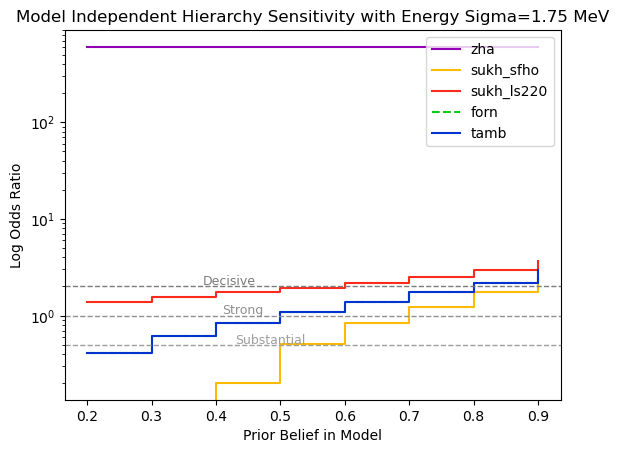

In [217]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


colors=['#9200b3','#fcba03','#fc2b1c','#02cf13','#0232cf']
names=['zha','sukh_sfho','sukh_ls220','forn','tamb']
linestyles=['-','-','-','--','-']
ratio_mins={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

for i,mod_name in enumerate(names):
    if(ratios_nh[mod_name][0][0][0]<ratios_ih[mod_name][0][0][0]):
        plt.step(prior_list,ratios_nh[mod_name][0][0],color=colors[i],where='post',label=mod_name,linestyle=linestyles[i])
        ratio_mins[mod_name]=ratios_nh[mod_name][0][0]
    else:
        plt.step(prior_list,ratios_ih[mod_name][0][0],color=colors[i],where='post',label=mod_name,linestyle=linestyles[i])
        ratio_mins[mod_name]=ratios_ih[mod_name][0][0]
plt.legend(loc='upper right')


plt.title('Model Independent Hierarchy Sensitivity with Energy Sigma=1.75 MeV')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Log Odds Ratio')
plt.axhline(y=2, color='#7B7B7B', linestyle='--', linewidth=1)
plt.axhline(y=1, color='#8F8F8F', linestyle='--', linewidth=1)
plt.axhline(y=.5, color='#9E9E9E', linestyle='--', linewidth=1)
plt.text(.38,2.1,'Decisive',fontsize=9,color='#7B7B7B')
plt.text(.41,1.05,'Strong',fontsize=9,color='#8F8F8F')
plt.text(.43,.51,'Substantial',fontsize=9,color='#9E9E9E')
plt.yscale('log')

"""
plt.annotate('', xy=(.85, 2.8), xytext=(.85, 1),
             arrowprops=dict(facecolor='grey', arrowstyle='->'))


ax_inset = inset_axes(plt.gca(), width="30%", height="20%", loc='lower right')
for i, mod_name in enumerate(names[-4:]):  # Last three models
    ax_inset.step(np.linspace(.8,.9,10), 
                  np.linspace(np.abs(high-ratio_mins[mod_name][-1]), np.abs(high-ratio_mins[mod_name][-1]),10),
                  color=colors[i+1], where='post', linestyle=linestyles[i+1])
    print(mod_name,np.abs(high-ratio_mins[mod_name][-1]))

# Customize the inset
#ax_inset.set_xlim(0.2, 0.9)  # Same x-axis range as the main plot
#ax_inset.set_ylim(1.38, 3.67)  # Set y-axis limits to focus on the region of interest
ax_inset.set_yscale('log')
ax_inset.set_yticks([1e-6, 1e-10, 1e-16, 1e-14])
ax_inset.set_yticklabels([r'$10^{-6}$',r'$10^{-10}$',r'$10^{-16}$',r'$10^{-14}$'])
#ax_inset.set_title('Distance to Max Log Ratio')
#ax_inset.tick_params(axis='y', which='both', labelleft=False)
ax_inset.tick_params(axis='x', which='both', labelbottom=False)
"""

In [152]:
high_nh=logsumexp([-71.67830237082967, np.log(.9), np.log(.025), np.log(.025), np.log(.025)])
high_ih=np.log(.025)
high=high_nh-high_ih
"""
print(high-ratio_mins['forn'][-1])
print(high-ratio_mins['sukh_sfho'][-1])
print(high-ratio_mins['sukh_ls220'][-1])
print(high-ratio_mins['tamb'][-1])
"""

print(ratio_mins['sukh_ls220'][-1]-ratio_mins['sukh_sfho'][-1])
print(ratio_mins['sukh_ls220'][-1]-ratio_mins['forn'][-1])
print(ratio_mins['sukh_ls220'][-1]-ratio_mins['tamb'][-1])

7.72411526339667e-06
7.723749382293477e-06
7.723749471111319e-06


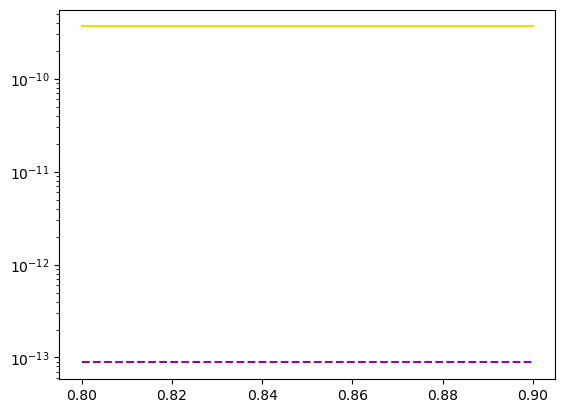

In [140]:
for i, mod_name in enumerate(names[-4:]):  # Last three models
    plt.step(np.linspace(.8,.9,10), 
                  np.linspace(high-ratio_mins[mod_name][-1], high-ratio_mins[mod_name][-1],10),
                  color=colors[i+1], where='post', linestyle=linestyles[i+1])
plt.yscale('log')